# Advantage Actor-Critic (A2C)


https://arxiv.org/pdf/1506.02438.pdf

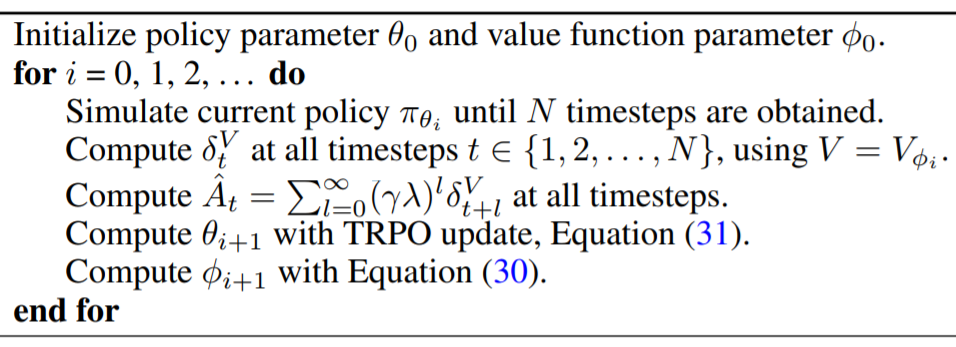

There is no TRPO update here, just advantage and MSE

In [1]:
import numpy as np
import gym
import tensorflow as tf
import scipy
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

critic_learning_rate = 1e-4
actor_learning_rate = 1e-4
epochs_number = 200000
batch_size = 128
replay_buffer_size = batch_size
l2_regularization = 0

discount_factor = 0.98
lambda_factor = 0.96

env_name = 'HumanoidStandup-v2'
environments_count = 40

# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [3]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [4]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

        action_logprob = gaussian_loglikelihood(self.action_ph, mu, log_std)

        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = -tf.reduce_mean(action_logprob * self.weight_ph) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
        l1 = tf.layers.dense(self.state_ph, units=20, activation=tf.nn.relu)
        output_linear = tf.layers.dense(l1, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
        #action_op = tf.expand_dims(tf.constant(1), axis=0)

        # Training
        output_log = tf.nn.log_softmax(output_linear)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        self.loss = -tf.reduce_mean(responsible_output_log * self.weight_ph)

        optimizer = tf.train.AdamOptimizer(learning_rate=actor_learning_rate)
        self.update_op = optimizer.minimize(self.loss)

    
class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)
        print(self.value_op)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.loss)
    
actor = ActorNetworkContinuous()
critic = CriticNetwork()

W0721 11:49:28.406619 11972 deprecation.py:323] From <ipython-input-4-f1ca94053e9b>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0721 11:49:28.410481 11972 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0721 11:49:28.778353 11972 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [6]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
np.hstack((a, [[11], [12], [13]]))

array([[ 1,  2,  3, 11],
       [ 4,  5,  6, 12],
       [ 7,  8,  9, 13]])

In [7]:
def f(x):
    x[0] = 6

In [8]:
a = np.array([1, 2, 3])
f(a)
print(a)

[6 2 3]


In [9]:
def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

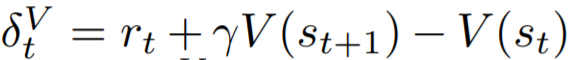

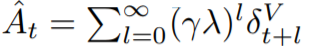

In [10]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [11]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    
    # [state, action, advantage, discounted reward-to-go]
    replay_buffer = np.empty((0,4), np.float32)
    
    # [state, action, reward] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(actor.action_op, feed_dict={actor.state_ph: observations})
#             actions = [envs.action_space.sample() for i in range(envs_number)]
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            rewards /= 5000
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum() * 5000)
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage

                discounted_reward_to_go = discount_cumsum(rewards_trajectory, coef=discount_factor)

                
                rollout = np.hstack((rollouts[i], np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 3))
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([ 1.20766873e-01,  5.52283159e-01, -6.75289253e-02,  6.32264632e-02,
       -8.28508039e-01,  1.04548019e-01, -3.95628709e-01, -4.51868204e-02,
        6.87218918e-02, -3.20299794e-01, -1.33784908e-01, -2.24761475e+00,
       -3.39144766e-04,  1.60875315e-01,  1.61633149e-01, -9.08685606e-01,
        5.87780354e-01,  4.73671352e-01, -1.13972496e+00,  7.23900296e-01,
        6.04576883e-01, -4.21065432e-01, -3.70577300e-01,  2.96917300e-01,
       -5.43999459e-01,  2.30521493e+00, -9.40062791e-01, -5.86757261e-01,
        3.86746929e+00, -2.51508370e+00, -4.58950697e+00,  3.09435860e+00,
        2.32156846e+00,  1.33187026e+00,  1.52957179e+01,  8.66463580e+00,
       -5.37513889e+00,  9.52363380e+00,  7.18820138e+00, -9.59964974e-01,
        3.49205810e+00, -4.88330670e+00,  9.02628697e-01, -3.42561278e-01,
       -7.90513026e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.0000000

## Train agent 

In [12]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}

In [13]:

max_value = 50000

In [ ]:
from tqdm import tqdm_notebook

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

saver = tf.train.Saver()

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']


    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-reward-{value}.ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value

    _, actor_loss = sess.run([actor.update_op, actor.loss], feed_dict={
                                                actor.state_ph: np.array(batch[:, 0].tolist()),
                                                actor.action_ph: np.array(batch[:, 1].tolist()),
                                                actor.weight_ph: batch[:, 2]})

    _, critic_loss = sess.run([critic.update_op, critic.loss], feed_dict={
                                                critic.state_ph: np.array(batch[:, 0].tolist()),
                                                critic.value_ph: batch[:, 3]})
    
#     history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
#     history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    
    history['critic_loss'].append(critic_loss)
    history['actor_loss'].append(actor_loss)



Charging generators


Model saved in path: ./models/HumanoidStandup-v2-reward-107038.ckpt
Model saved in path: ./models/HumanoidStandup-v2-reward-107251.ckpt
Model saved in path: ./models/HumanoidStandup-v2-reward-107328.ckpt
Model saved in path: ./models/HumanoidStandup-v2-reward-108700.ckpt
Model saved in path: ./models/HumanoidStandup-v2-reward-108738.ckpt
Model saved in path: ./models/HumanoidStandup-v2-reward-109196.ckpt


Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


## Plot results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'HumanoidStandup-v2')

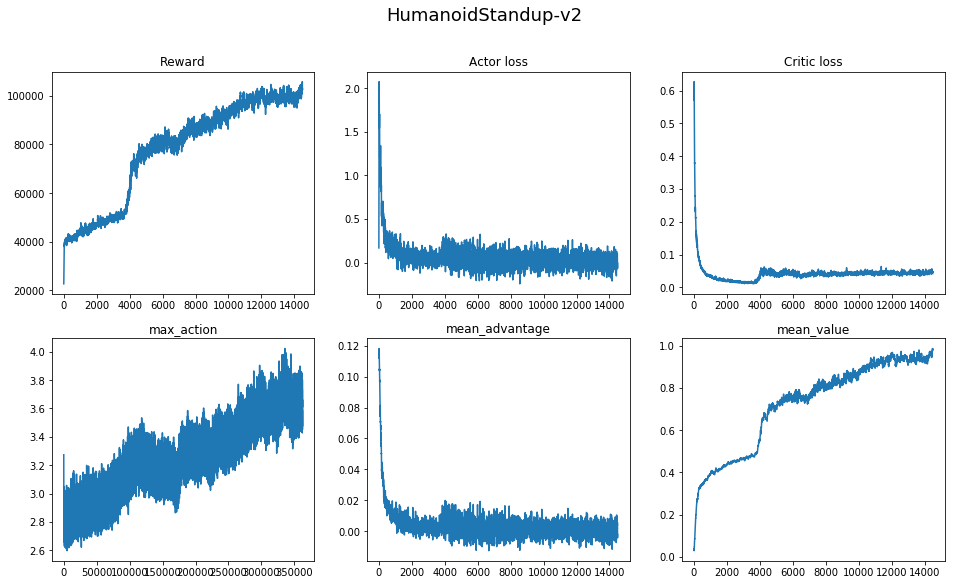

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

# plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


# parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
# plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name, fontsize=18)

# plt.savefig(f'logs/{env_name}')

## Our agent

In [9]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])

    print('h', rewards, actions[0])


    if dones:
        observations = env.reset()
        print('Done')


Creating window glfw
h 38.602327029140554 [-0.22028753  0.41584015  0.82417727 -1.3168256   0.7163293  -0.45605636
  1.9958752   1.6024882   2.1441348  -0.6063957   2.0845556  -2.505909
  0.00568345  0.75200677 -1.4771961   1.1746105  -1.6370718 ]
h 44.001966597779756 [-2.2502437   0.6533729   2.291344   -0.45183742 -0.8404077  -2.1682081
  2.132018   -0.6858288   0.9935986  -4.180523    2.441638    0.22640365
  0.9320906  -0.9703627  -0.29125366 -0.3763962   0.09228653]
h 50.910530782328046 [-1.293757    0.42169574  1.3490403  -0.64446825 -0.32998544 -1.706418
  0.5615958  -0.19754747 -1.3047504  -2.577668    0.7268938  -0.3512172
  0.8353099  -1.5685444   0.31389955  1.2541356   0.90299684]
h 58.98010292663734 [-1.162022   -0.50342     1.2755016  -1.0526309  -0.34779513 -2.179496
  1.3073703  -0.17955276  0.7015507  -2.4517913   1.4509068   0.3207916
  0.5710592  -0.39926544 -0.48295212  0.3364646   0.59293103]
h 67.75475442368281 [-1.0178692  -1.827323    1.8588336   0.37792593 -0.1

h 96.41454629539548 [-1.3635651e+00 -3.9174926e-01  1.0800890e+00 -5.7139754e-01
 -6.6036910e-02  7.1168989e-01 -1.1943471e+00  1.2142062e-03
 -8.2746661e-01  8.8899350e-01 -1.1197479e+00 -6.3886142e-01
 -1.9823413e-01 -1.7649448e-01  4.7612122e-01 -4.9118182e-01
  1.4110670e+00]
h 102.52166816901116 [ 0.61912847  1.1957784  -2.1167905   0.6180693   0.09374236  1.3453872
 -3.2264087  -0.78382146 -0.6862382   1.5067089  -1.6677554   1.8962255
 -0.4173264   1.7373438  -0.31168535 -0.25849345  0.8209113 ]
h 110.3111289101909 [ 0.8930762   0.19016957 -3.3302703   0.8394999  -0.78630847  0.18784356
 -3.0293617  -0.15228042 -1.7331831   1.2550892  -1.4364274   0.7127951
 -1.269648   -0.2520743  -0.18855062  0.8760305  -0.811519  ]
h 120.1751007732747 [ 2.0746565  -0.657966   -2.2391052   0.5998467   0.6095313   1.7195799
 -1.2893136   0.7481636  -1.0279682   2.5532212  -0.68228006  1.4468458
 -0.6468187   0.8769202  -0.07082766  0.3412708   0.04033595]
h 131.0840064741756 [ 0.77828825  1.027

h 84.04811984198189 [ 0.99979293  0.29882646 -2.0180087  -0.28946096 -0.41665262 -0.10603672
 -0.93843836  0.8573638   0.780578    1.2620307   0.19764704  0.41301563
 -0.13842142 -0.7401164  -0.32211992  0.18816885  0.75824285]
h 89.30297423001868 [ 0.9947761   1.4448181  -0.7205554  -0.12741718  0.98241603 -1.8880719
  0.20279017 -0.05807841  0.95701694 -0.0311047   1.7551064  -1.0765855
  1.0443437   2.1742063  -0.3380506  -0.42626917 -1.6023834 ]
h 94.25481828144625 [-0.6507592   1.5288186   1.496656   -0.33039024  0.25390828 -1.9285642
  2.186185    2.035557    1.2133118  -0.592329    2.1960378  -0.99415773
 -0.02742773 -0.29068023  0.0133853   0.76137865  0.14387715]
h 98.28118698173377 [-2.106175   -0.5781456   1.1209316  -1.0492935  -0.9567094  -1.5295362
  2.6327925   0.33520854  1.3844268  -1.6102167   1.4541878  -0.94108367
  0.71629196 -1.296911    0.73457396 -0.621578    0.26199186]
h 101.6468759810493 [-1.8675264   0.70136064  1.4426787  -0.73178345  0.11020997 -0.6129121


h 107.89228213580354 [-1.4157916  -0.3881796   1.5568604  -1.0128481  -0.26678187 -1.900051
  1.4832952   0.14875056  0.39838174 -2.4023166   2.0520551  -0.7578727
  0.13385463 -0.97020495  0.5932176  -0.26405457  0.7864493 ]
h 113.1492009320144 [-1.1943374  -0.08085139  2.6826653  -0.6442199  -0.88310814 -1.151
  1.3610228  -0.4344539   1.2442425  -1.2363534   2.4465866   0.42300558
 -0.6993419  -0.40953234  0.42258945 -0.6903285   1.3144813 ]
h 118.31334104109294 [-1.5318847  -0.15534191  1.1205852   0.14949171  0.26430178 -0.8866863
  0.5922895  -0.9559419   0.9112073  -2.4098272  -0.37003136  1.0640633
 -0.06778958 -1.0986669   0.08056049  0.63572615  0.09687248]
h 122.99926417620165 [-0.42169407 -0.6854383   0.8526937   0.4462969  -2.0240679  -0.3851877
  1.0259335  -0.8693602  -0.47650823 -2.5043542  -1.459649    1.370537
 -0.6472468  -0.9566705   1.7401768  -0.20083608  0.8540393 ]
h 127.8243888470205 [-0.06066561 -0.22071743  1.5438166  -0.5879294   0.29908803  0.09445101
  1.2

h 76.95198950991947 [-1.0724055  -0.16777912  0.7973455  -0.48301318 -0.38928425 -1.5205595
 -0.23438191  0.03188124  0.71053326 -2.7111773   1.1039954   0.5708741
  0.5236343  -0.5766173   0.2813664  -0.3843138   1.4809177 ]
h 75.7273164094406 [ 0.12105606 -0.93319625  1.5219722  -0.02752566  0.07816866  0.10177743
  0.43750533 -1.1948134   0.39020762 -0.9177824   0.01624173  0.68714374
 -0.7026164  -0.85992825  1.4804666  -1.4361186   1.1601425 ]
h 73.06095340691412 [-1.1535177  -1.0280147   0.30838    -0.39182365  0.69468737 -1.1349281
  0.69229096 -0.68737245  1.4463856  -0.7233038  -0.93513393 -0.67343533
  0.2615104  -0.5627983   0.26461816  0.5737314   1.2560806 ]
h 72.2792155742442 [-0.79242563 -0.13943279  0.5480769  -1.176153    0.0982281  -0.32007802
  0.14820814 -0.2239258  -0.13386226 -1.0133197  -0.1571436   0.08200037
 -0.2207174  -0.6127022   0.64682543  0.54448295  0.35410762]
h 74.04333041637994 [-1.1948134  -2.027166    2.0963202  -0.95326596 -0.85727334 -0.14042157


h 225.87461745503307 [-1.3648804  -1.3521945   1.4387069  -0.8613553  -1.3673795  -1.4971353
  0.9202243   0.56826603  0.67223686 -1.1351256   2.016624   -0.41038388
  0.41836184 -0.35738534  0.5579054   0.82552826  0.7711676 ]
h 217.32802325435833 [-0.1426903  -0.43720806  1.1226444  -0.666872    0.06497782 -0.9371919
  1.6024541  -0.29727316  1.1184165  -2.0710235   1.3619648   0.36681062
  1.0326003  -0.8144608   0.31071502 -0.48284334  0.41623247]
h 207.30682206267224 [-0.9061709  -0.18808764  0.37874663 -1.1146545  -1.6231416  -1.7736828
  1.6905253  -0.6248529   0.98816097 -1.3217907   0.9955392  -0.2054533
  0.1446149  -1.6858245   0.38840234  0.03042686  0.10001966]
h 196.21299074829204 [-0.65512294 -0.42048168  0.7342083  -1.3846712  -0.10434413 -0.33216113
  0.08857262  0.04877719  0.02899125 -1.2457023  -0.08005279  0.68074584
 -0.97492164 -0.98636025 -0.67427945 -1.0453095   0.5569196 ]
h 184.93500593226815 [-0.5653039  -0.00766903  0.5934109  -0.15043929 -0.762344   -0.859

h 148.24438222713434 [-0.5715065  -0.5552516   1.3568684   0.41278994 -0.07120682 -1.0374764
  2.3452213   0.7336349  -1.0082564  -0.74805325  1.3099434  -0.32415426
  0.74075246  0.43625832 -0.38185513  1.137956    0.47041374]
h 148.17685014951377 [-1.56934953e+00 -2.37022027e-01  1.57198811e+00  1.77144766e-01
 -5.99247932e-01 -1.99348211e+00  2.00658774e+00 -1.11302733e-03
 -8.80774856e-02 -1.59666514e+00  2.16703033e+00 -4.14645791e-01
  1.37000215e+00 -6.50818169e-01 -1.18103206e-01 -4.84336346e-01
 -1.71206862e-01]
h 148.3553757742248 [-0.43415684  0.67924976  1.0841693  -0.2833871  -0.39223978 -1.4322534
  2.3821058   0.8217497   1.1422334  -2.2006505   1.2770581   0.76905525
  1.5235958  -0.09989524 -1.5253279   0.82729214 -0.10352159]
h 148.41177733769177 [-1.3193328   0.41583738  0.5529797  -0.01346062 -1.127148   -1.2168169
  1.4713019   0.34146363 -0.5968581  -1.1928279   1.6739143   0.15488052
  1.4857404  -0.87288064  0.1541476   0.18677661  0.63342285]
h 147.404463816311

h 92.4771001054924 [-1.2301441  -1.2917027   1.654059   -1.6763285   0.3151607  -1.1085894
  0.6680052   1.084142   -1.3265405  -0.8467133   0.486938   -0.6975781
  0.32493538 -0.6075882  -0.27350459  0.8750731   1.4115525 ]
h 88.75000027931439 [-1.1394625   0.46725917  1.893508   -0.30724317  0.64033306 -0.5119574
  1.3831625   1.1366239  -0.28553778 -1.1610575   1.5418708  -0.43912852
  0.5966466  -0.8755698   0.47987565  0.7446784   0.8732128 ]
h 83.8870165701799 [-1.637461   -0.2588167   0.46650368 -0.6862024  -1.0942807  -1.257722
  1.5313537   0.12487475  1.8766487  -1.4503491   2.127624    0.48294476
  0.8309468  -0.8350818   0.13158166  0.46890405  0.4493956 ]
h 78.48747104765047 [-1.9638236  -0.06292754 -0.16879642 -1.6229416  -0.17088181 -1.1444004
  1.7229366  -0.08529451 -0.7703376  -1.763183    0.23183098  0.1602394
  0.5607432  -0.75520915  0.32370892  0.6359578   1.1085274 ]
h 73.42771964273767 [-1.7499279  -1.1740178   1.8103441  -0.88700986 -0.2105043  -2.2396483
  1.1

h 89.06967147324778 [-1.5655649  -0.11973171 -0.5980443  -0.65632814 -0.9321517  -1.6320517
  1.4981306   0.16893272  0.9807631  -1.7328006   2.3285642  -0.2099463
 -0.1535775  -0.94710463 -0.04474531  0.3186845   0.6121591 ]
h 88.63504686326814 [-1.6222773   0.097139    1.8702148  -0.01000783  0.40836683 -0.9514808
  2.1549082   0.8739284   0.87875843 -1.4097214   1.7329165  -0.33523372
 -0.24680269  0.52171737 -1.3415649   1.0625963   0.71611595]
h 89.74723654427544 [ 0.18544376  0.5785901   0.9426763   0.4796512  -0.7523788  -2.7415562
  2.2886248   0.52764374  1.9802034  -2.6109676   0.7176728   0.040125
 -0.29597723 -1.0800323  -0.8930129  -0.4145971   1.0542573 ]
h 91.97333691802277 [-0.8989903  -0.1630492   0.34915793  0.362981   -0.8681817  -0.85151696
  1.122521   -0.05938815  0.3171023  -1.7625265   0.98785484  0.7789577
  0.8611214   0.8212377  -0.5848416   0.07458305  0.34817213]
h 94.67225543378642 [-1.2691395  -0.54436463  1.8898976  -0.4302674   0.05799139 -1.123944
  1.

h 85.69239411989227 [-1.0322949  -1.0037988   0.05461627  0.5017051  -0.50102097  1.0613055
 -0.48336136 -0.7300177  -0.46236873  0.80270237 -1.5106324  -1.1217036
 -0.7865453  -0.59704316  0.18603098  1.0635469   0.7153808 ]
h 89.95482306332228 [ 1.3500307   0.13306484 -1.6800344   0.6865714  -0.02507178  2.8070784
 -2.5517104  -0.24307513 -0.809972    2.1590202   0.2525704   1.8373375
  0.31794834  0.98768723 -0.05146345 -0.43574518 -0.6520856 ]
h 94.24918795785906 [ 1.3765717   0.85487    -0.26247573  0.242077    1.0832262   0.07622898
 -0.5181626   0.89329547 -0.20329379  2.876052    1.1805438  -0.9141158
  0.36222446  1.0970219  -1.6440128  -0.01946342 -0.7047528 ]
h 98.30634807978576 [ 1.6648414   1.3320749   0.05615085 -0.20971236  0.57407004  0.04374094
  0.06149679  1.6816242   2.4714758  -0.30621046  0.3172651   1.0891385
  0.34772855 -0.13934201 -1.6180052   1.0164167  -1.8013463 ]
h 101.64503463197941 [-0.35300505 -0.3551836   0.7569      0.06083602 -1.1116669  -1.2727537
 

h 81.42317219738685 [ 1.4486465   0.10481206 -0.4603896  -0.3382122   1.9169127   1.2507019
  0.4309583   0.94888616 -0.6834276  -0.1789951   1.0418441  -1.0929952
  0.2400019   1.0630081   0.3949485   0.19141066 -1.1170144 ]
h 81.87535714463876 [-0.9077655  -0.8108696  -0.23727399  0.04029879  0.5242861  -1.0593044
  0.6775713   2.029318    0.27299055  0.5801983   1.0049338  -1.25866
 -0.02763087  0.39860177 -0.37333733  0.27427614 -0.1087256 ]
h 81.09953492973938 [ 0.8034556   0.98875976  2.0333948   0.13001913  1.3513956  -2.1013317
  1.2011416   2.4682245   0.5989963  -1.1317418   2.1965652  -1.5652474
  0.70596385 -1.332627   -1.3786213   0.06303819 -0.79136395]
h 80.37694411434882 [-0.7795607   0.4006451   0.89586616 -0.5000226  -0.15116811 -1.7291869
  2.5745714   0.305121    2.617158   -2.7236729   2.4297547   0.3579761
 -0.19177186 -1.0732633  -1.7728488  -0.04696909  0.52859133]
h 79.14931834747948 [-0.65944374 -1.0314144   0.59078324 -0.07948196 -0.6596498  -0.98643374
  2.2

h 78.68969607646038 [-0.7280207  -0.42177236  2.0970273  -0.51573145 -0.41661775 -1.6183758
  1.2938874   0.29682362  0.4431195  -0.9591035   1.2419509   1.561672
  0.05725145 -1.3425223   0.43370804  0.98002446  0.5017312 ]
h 80.93123817784712 [-2.1414843  -0.10563815  1.4879373  -0.34640267  0.10897148 -0.5573684
  1.336177   -1.4191599   0.5740894  -2.0053995   0.04513556  0.04263331
  0.7299938  -0.6663228   0.35358515 -1.6170233  -0.06623682]
h 82.76025864944607 [-0.7408155  -1.7437603   1.492024   -0.5379756  -0.28905058 -0.17613578
  1.4733646   0.4945381  -0.13537933 -2.316759    1.7917308   0.88560176
 -0.20734917 -0.60144466  0.87063146  1.007683    0.9221551 ]
h 84.1198029621653 [-1.2526512   0.11203772  0.18498844  0.18034966 -0.94539356 -0.5976957
  0.89866805 -0.03653465 -0.44329512 -0.70179826  1.3580539  -0.46780607
  1.3574204   0.04270709  1.1999466  -1.075354    0.6122614 ]
h 84.87476251942816 [-0.6719842   0.3052444   2.2774312  -0.7836926  -0.8761394  -1.5443655
  

h 113.33959437453831 [-0.45652235  0.04445501  1.8829707  -0.96368575 -0.3814687  -1.6641563
  3.0022774   2.0745478   2.2116597  -2.0284219   2.3520343  -1.2844374
  1.3273458  -1.3202478  -0.18799481  0.73141754  0.78292835]
h 119.09160650464837 [-1.1647664   0.4016162   0.7023968   0.4677828  -1.76372    -2.1006656
  2.0322971   0.02121222 -1.5340054  -2.5935025   1.5201355  -0.14255327
  0.17868811 -0.71867806  0.58880925  0.01975498 -0.05933213]
h 124.55193892006999 [-1.1573071  -0.15121076  1.0486752   0.01705912 -0.647842   -2.143703
  2.3629806   0.69613856  1.4010623  -1.8625675   2.0275748  -0.08700366
  0.7435956  -0.5330258  -0.0586966   1.111403    0.7828111 ]
h 128.16352707659757 [-0.994461   -0.09732581  1.7305775  -0.5471783  -0.29315305 -1.8292301
  1.7377803   0.22012633  0.33776796 -1.831182    0.8741526  -0.41466248
 -0.08406007 -0.8527575  -0.12428069  1.622274    1.5076251 ]
h 130.2434337943957 [ 0.03897238  0.8618939   1.6179755  -0.40462294 -1.5668564  -1.804346

h 95.82579822426263 [-0.25970393 -0.42685464  1.0892076  -0.9805324   0.25509492 -1.6488513
  0.7470603   0.29128793  1.2966392  -1.6096938   1.721083    0.2640314
  0.34538317 -0.6120679   0.05820578 -1.1092731  -0.14901736]
h 105.22008327951112 [-1.963249    0.1286085   0.83709186 -0.8576424   1.0098654  -1.5391829
  2.3838305   0.31512374  0.2871073  -2.2057602   1.1624074  -0.9308372
  1.2425756  -0.55024296  0.04091269  0.37108004  0.61260587]
h 115.10801024705809 [-1.463441   -0.19298089  0.80716074 -1.642493   -0.7593914  -2.5338774
  3.1353781  -0.44078568  0.61935484 -1.9367499   1.704808    0.1738069
  1.2163227  -1.9342129   0.7674515   0.36800033 -0.22922748]
h 124.97767029321614 [-1.02905    -0.5791199   0.5000155  -1.2385538  -0.57262784 -1.1155453
  0.685611   -0.23639813 -0.29111043 -2.214775    1.1987971  -0.72071993
 -0.3354736  -0.3228476   1.8429282   1.1673775  -0.43907297]
h 134.65206557213094 [-1.20788574e-01 -1.22703123e+00  1.40896773e+00 -5.49312115e-01
 -3.37

h 116.98936078168494 [ 0.520716    0.02315593 -1.1053289   0.2930984   1.8605549   0.81663215
 -1.8604738  -0.08577186 -0.2497325   0.85277474 -1.4798298  -0.27627248
 -0.81660557  0.07247487 -1.0861007   0.48259887 -0.25797823]
h 111.31830159293557 [ 1.3748925   2.423017   -1.9085509   0.7495998   1.0367119   2.1381538
 -1.9784863  -1.393665   -1.3323927   1.7405727  -0.5376047   0.41215986
 -1.9115049   0.5784383  -2.0740075   0.26321304 -0.7604281 ]
h 103.1958218136357 [ 0.7283962   0.12751581 -0.9982182   0.03579769  0.5867874   1.6525538
 -1.4733605  -0.5550066  -0.8587969   2.5742009  -0.94023955  0.0439415
 -1.203217    0.8285254  -0.13702112  0.26231864 -0.45461437]
h 93.37124926147051 [ 0.94120324  1.8868134  -2.6875029   0.7808507   1.1861414   2.6054525
 -2.5421264  -1.289895   -0.4630411   1.6956527  -2.2301779   1.6354761
 -1.204236   -0.28680593 -0.912506   -0.66683984 -0.13009906]
h 83.72311223208911 [ 0.70833075 -0.05235551 -0.49078125  0.6150081   1.4684378   1.1648623

h 139.4160692793562 [ 1.1515338   0.5054015  -1.6079564   1.384124   -0.8006394   0.39635095
 -1.5218031  -0.46290234  0.24622351  0.29531807  1.0615362  -1.094068
 -0.22956467  0.5272424  -0.388599   -1.5060394  -1.1521258 ]
h 134.02388870213346 [ 0.21361408  1.1028047  -1.4358251  -0.9244153  -0.08789028  0.8806574
 -1.5274682   0.668322   -0.18995127  1.0365742   0.6020568   0.7941046
  0.05430377  0.4401023  -0.73798496 -0.20277075 -2.7138133 ]
h 127.36424744427327 [ 0.03796965  1.532202   -0.81562006  0.01151633  0.74212176  0.44561702
 -1.1374737   1.1411395   1.4662292   1.3724161   0.8007296   0.29538777
  0.59667706  0.67577887 -0.46043777  1.0923135  -0.6341081 ]
h 121.36876851469297 [ 0.7354315   0.6581536   0.27736256 -0.41097552  1.1563665  -0.05156159
  0.5354543  -0.12656519  1.4019914   0.69377065  1.7296886   0.49469393
  1.5734813  -0.42653263  0.33528838 -0.5969769  -1.1113404 ]
h 118.01184500647962 [ 0.4614105   1.1050584  -0.65908456 -0.17089564  1.3252609  -1.5971

h 200.24052431794965 [ 1.3835518  -0.5088775  -0.87538004  0.48711398 -0.04765369  0.82223415
 -1.6338907  -0.3226853  -0.9477041   1.8150561  -2.3022878   0.41113147
 -0.941912   -0.50074834  0.85039157 -0.5004107   1.3599365 ]
h 204.2752595517197 [ 0.922092    0.7222813  -1.9927454  -0.7668689   0.55122733  1.9263787
 -2.710066   -0.35632783 -0.66392684  2.1221135  -0.74386525  0.4359503
 -0.37947464  1.2679743   0.71105516 -0.36068144  0.4251723 ]
h 208.43935684283477 [ 0.62464225  0.5846958  -2.0390482  -0.4227479   1.0636575   1.7951136
 -2.7931857   0.01400036 -1.0863425   1.249049   -2.1370516   0.40351248
 -0.14394125  1.8890508   0.22147799 -1.8050829  -0.32836312]
h 211.7044162985197 [ 1.6809043   0.9807619  -1.3084979   0.4519208   0.41488275  1.674385
 -2.2404544  -0.4947531  -0.01868474  1.9217858  -0.58974725  0.831601
 -0.38112748  1.181627    1.5355649  -1.4414424  -0.08141419]
h 213.59809953659064 [ 1.8696554   2.2604187  -1.7532784   0.8564595   1.3580139   2.5775425


h 217.2433007535792 [-0.80193686  0.57339644  0.05938679 -0.25866064 -0.8716438  -2.494929
  1.5292103   0.5872364   1.2153499  -2.568346    0.48771906  0.4795787
  1.1116581  -0.19994521  1.0530084   0.09274082  0.19718547]
h 211.30624710474572 [-1.5182889  -1.2212603   1.2038553  -1.0595245   0.14752814 -1.112343
  2.1969402  -0.33318457  0.3459301  -1.574701    0.55440485 -0.14958256
  1.5895677  -0.43385315  0.49857056  0.83433664 -1.1131488 ]
h 205.7353954494766 [-1.3512546  -0.47403538  1.5897228  -1.1160967  -2.2621827  -1.8039405
  1.4757589  -0.48788193  0.53359115 -3.7372198   1.794535    0.8206933
 -0.23476017 -0.20264035 -0.40531766 -1.4859736  -0.40836653]
h 201.13951487828754 [-1.339798   -0.7529276   0.65401936 -0.29792422 -1.4816555   0.12730908
  0.34667975  0.5106593  -0.01788801 -2.3787267   0.9330967  -0.5337751
  0.42928925 -0.20684156 -0.574034    0.7777439  -0.3727942 ]
h 195.54880331678237 [-1.2441167  -0.16450149  1.3929743  -0.24405874 -0.5080117  -0.5430638
 

h 78.82798197282095 [ 0.7579657   0.46836743 -0.7170328  -1.338852   -0.71417314  1.4571615
 -1.1072539  -0.7450073   0.6247324   1.6906073   0.04101813  0.77385795
  0.2651812   1.1571516   0.1310884  -1.3846684  -0.9745271 ]
h 76.35977203384505 [ 0.1768086   1.3383114  -0.9967455   0.8428248   0.23792696 -0.19502686
 -1.0999407  -0.1780411   0.30936733  1.8217955  -0.60486656 -1.3540081
  0.6386693   1.3664879  -0.5935927   0.6537478  -0.5244093 ]
h 76.62199113459384 [-0.04354981  0.67479527 -1.4483178  -1.0172503  -0.1635549   0.32808882
  1.3953598   1.0340297   0.04124641 -0.32530484 -0.10497704 -1.6658077
  0.86212003  0.35812443  1.1518736  -0.4003346  -1.1579834 ]
h 76.59418129911141 [-0.30319154 -0.35038722  0.8412641  -0.5982191  -2.0341947   0.5366442
 -0.13931683  0.5751878  -1.1447226   0.5130378   0.12403561 -0.51099706
  0.67518497  0.7232744  -0.02613069  0.17995104  1.4415864 ]
h 76.07480426167706 [ 1.3937044   1.7485354   0.77580696 -0.44360647  0.6222259   0.6509251


h 119.22652986738842 [-1.6460769  -0.15288347  1.0432537  -0.5292044  -0.9540331  -1.0870874
  1.9576004   1.8247396   0.3430593  -1.6310782   2.2181318   0.05496156
  0.6085743  -0.6707313  -0.15179639 -0.08564478 -0.5855587 ]
h 119.27120751978104 [ 0.2712481   0.26929685  2.2161953  -1.3187721  -0.43159437 -1.3456748
  0.8949101   0.6013146   0.33526197 -1.8618745   2.0284073   1.5214704
  0.7450004  -1.7281151   0.08081029  0.37909347  0.91188204]
h 118.45535999464107 [-1.329488    0.42281833 -0.00395566 -0.88531864 -1.448828   -2.3966696
  2.3068438   0.87442696 -0.03870451 -2.0052242   1.3619112   0.9332297
  0.37453562 -1.095767   -0.35200366  0.2543198   1.3514162 ]
h 116.52114316203603 [-1.433841   -1.3720928   2.010011   -1.2655804  -1.004565   -2.1254826
  1.9101453   1.2642922  -0.06400949 -2.0135803   0.38300753  0.12101519
  0.41767472 -0.9909986  -0.29276943  0.06222256 -0.14840174]
h 114.23095392059663 [-2.0637398  -0.27669638  1.6820868  -1.0075225  -0.6993382  -1.19624

h 97.4628271939579 [ 1.4342437   1.1513745  -3.2711496   0.10126107 -0.25473386  1.0414776
 -1.0785825   0.8334119  -0.3971286   2.596221   -0.16038184  0.5203172
 -1.2906749   0.9946991   0.75885344  0.35844257 -0.42137286]
h 98.1472534751773 [ 0.62805593  1.6272513  -1.4964162   0.30806273 -0.08044051  0.22031033
  0.10789073 -1.1670973  -0.24711291  2.0164332   0.35586473  0.72682333
 -0.6597188   1.1990187  -0.00463583 -1.3252103  -1.2758664 ]
h 98.09587017576736 [-0.7587551   1.1769739  -1.7218945  -0.8886583  -0.15836318 -0.88007826
  0.25341165  1.3146372   0.14633334  1.2970883   0.68014926 -1.0091069
  0.63366127 -0.4587617   0.45357293 -0.22184497 -0.18362767]
h 98.2427000266878 [ 0.704708    1.2475864   0.11068986 -0.5540149   0.31363863 -2.4885328
  2.068586    0.31780684  1.7827755  -1.4774567   2.6313357  -0.38548285
  0.9341987   0.35673302 -0.02757084  0.04731526 -0.71173066]
h 99.33918303881374 [-0.7650743  -0.4687871   0.75162315 -1.5032701  -0.62765497 -2.4303133
  1

h 120.65400605007832 [-2.218083   -1.4617057   2.065286   -0.99798477  1.8301256  -1.6853199
  2.5907302   0.10433803  0.14163679 -2.5804644   1.5293365  -2.16438
  1.0944297   0.10631359 -1.1189811  -1.4705486  -0.46186757]
h 125.91750438083427 [-1.9721735  -0.84239084  1.4588258  -1.1182623  -0.772816   -1.5959543
  1.7998809   0.11383357  0.7096262  -2.898853    1.251719   -1.8970977
  0.5698073  -1.0062227   1.6255966  -0.70493263  0.19332688]
h 130.27925313337335 [-0.02364385 -0.61131364  1.8737302  -0.7481872  -0.8858786  -1.2572303
 -0.21962094  0.37370855  0.46405405 -1.056957    0.94573134  0.15149987
  1.1565216  -0.95226276  0.5581689   0.49960178 -0.32328457]
h 133.0359152840958 [-1.0310049  -2.149018    0.46795183 -0.19026496 -0.0751548  -2.054175
  2.3089907  -0.37100717  1.9521296  -1.7536788   0.95048404 -1.9536121
  0.7104834  -1.3060411   1.6149857  -0.5502596   0.39635408]
h 133.7033593382017 [-1.6793461  -0.20511329  1.8937835   0.11438698  0.20500275 -1.17097
  1.8

h 113.32894077053979 [-0.67946136 -1.4018232   1.7613951   0.63846654 -0.14100514 -3.1168766
  1.6109419   0.47648025  1.351403   -1.2287285   2.4949725  -0.88457125
 -0.07967234 -1.7687593   0.13235989  1.7101965   0.47588703]
h 113.47226893862906 [-1.780762   -0.3167474   1.5854412  -0.22450858 -0.5143786  -2.0135157
  2.3991706   1.578121   -0.11976594 -1.498388    1.9505914  -0.24857408
 -0.6055709  -1.7317157   1.2610276   1.0612137   0.37850985]
h 114.00798399274898 [-0.30088687  1.4730915   2.1708393   0.41280377  0.03498217 -2.3585112
  1.9424616  -0.1636802   1.2315127  -1.7053337   0.7396328   0.27936476
  0.6537607  -0.41042286  0.8195261   1.1579161  -0.84233737]
h 115.0887643825308 [-0.1968843   0.36964032  1.094382   -1.3432549   0.22909766 -2.812307
  1.3994925   0.05546215  1.4773095  -2.4844272   1.2590548   1.1445032
  0.7069579  -0.6470229   1.2571368   0.3838493  -1.53211   ]
h 116.02379286421368 [-0.9380188  -0.5007913   1.7993109  -0.5913127  -1.0060622  -1.239029

h 153.51006954416974 [ 0.08315742 -1.0951501   1.8353194  -2.331835    0.05498335 -1.5169501
  0.7376242  -0.60148555  0.7160411  -1.3821856   0.34155217 -0.38567042
  0.8531358   0.1088044  -0.0781166   0.23845103  1.3950908 ]
h 157.6796047249999 [-0.867655   -1.325269    1.6395663   0.40800622 -0.28284693 -2.2273679
  2.6791117   0.96051884 -0.10863703 -1.6472647   1.3145523  -1.0185806
  0.9476682  -0.77092105  1.030805    0.22151864  1.0448562 ]
h 160.29931897416083 [-0.3038392  -0.24284333  1.9028965  -1.3063937  -0.6182165  -1.7479442
  2.3929102   0.15261805  1.0577638  -1.8246878   1.1214707  -1.1516652
  1.1260867   0.2608204   0.36572814  0.38735223  0.64714015]
h 161.38135079833157 [-1.9472566  -1.0965711   2.18234    -0.2873028  -1.5567193  -0.5693675
  2.327176    0.10355014  0.41205952 -1.2528965   0.9022527   0.47032133
  0.13768739 -1.4338547   0.03282684 -0.18883032  0.06073684]
h 160.95252902500687 [-1.4480181  -2.0973759   1.4873207  -2.6142142  -1.1186882  -0.831061

 -0.1677624  -0.86368644  0.25487316  0.968251    0.4539659 ]
h 155.31998361229367 [-1.9890077  -1.1176288   1.5754198  -0.59568447 -0.23267972 -2.1824827
  2.8931427   0.7183269   0.68934464 -2.9098608   0.986567   -1.0232923
  1.5892123   0.08582085  0.15942073 -0.6368177   1.3696058 ]
h 154.43294091116476 [-1.486358   -0.78814507  1.9437885  -0.86161005 -0.75516075 -1.5155803
  2.6414404   0.6447953   0.3028671  -2.3047044   0.2803144   0.11086993
  0.6348089  -0.73062044  0.5835696  -0.13845006  1.3995973 ]
h 152.95335921290493 [-0.80781364 -1.6689887   2.477005   -0.93883324  0.74965113 -1.5746212
  1.7564789  -0.40551656  0.43322244 -1.7004826  -0.30173063  0.74110025
  0.24719131  0.42234766 -0.66885793  0.27265552 -0.53207445]
h 151.70048847395896 [-1.4821105   0.0383985   1.2294133   0.6658409  -0.01910582 -1.4708636
  1.472722    0.26428223 -0.9179609  -0.5915665   0.4386457   0.04984236
  0.9557368  -0.65227884  1.1215346   0.14779156  1.925852  ]
h 150.67493622471454 [-0.53

h 78.08855646043051 [-0.6972337   0.00891423  2.210753   -0.8633661  -0.7462951  -2.8830066
  0.91249114  0.38118547  0.6030196  -1.8367172   1.4058168  -0.75168097
 -0.7186139  -1.8433384   0.5011489   0.3362098  -0.5037969 ]
h 86.25056838251058 [ 0.17248952 -0.3469684  -0.07244962 -0.70314854  0.00293028 -1.0877407
  0.9039645  -0.5147421   0.7628813  -1.6044194   0.7536298   2.101778
  0.9263128  -0.89307994 -0.41800916 -0.4667046  -0.5713298 ]
h 93.89015838581174 [-0.3324791  -1.2487028   1.1530564   0.6307336  -0.02709106 -2.2609208
  2.2430027   1.6507448  -0.32126227 -1.9318128   1.8932971  -1.5375648
  0.25604606 -1.2700083   1.4913404   0.226161    1.2836884 ]
h 100.00954594528271 [-2.7513316   0.21276537  1.2249382  -0.15350145 -0.51654005 -1.8009405
  2.746709    0.9145262   0.5907482  -2.3766143   2.6232524   0.41904855
  0.3387888  -1.0585074   0.5837867  -0.7775407   0.00667252]
h 104.66841587753572 [-2.0138729  -0.02143836  1.5225999  -0.2710517  -0.90749264 -1.4266484
 

h 114.02093312543208 [-1.3258554  -0.36627012  1.1207821  -0.51151633 -0.09899768 -1.8451937
  1.028091   -0.6859234   0.68152684 -2.0364168   0.9968326  -1.0103754
  0.5016867  -0.8720217  -0.5398012   0.25529122  0.88922906]
h 119.19831392044343 [-0.75054103 -1.2746587   1.8952142   0.40196124  0.6056617  -1.3621281
  1.902448    0.6713772  -0.05741233 -1.0917892   0.53337246 -0.9727868
 -0.19895625 -0.9843243   1.7173901   0.33052382  1.870358  ]
h 123.44839038558342 [ 0.03103483 -0.5359297   1.3447725  -0.8032956  -1.403816   -2.091375
  2.1822338   0.25766852  1.6468315  -3.2501638   1.3190529  -0.8673826
  0.138526   -1.3284409  -0.45455664 -0.96254206 -0.2717639 ]
h 127.21446800934191 [-0.68127716 -0.30904627  0.92933375 -0.65451235 -1.9563968  -1.1175954
  1.5737971   0.02654981  0.4867923  -1.2427876   0.5292684  -0.09007913
  0.54265106 -1.0198884   0.4534829   0.14091267  0.06242695]
h 131.17859228589796 [-0.5101778  -1.551301    0.67788357 -0.9433675  -1.114574   -1.3800242

h 73.51607638375371 [-1.3997602   0.77350557  0.11710644 -1.3977252   0.6633048  -1.881193
  1.3232832   1.0287033   0.403418   -1.5430428   1.3076217  -0.5103984
  1.0415679  -0.08038628 -0.89670527 -0.12254605  0.14960752]
h 78.53670013227006 [ 0.06210709 -0.01410303  1.3363073  -1.10244    -0.7174723  -2.4693453
  2.0835416   1.0606649   0.7406422  -1.3875816   1.6565424  -0.14816795
  0.87868553 -1.4643464  -0.42026854 -0.02931446  0.98778015]
h 83.51170548705593 [-0.8026885   0.06547351  1.3550266  -0.91462696 -0.3496103  -2.1474211
  2.2058225   1.1376194   0.9269768  -2.170783    1.6631598   0.36117294
  0.50776863 -1.0598608  -0.21429169  0.34900808  0.65289843]
h 88.72754419193191 [-0.13102198 -0.09256393  1.9476974   0.36148113 -0.76997465 -0.6788566
  2.3403273  -0.6399094   1.2199371  -2.3680704   1.8154391   0.55098915
  0.80480397 -0.94637996  0.1665091   0.74083245 -0.27065742]
h 94.18199205274429 [-1.0128199  -1.4372716  -0.26228726 -1.16853     0.22967899 -2.4960523
  

h 129.64834847156033 [ 0.23887593 -0.9216782  -0.85435987  0.7338843   1.1679142   1.3974161
 -1.4401232  -0.58548915 -0.39753902  2.9995458  -0.5588685  -0.20528904
 -0.35399824  1.4872553  -0.3781104   0.27020788 -0.6691906 ]
h 122.07534348021527 [ 1.5007035   0.2939209  -1.5805981   0.34957552  0.3454106   2.0062046
 -2.585341   -0.2255378  -0.02801615  1.988027   -1.7744261  -0.5895109
 -0.9754271   0.54452235 -0.07066634 -0.61048675  0.09369105]
h 112.46916136624407 [ 0.8109534  -0.12178025 -1.1336869  -0.41171694  0.6360423   1.8624492
 -1.359215    0.9156106  -1.857692    2.2768786  -1.206984   -0.9216562
 -0.86344945  1.1987379   0.933177   -0.49458462 -0.29657155]
h 101.33108103833393 [ 0.676399   -1.0158167  -0.58886945  0.6998006  -0.92508245  1.4984195
 -1.6088624  -0.9083897   0.11830977  2.5041022  -1.2250896   1.0798464
 -0.9051272   0.31293613 -0.0767777   0.03654039 -1.6268178 ]
h 89.11093826489227 [ 0.19935846 -0.9900103  -2.4915943   0.09379506 -0.19053067  2.64363
 

h 146.6974409289903 [ 0.7049323  -1.0219134  -1.2972872   0.7095412   0.7216331   1.4695786
 -2.4979396   0.918679   -1.4692824   1.6901816  -2.0246427   1.9283233
 -0.8952719  -0.47367287 -0.33742374  0.15672001  0.26560053]
h 137.36307600416973 [ 0.11759776  0.3637653  -0.5146618   1.610153   -0.6180157   0.3232255
 -1.3663816  -0.72181433 -0.6307894   1.1153702  -0.53093624  0.18777558
 -0.02538048  1.2927597   0.40228188 -0.5853956  -0.4678619 ]
h 125.75591453557924 [ 0.67713475  0.8551417  -1.7484455   0.9669414  -0.08401415  2.441135
 -1.9536829  -0.7601339  -1.8029029   1.6147376  -1.8777823   0.05857705
 -0.5443429  -0.28698182 -0.07545501 -0.5598633  -0.22194216]
h 111.96060478881499 [ 0.8583534  -0.29810235 -0.72351635  1.1385918   0.6462776   1.638185
 -1.5935758   0.36562085 -0.21842888  1.9513658  -1.1287913  -1.010441
 -0.4639073   0.6344447   0.65591073 -0.05772533  0.00635144]
h 96.61160675471443 [-0.07788944 -0.28226963 -1.2545038   0.7508873  -0.27160692  1.596178
 -1

h 52.31281461148356 [-0.83995366 -0.48560226  1.7384729  -0.7332097  -0.90588796 -2.3785453
  1.2951024   0.28904685  0.30880713 -1.0448005   1.9405248   0.13573086
 -0.45805597 -0.42220137 -0.65730375  1.0867863   0.7188382 ]
h 52.797933721645904 [-1.0138636  -0.8667207   1.2564077   0.08252537  0.35944045 -0.33584416
  2.6187842  -0.7149925   0.763805   -1.2495133   0.7536665  -0.29908562
  0.15558356 -0.42967248 -0.9063805  -0.77002734 -0.34397003]
h 55.04800189265894 [-1.2152635  -0.6262763   2.3554237  -0.8359802  -0.3796793  -1.293733
  1.1404998  -0.01669586 -0.45973542 -0.98411477 -0.08908772 -1.4838458
 -0.24679941 -0.36351326  0.5033187   0.8614439  -0.28587168]
h 58.18046973136041 [-1.4668413  -1.5000992   2.1223612  -1.342205    1.1790107  -0.52969337
 -0.09384561 -0.11178288 -0.2201827  -0.5428199   0.16585705 -1.249502
  0.34431797  0.3037097   1.1445487   1.0935209   0.35235733]
h 61.10291049817095 [-1.2938024  -0.21931529  0.5442642  -0.7330935  -0.9478255  -1.1779588
 

h 32.35902605549789 [ 0.8691733   1.182349   -1.1101823  -0.05479783  0.2675682   1.7801555
 -1.713878    0.73835593 -0.8989705   2.3747272  -0.36246428 -0.46324146
 -0.38123876  1.0956349  -0.84947044  0.24698341  1.0494819 ]
h 32.89190917184328 [ 0.30093932  0.66354716 -1.2920908   0.0804247  -0.6796839   1.9823904
  0.35934114 -0.00525909  0.6633369   1.3124266   0.23381631 -0.47445008
 -0.08832896  0.31093505 -0.35359827 -1.4947203  -0.9234999 ]
h 33.62936754776131 [-0.41297698  2.0164168   0.05678734  0.03780949  0.59001577  0.16925728
  0.47267753  0.7941586   1.2932913  -0.24690548  3.0636208   0.00639367
  0.41150326  0.23147638 -0.953557    1.3445307  -1.7154305 ]
h 34.918442542297456 [-1.1443943  -0.62010074  1.1763816   0.22956657 -0.5617144  -1.5116595
  1.2580775   0.15931432  1.5317211  -1.2121953   1.5477371  -0.96093655
  1.4599671  -0.87760943 -0.76999277 -0.8548011   0.8155477 ]
h 37.11771265107876 [-1.7790776   0.8460815   1.2344795  -0.37944022 -0.9492323  -1.001510

h 148.58434943934367 [-1.1209688  -0.3394294   1.2428285   0.34644622 -0.66245586 -1.2112383
  0.58381665  0.24631143  1.627589   -1.5247761   1.9321771  -0.7059308
  0.5189588  -0.7999724  -1.7125163  -0.24964489  0.7326834 ]
h 161.1979378612559 [-1.2456534  -1.316826    2.221997    0.07198144 -0.14363989 -2.547089
  0.16345417  1.1440424   1.0869853  -1.7492471   1.4084704  -0.78829074
 -0.11967835 -0.59636855  0.27746463  0.14381023 -0.30873847]
h 172.66693395951023 [-1.1979535  -1.4223375   1.4650316   0.42333716 -1.0859215  -1.9255083
  1.1981446  -0.08074921  0.8096512  -1.1561852   0.86378103  1.091089
  0.33735627 -0.6677724   0.4154216  -0.6569818   0.11690353]
h 180.73064229955273 [-1.2338328   0.04132624  1.2069144   0.13691072  1.177161   -2.5508442
  1.6392136   0.9292192   1.2074238  -1.6723275   0.7950417  -0.4381886
 -0.27663592 -0.6175374   1.1442171  -0.54474676  0.3106617 ]
h 183.7988891521563 [-1.1401658  -0.32829893  1.1978722  -0.42101347  0.30648538 -1.43965
  2.

h 101.02945436058948 [-1.5709666  -1.7346792   1.6231462  -2.0953546  -0.9397367  -1.209926
  1.1003462  -0.05891973  0.2173123  -3.553177    0.307146   -0.0490903
  0.3486207  -1.8623933  -0.11460462 -0.26282847  1.4361582 ]
h 95.29923097945529 [-1.1649439  -1.516055    0.66312325 -1.5307002  -0.5247723  -0.8350594
  0.926388   -0.85152    -1.0513762  -2.233881   -1.5278465   0.39651966
  0.31089252 -0.43739682  0.4874991  -1.0369183  -0.63733476]
h 90.59471188687964 [-0.48144498 -0.99375075  0.6540574  -0.23166984 -0.8737921   0.1848951
  0.20990905 -1.2396022  -0.24596894 -0.29570156 -0.7031872  -0.55069613
 -0.30844077  0.99363315  0.8057986  -0.7044036   1.6110761 ]
h 87.78993556002904 [-0.89148146  0.22717738 -0.8193202  -0.4825732  -0.9452702   0.7721597
 -1.8294563  -1.7231728  -1.0084037   0.33597738 -1.5013602   0.7286829
 -0.45772225 -0.19354212  1.7087678  -0.6860877   2.7643185 ]
h 87.51252563836212 [ 1.4356354  -0.61294436 -1.7179174   1.119182    0.7465192   1.7007637
 -

h 95.79220560764452 [-1.7214861   0.8025132   1.090329   -0.9637453  -0.27035227 -2.0573401
  2.05582    -0.29997435  0.34874338 -2.2320945   2.4722295  -0.8357432
  0.95070523 -1.3414581  -0.9236915  -1.3557217  -0.6938177 ]
h 97.43448236563127 [-1.148109   -1.2452908   1.5755345  -0.5225874  -1.2265494  -2.0933235
  1.6000044   0.7298094   0.6236298  -1.303006    1.8637214   1.6020778
 -0.48189133 -0.12546891  1.0272156   0.31160447  0.9492502 ]
h 98.72990147020704 [-0.8771189  -0.61424154  0.71600664 -0.7918719  -0.36002937 -1.8073198
  1.6443721   0.5505232   0.31149113 -2.108782    2.0994449   0.65775836
  1.0142031  -1.0910041  -0.6870724   0.729449    0.541714  ]
h 99.84418746296846 [-1.3288836  -0.8290531   0.7993127   0.5435822  -0.41162112 -1.4395446
  1.8612471  -0.2826286   1.5202808  -1.5168499   1.9521788  -0.59229875
  1.6465063  -0.5376506   0.74689525 -0.5937848   0.08191666]
h 101.73582042168731 [-1.0176392  -0.21736556  2.1530037   0.08095381 -0.41714805 -1.811919
  

h 210.28638523122171 [-1.6234853   0.8208313   0.68750566 -0.57496655 -0.14787403 -2.4341753
  1.948757    2.1871977   1.0787938  -2.2814765   2.3254805  -0.6339663
  0.01400745 -1.2924837   0.15034992 -0.3293278  -0.01064476]
h 214.8584146026639 [-1.8769507  -0.16824704  1.4353685  -0.27442163 -0.135528   -2.0511472
  0.8067914   1.1217835   1.0950192  -2.1689115   0.4197297  -1.214337
  1.5293792  -0.9677267   0.26346853  0.29532632  0.00811818]
h 216.63577444416308 [-2.4298356  -0.80133367  1.6737087  -0.87197155  0.6934738  -2.0413675
  4.0507      0.8416709   0.4346419  -1.2370626   2.4582036  -1.2559036
  0.47778702 -1.293446   -0.54743433  1.8290036  -0.13558617]
h 213.8113730774452 [-0.8434342   0.28360137  0.8053066  -0.40252498 -0.31081975 -2.639521
  2.6542053   1.4166346   1.4234301  -1.3333993   2.2652922  -1.1829305
  1.0062017  -1.6015316  -0.91339093 -0.84291434  0.43495297]
h 207.25638649340115 [-1.6663094   0.3808477   1.9202255   0.8308765  -1.3385446  -2.161356
  2.

h 105.9568833571455 [-1.2631285   1.6806502   1.2746706  -0.2316496  -1.2821951  -0.8058943
  2.2062325   0.49062592 -1.0398636  -3.3904998   2.1244497   2.180574
  1.2335612  -0.58347076 -0.85230714  0.64155304  0.04946104]
h 106.12150269076095 [-1.6752497  -1.6852949   0.56198215 -1.8818024  -1.138059   -2.1514058
  1.1291112   0.1371732   0.5775497  -1.8144234   1.444752    0.97644734
  0.17586903 -0.54143393 -0.08030312 -1.0061029   1.2679272 ]
h 105.0959824395419 [-1.1340128  -0.8831624   1.1372136  -0.03191048 -1.2753627  -1.419155
  0.9582234   1.5689033  -0.11118561 -2.214555    0.01709104 -0.15282448
  0.79663575 -1.4798148   0.09744385  0.6440166  -0.2997951 ]
h 103.04178608066374 [-0.24867105 -0.6209618   2.7854571  -0.8090175  -0.44049576 -0.23982537
  2.1926632   0.2304882   1.1064756  -1.7635897   0.47585964  0.8724805
  0.31150603 -1.0882983   0.49521017 -0.7105704   0.28214943]
h 100.51756900388077 [-1.5353993  -0.5539063   1.5541756   0.11815718 -0.3817632  -1.7147065


 -0.24944529  1.0160035  -0.08794624 -0.5760252  -1.0750952 ]
h 82.53625335643407 [ 1.0839704   0.5061362  -2.1260822   0.94197977  0.24014282  3.4945312
 -1.9959714   0.19576275 -2.4632242   2.455104   -1.0666976   2.0890155
 -0.915318    0.32280397 -0.5109923  -0.18732537  1.1308696 ]
h 82.90547933690922 [ 0.92471516  1.2428156  -1.4300303   0.42315936  0.69101655  2.0266109
 -0.5710047   0.31341523 -0.32370815  0.7832852  -1.9724361   1.0945641
 -1.0517648   0.84465945  0.97089005 -0.19315526 -1.3314176 ]
h 83.0462396162387 [ 0.9449873   1.0634019  -2.239385    0.8719847   0.3803594   1.1527243
 -0.10061795  0.41802946  0.27499774  1.6742132   0.8707884   0.31175584
 -0.09993993  0.5244792  -0.38002655 -0.96599287 -0.38700062]
h 82.50098382898908 [-0.5405297   1.772495    0.25867528 -0.14194122  0.73562896 -1.0698858
  1.1687858   0.95623636  1.9842355  -0.11067618  1.5174766   0.32336152
 -0.6466354  -0.36310124 -0.9152037   1.8301344  -0.96808326]
h 81.68444343673399 [-1.1602528  

h 115.18052822195192 [-1.0557535  -0.9820591  -0.23175657  0.06479451 -0.33838308  0.3902408
 -0.22050057 -1.2528582   0.8593211   0.35034347 -1.0779707   0.21561748
 -0.07827966 -0.3431347   0.85669506 -0.04473162  0.5297474 ]
h 117.5823894537041 [ 0.75691867 -0.28909677 -2.0597825  -0.15048385 -0.05764544  1.2253683
 -2.4485517  -0.7351898  -0.65368694  1.2004956  -1.0453674  -0.83194196
 -1.126581    1.2697986   0.66126466 -0.02773708 -0.19660245]
h 119.90117617658663 [ 1.8485665   1.3582641  -1.0652921   0.62852824 -0.07870209  0.583995
 -1.723765   -0.35629457 -0.5850369   1.780001   -1.1392729   1.9231243
  0.4254045   0.6037332   0.011397    0.35649493  0.06865308]
h 123.16068990762655 [ 1.5749173   0.19503528 -0.9837183   0.47494575  0.07532352  1.9840721
 -1.3259251  -0.8999542  -0.9558401   1.7310654  -0.7230165   0.69804513
  1.0153584   1.0466055   0.33332503 -0.43007624 -0.15211463]
h 127.72099212677666 [ 1.7077532  -0.7755919  -1.1749125   0.76956177  0.98198545  1.914591

h 143.22434730852433 [-1.2188828   1.215627    2.013423   -1.4513352   0.3596727   0.05123132
  0.32882488 -0.43250808 -0.18353146 -1.9731264   0.01426491  0.874029
  0.53072697 -1.8064655   0.18799347 -0.2202285   1.146994  ]
h 146.979767380653 [-0.7146599  -0.77071977  1.4214898  -1.6142845   0.32905644 -0.27490085
  0.37791374 -1.8382211   0.42649853 -0.69067174 -0.5612926  -0.6647723
 -0.05926515 -0.36210474  0.14636424  0.10272136  1.8078734 ]
h 151.4608000528717 [-1.3014648  -1.6340332   0.25740498 -1.4229162   0.1698789   0.8256097
 -0.74805075 -0.23671329 -0.46245322 -1.8342872  -0.5016004   0.58653384
 -0.07011506 -0.5394083   1.0906714   0.18098247  0.69916695]
h 156.2380512458354 [ 0.02292523 -0.32384872 -0.5428915   0.8714515  -1.1814675   2.011441
 -2.5299163  -1.6545231  -0.56559896  0.8983692  -2.5909092  -0.7543984
  0.20241192 -0.14566818  1.3649416  -0.8394462  -0.333745  ]
h 159.5591319834761 [ 2.2343717   0.06531729 -0.47357672  0.7070686  -0.81683743  1.7749506
 -2

h 78.05585308122508 [-1.4488606  -0.86256945  1.0194411   0.44388163 -1.1609241  -1.0251501
  2.2363076   0.85153294 -1.6573393  -0.46686792  0.10476963 -1.0476463
  0.27835828 -1.3497136   0.6133026   0.43384004  1.2222264 ]
h 77.9505762644296 [-1.2047216  -1.27433     2.0768228   0.05527526 -0.4677571   0.49708268
  0.6685137  -0.52610004 -2.0734646  -1.9764344  -0.40121636  1.6046846
 -0.53082836 -1.0053048  -0.2617212   0.31420374 -0.184645  ]
h 75.08941950195324 [-3.8940960e-01 -5.4062623e-01 -5.1783723e-01 -3.9156914e-02
  1.8119812e-04  7.1405578e-01 -4.6070433e-01 -1.2367151e+00
 -3.6739463e-01  7.8785831e-01 -2.4572688e-01 -1.0782142e+00
  1.1133058e+00  1.0770105e+00  4.0812659e-01 -6.9012779e-01
  2.0611749e+00]
h 70.40520792122527 [ 0.61629224  0.17511578 -2.0602102  -1.3306005  -0.3287653   1.8854762
 -2.0705435   0.39034218 -1.8254569   1.9052854  -1.6690959   0.9632828
  0.91776526  0.54655397  1.2946471   0.87408876  0.24895735]
h 64.81780270647042 [ 1.052295    0.93375

h 148.93437442904812 [-1.9673028  -0.32052913  1.5803864  -0.29694742 -0.94685054 -0.5584733
  1.3039436  -0.07565814  0.45242393 -0.99332356  0.5300081  -1.565515
  1.341795   -0.4368763  -0.15102075 -0.51415306  0.08064806]
h 152.7433995767739 [-1.41326    -1.6473212   1.095981    0.22039628 -0.14160073 -1.3153459
  0.5437237  -0.25220212  0.31512466 -2.0033746   0.41466898 -0.4800971
  0.75990915 -0.7608993  -0.11554977 -0.91084737  0.26624706]
h 155.88711323359288 [-1.0605636  -0.0546833   0.08714628 -0.06626175 -0.14738935 -1.671457
  0.50769126  0.88566005  0.94729245 -1.5744506   1.4486599   0.16149387
  0.04127653 -0.6236024   0.12904756 -0.65691334  1.4551251 ]
h 158.01054504485967 [-1.6316301  -0.6251708   1.0284904   0.36941838  0.47981068 -2.0810056
  1.9703196   0.29246414  2.109594   -1.7044053   1.746849   -0.56060696
  0.72961986 -0.74755436  0.42731088 -0.2847691   0.33803686]
h 159.63235584718268 [-0.6824366   0.6503598   2.4270778  -0.03895807  0.8308137  -2.2431238


h 100.12049660364428 [ 1.2670636   0.2405197  -0.79722553 -0.53560793  0.888765   -1.1974857
  3.721497    1.0162414   1.2083768  -2.422367    2.0479457  -0.2053177
  1.1888891   0.07563422  1.2169937  -0.8111444  -1.4192924 ]
h 101.0265159933278 [-1.5413549  -0.4858667   2.6000345  -0.86249596  0.9613221  -1.8989465
  2.8724995   1.0784351   1.1147522  -2.7496877   2.3976784   0.27651274
  0.36636814 -0.9665259   0.34232083  1.0857346  -0.5995857 ]
h 102.05829786883109 [-1.5801709e+00 -1.6379452e+00  1.3739555e+00 -8.0843610e-01
  1.9973516e-04 -2.6111343e+00  2.3680084e+00  3.8960624e-01
 -3.0535239e-01 -1.6113057e+00  1.0880805e+00 -3.0431807e-01
  6.9092345e-01 -3.7508023e-01 -5.6646377e-01 -1.3385698e-02
  8.6485809e-01]
h 103.35868873897921 [-1.6411897  -0.8304867   1.3378347  -0.70225656 -0.4390845  -1.1784141
  2.0381439   0.04727419  0.8199409  -0.96799666  2.7064173   0.25751206
  0.14287713 -0.5700513   0.78842604  0.02599842  0.5779551 ]
h 104.60345524483016 [-1.1280574  -1

h 139.47757874045948 [-2.3870811  -0.66818005  0.49068117 -1.7002366  -2.2319164  -1.8347809
  3.2569575   1.6022968   0.7500279  -2.7690442   2.052253    0.51487553
  1.1550056  -0.69315374  0.04893939  0.43047225  0.26377472]
h 144.19177327347134 [-1.2196264  -1.12009     3.0762472  -0.18151623 -0.6367126  -1.9305747
  0.7996998  -0.1987684  -0.06352347 -2.577837    0.6319528  -0.6218527
  1.4131021   0.62373585  1.0198765  -0.05940124  1.3306905 ]
h 148.5991207925075 [-1.1081325  -0.3944524   1.6859016   0.22443618 -0.14533517 -1.4352567
  2.5533285   1.1760505   0.7297304  -2.5329413   0.17560297  0.33072913
  1.5070145  -0.82276285  0.19290209 -0.87803733  0.42650485]
h 151.93776639419295 [-1.3108714  -0.5306496   1.5783122  -1.0331118   0.5153244  -0.8860978
  2.6723413   0.3050429   1.2849761  -2.5294497   1.1569303  -1.9283866
  1.3528888  -0.08446547 -0.25331205  1.5062069   0.3195973 ]
h 154.07308545998427 [-1.7528927  -0.80707014  1.4957275  -0.5022468   0.34603596 -0.716266

h 73.17412534036393 [ 1.783504   -0.2830832  -1.284093    1.0148293   0.20873691  1.3311906
 -1.7694554  -0.10108104 -0.38635266  0.93738353 -1.5219728   1.6483369
 -0.87275684  1.3930755   1.1419017  -0.7063335   0.5198308 ]
h 76.35474188177655 [ 1.4236616  -0.14101207 -1.1048458   0.6332605   0.5267808   1.3218334
 -2.4177272   0.26119354 -0.496774    1.1157752  -1.3768889   0.38479856
 -0.28158525  0.91217804 -0.11770983 -0.32069436 -0.52072644]
h 79.25373417148255 [ 1.1479174   0.6591723  -1.9253868   0.37174642  0.19724691  1.1734116
 -2.0598993  -0.96535325 -1.1556263   0.29775763 -0.4991998   0.5943576
 -1.410339    0.9227505   0.8079406  -1.1700613  -1.2388766 ]
h 82.03189730766874 [ 1.0147871   0.045643   -1.2017282   0.26695347  0.5202427   1.5613275
 -1.9826494  -0.02163416  0.35794476  1.8505757  -1.1176238   0.9742981
 -0.47710353  0.0098764  -1.2371114  -0.0095762  -0.23911896]
h 84.08261520777141 [ 0.48039383 -0.04140961 -0.8302863  -0.24532966  0.6603298   1.5739734
 -1

h 74.81352845179636 [-1.7843876  -0.83616424  2.3688085  -1.3892736  -1.115369   -2.07697
  2.4091513   0.45144603  1.1109759  -1.9589981   1.0928854   0.47712842
  1.1867076  -0.44148365 -0.4494708   0.58278954  0.9209653 ]
h 75.47992477269622 [-0.32096595 -0.9858032   1.8984077  -0.9153235  -0.4211179  -0.8188764
 -0.07890904  0.04297459 -1.3638804  -2.0099576  -0.6377908   1.1960893
  0.23876853  0.19070286  1.0911499  -0.16199793 -0.4070449 ]
h 74.70889146973538 [-0.11837357 -0.6718074   0.73121655 -0.7048008  -1.4950662   1.096684
  0.5990876  -0.6550525  -0.52994955  0.55020934 -3.0326533  -0.70795476
  0.2389914   1.7399204   0.68765754 -0.2961502   1.5006349 ]
h 72.6087606003586 [ 1.2534257   0.61582977 -2.2676258   0.03931399  0.08037901  2.5692062
 -1.8440888  -1.6894426  -1.2076265   1.2505195  -1.8815371   0.01381934
 -0.9038091   0.52820545  1.4096621  -0.95328605 -0.16596578]
h 70.90801796610975 [ 0.9444196   0.19614708 -1.7150731  -0.45083362 -0.15729268  0.94305617
 -1.

h 72.03576508965938 [ 0.96326697 -0.3234682  -0.9184936   0.37012935  1.0781846   2.2498355
 -2.542731   -0.20951241 -1.3535249   4.093592   -2.4820616   1.1298964
  0.6108749   0.7132659   0.11308502 -0.49977064 -0.42874023]
h 64.71301921279328 [ 1.5003911  -0.15230954 -1.3223445   1.9435246   1.7460785   0.7106225
 -1.5296817  -1.2364414  -0.368281    1.7556748  -0.19850287 -0.20867905
 -1.0320694  -0.333031    0.7228693   1.3446895  -0.6122327 ]
h 62.52443385051677 [ 0.8371306   0.35158217 -1.0092268   0.40714142  0.8976593   0.61008906
 -0.54983705  1.1163523   0.9847975   1.7824997  -0.4923997  -0.24583796
 -1.0202637  -0.09320286 -0.52984107 -0.51098377  0.40288317]
h 61.472256683735644 [ 0.95052856  1.5458109  -1.528046    0.96510756  0.33466816  1.1025047
  0.51098216 -0.4993974  -0.15170768  0.85238904 -0.26007095  0.9432486
 -1.6320682  -0.7771313  -0.6040262  -0.27031833 -0.45989358]
h 60.60163372529467 [ 1.11320615e-03 -4.09015596e-01 -1.54458451e+00  4.79088604e-01
 -3.355

h 72.01565423738116 [-0.35989177  0.79328823 -0.01111321 -1.0811683   0.6996604  -0.22492175
 -0.41616878  1.3459151   1.3545119  -0.13752806  0.66564906  1.5089769
 -0.08393195 -0.3224843  -1.4594179   0.4432428  -0.4189353 ]
h 68.97866104798494 [-1.5042788  -0.13436037  0.18311524 -1.1715188  -0.3923788  -2.2530458
  1.7069936   1.0386759   1.2030972  -1.4009002   0.7901789  -1.0323031
 -0.24819857 -1.6200051  -1.0736048  -0.17633688  0.9037243 ]
h 63.96436962437081 [-1.1552215  -0.42227936  1.249469   -0.4293286  -1.4379761  -1.8199866
  2.4276626   1.7878362  -0.31307334 -1.0472889   2.1846924  -1.411898
  1.1615983  -0.85955155 -0.2734688  -0.08005926 -0.05386033]
h 60.312013143672196 [ 0.07255429 -0.82172894  1.4145949   0.11485761 -0.15709755 -0.95852554
  2.3744717   0.06980946  0.24804178 -1.4854612   1.1658083   0.48696062
 -0.01606995 -0.31125546  0.0569292  -1.2088557   0.00404747]
h 57.3534333302753 [-1.1912909  -1.2078465   1.5151594  -1.8142428  -0.18039995 -1.3749954
  

h 120.28826997116512 [-0.39090657 -0.64584434  1.855561   -0.85524964 -0.8117543  -1.7780601
  2.428709   -0.10646433  1.0685184  -1.8245081   2.3290906   0.22751924
 -0.01696494 -0.64883775 -0.5049869   0.22701997  0.8665601 ]
h 128.85697808523508 [-1.1415205  -0.72121     1.4106458  -1.0780239   0.12984878 -1.604969
  1.4936658  -0.9317016   0.235086   -1.5072658   0.07972661  0.58314043
  0.43412226 -0.65160346  0.10957062  0.87662673  0.7302886 ]
h 136.7406528925434 [-1.6951516  -1.4531645   1.6949836  -0.23071328 -0.6010548  -1.5157299
  2.1578522  -0.03968098  0.14210205 -1.1448724   0.7676377  -0.07827979
 -1.0579453  -0.48326206  0.5373858   0.30009207  1.3531963 ]
h 143.94380609784633 [-0.8515024  -0.437964    1.8618293  -0.38736922 -1.3599365  -2.3163877
  1.2409573  -0.0364431   1.2214319  -2.4943275   1.0470674  -0.19881907
  0.77528    -0.04964614  1.1762651  -0.42226714 -0.30126873]
h 149.85353997065732 [-1.3404055  -1.4923688   1.8293002   0.4689508  -0.29896548 -1.35825

h 154.9058516113534 [-0.18430555 -0.6302401   1.3898263  -0.9974658   0.10311514 -0.825993
  0.460389    0.3391213   0.26753414 -1.051774    0.6229507  -0.27698636
  0.5331196  -0.08001125  1.004927    0.05503809  0.9800477 ]
h 152.0499399794883 [-1.3447783   0.5379567   0.7458087  -0.39356425 -0.1888271  -2.1624777
  2.9213831   1.4312891   0.7858692  -2.653942    1.8679343  -0.13043445
  0.7360104  -1.064838    0.04910802  1.7724975   0.8408539 ]
h 148.60390790235414 [-1.4905665  -0.06741819  0.38965195 -0.98019284 -0.6861304  -1.9403185
  3.1239867   0.10167776  0.20577735 -2.1776955   0.94242346 -0.7283068
  0.00723028 -0.7784984   0.9262188   0.6756541   0.1423743 ]
h 145.05529164366803 [-0.8424617  -0.5890242   1.0016882  -0.51715624 -1.96558    -1.1142926
 -0.13481688 -0.6643821   0.02289514 -1.1766148   0.94642174  0.85261786
  0.68660367 -1.028383   -0.7475774   0.11760959  1.0273604 ]
h 141.62142478387725 [ 0.04562978  0.5211401   2.4365597  -0.23243022 -1.8901964  -0.1714878

h 157.65975797461232 [ 0.6434062   0.41457772 -1.1074555   0.5830627   1.0614382   2.1678436
 -1.4129864   0.46424362 -1.161668    0.59556687 -0.8786154   0.9664607
 -0.8149161  -0.22237568 -0.04334044  0.15936676  0.40118027]
h 153.73845580343675 [ 1.5485039   0.07943624 -1.4371362   1.0085357   0.66886204  2.6562128
 -0.56004393  1.0938635   0.364483    1.7464824   0.26190284  0.9045398
 -0.9168793   1.124073   -0.89772606  0.30339292 -0.32902423]
h 146.31148998919866 [-0.16979575  0.9650478  -0.6310959  -0.38631713 -0.40359437  1.0332054
 -0.6618571   0.7599753   0.52427316  0.31257033 -0.00967087  0.45885164
  0.92650646 -0.8136719  -1.5588281   0.55989844 -0.47540197]
h 136.86005544094738 [ 0.2989298   0.34974957 -2.1830482   0.24780191  0.29432213  1.4398918
 -1.1944216  -0.42897132  0.8336884   0.8048533   0.14922813 -0.25188887
  0.37155554 -0.13398182 -0.78345937 -0.42165628 -0.10932457]
h 126.96787893272086 [ 0.99337137  1.0264847  -2.393303   -0.0605444   0.4096138   0.48915

h 98.31469938800736 [ 0.6241009   0.99707943  0.52133393  1.4644482  -1.0716454   0.37283516
 -1.0113028   1.3140688  -0.39569616  1.5799614  -0.83208406  0.9578342
 -0.22002372  0.3383506  -0.545573    0.0825927   0.4807515 ]
h 95.77227935858417 [ 0.7892107   0.78101754 -1.2250444  -0.92777926 -0.530515    3.0612764
 -1.0022755  -0.8151928  -1.2853925   2.2697332  -2.7319713   0.74931014
 -0.79709053  0.2813439  -0.29597205 -0.5571879  -0.51221716]
h 90.76737653074379 [ 0.7378528  -1.2139944  -1.4963853   0.6331639  -1.0002015   2.4677224
 -1.8328336  -0.64417505 -1.835402    1.5437587  -1.5819211   0.9826512
 -0.19181505  0.4996042  -0.02361682  0.50191146  0.58813703]
h 83.47367345662087 [ 0.71671283 -0.23806524 -1.7528894  -0.33026063  0.5468563   0.8978452
 -0.88473785 -0.57721174 -2.006479    0.8953208  -1.7262455   1.4563627
 -1.1496652   0.3812761   0.30176038 -0.16039886  0.9124139 ]
h 77.34858855098486 [ 0.16790336  0.31446293 -1.8204916   0.2804698  -0.04878652  1.8375486
 -

h 156.8555951458627 [-0.80621743 -1.2108562  -0.39621118  0.5993499  -0.54536206  1.5393908
  0.32053965 -0.7858383   0.11167789  0.672086   -2.7590785   1.1754951
 -1.6996543   0.58103347 -1.2222273  -1.3998373   1.2692915 ]
h 157.4590426718573 [ 1.698079    0.82576483 -0.18932533  0.71498233  0.6232828   0.8550808
 -0.98753065 -0.15801221 -1.2259475   1.4850851  -0.59838045  0.31285372
 -1.5164557   0.51192623  0.51329416 -0.3070839   0.5124448 ]
h 157.13797061746206 [ 2.9969754   0.38243732 -2.3764334   0.58582646  0.66320324  1.8385618
 -1.1090776   1.6008279  -0.18038225  1.1722178  -2.7500315  -0.2446419
  0.4320736   0.1383825  -0.33000374  0.28713807  1.9220963 ]
h 155.92965190499515 [-0.29537082  1.0011756  -1.3688782   0.5082798  -0.19813211 -0.65454644
 -0.8269552   0.1320388   1.3144946   2.1681168  -0.49626225  0.03540918
  0.3608482   1.5467241   0.13168156  0.10286194 -0.5376201 ]
h 154.1234486492216 [ 0.96701986  1.1657927   0.48961604 -0.04860148 -0.12778176  0.2896022

h 88.24259929223214 [-0.32647383  0.36014256  0.96259034 -0.37493676 -0.47380328 -0.15046465
  1.5123456   1.1462262   0.87756443 -1.5400755   0.43976647 -0.21064872
  0.06777585 -1.4172391  -0.5369554   0.5674179  -0.05210367]
h 89.64768289745203 [-1.2384781   0.05821772  1.452961   -0.06068104 -0.6103739  -1.6599022
  1.1031873   0.08790404 -0.14424276 -1.2285936   2.207665   -0.25399268
  0.63271606 -0.19558458  0.5097168   0.08762535  0.95056266]
h 91.70512606090097 [-0.88658905 -0.5584525   1.1860517   0.5625575   0.04858547 -2.5045547
  0.6019284  -0.49979657  0.5753133  -2.1360636   1.3389986   1.9827967
 -0.25831974 -1.1861285  -0.8203006   0.25037318  0.71288383]
h 94.83472708984529 [-9.1781020e-01 -1.7079710e+00  1.2130482e+00  2.8990045e-01
  2.1509528e-03 -2.3063314e+00  1.9253711e+00 -5.6373751e-01
  8.1984198e-01 -1.5923727e+00  6.9799232e-01 -7.5365078e-01
 -1.7039537e-02  6.0647970e-01  5.1872700e-01  1.1431653e+00
  1.1165240e+00]
h 98.52343858073866 [-1.0868855  -0.71

h 106.46991659394078 [-1.5589907  -2.3099287   2.1162007  -0.7783171  -0.47846675 -0.7591705
  1.0624352   0.01354897  0.38102883 -1.3344512   0.37660208  0.8635571
  0.73670155 -1.4725378  -0.21274707 -0.6535637   1.2159399 ]
h 105.16978858457618 [-2.006084   -2.218539    0.8396842  -1.5607591  -0.6179476   0.10332406
  0.7747021  -0.8707239  -0.61196566 -1.2932591   0.3124488   0.52608347
  0.5113109  -0.15362048  0.19544142  0.06037833  0.4353073 ]
h 102.73218033769689 [-1.4645768  -0.51449585  0.1474114  -0.6071637   0.02649581  0.21967399
 -0.10933492 -0.7816344  -0.70432276 -0.10762647 -0.5529841   0.2676948
 -0.49796107 -1.6888039  -0.43219337 -0.2468715   1.4968305 ]
h 98.4162606568681 [ 0.847561   -2.0457418  -0.22561151  0.10107829 -0.7011553   1.418113
 -1.1188405   0.1252476  -0.24289429  2.5796275  -2.0225132   1.2855098
 -0.08055136  1.1455985   0.8504122   0.669182    0.2699123 ]
h 95.63000808768348 [-0.22609437  0.43615797 -1.0286453   0.8577828   0.08600989  2.446375
 

h 90.74660431865179 [-1.336301   -0.15206403  0.82262266 -0.448673   -0.93232274 -0.44079116
  1.8063409  -0.63051754  0.80215615 -1.2851762  -0.1159718  -0.10291071
  0.50452137 -0.4823249   0.69207156 -0.16114183  1.8759902 ]
h 90.28433151427981 [-1.8477681  -1.9334943   0.87227905 -0.5111216   0.39504087 -0.22577792
  1.1286107   0.10626855 -1.1131083  -1.0603193   0.16301897  1.0347762
 -0.4865269   1.0680329  -0.5765238  -0.4829756   0.353201  ]
h 90.15481271195691 [-1.2241931  -0.64296234  0.9843731   1.1446242  -0.47435802 -1.3271091
  2.4603202   0.25308523  0.6012926  -1.7526085   0.63406867  0.2505339
  0.5346615  -0.05503744  0.72220725  0.4807111  -0.17885026]
h 90.34879969387967 [-0.87571806 -1.7604911   1.6512774  -0.9982263  -0.38573718 -2.604461
  1.8176918   0.96945834 -0.21605706 -2.4248486   2.4788327  -1.0446725
 -0.86076    -0.6448156  -0.04559134 -0.74999803  1.4036272 ]
h 90.68732709635479 [-0.99714595 -1.1859577   1.8045309   0.5177199  -0.6289713  -1.2756294
  

h 175.41458193639974 [-1.2377039  -0.00512397  1.4465647  -0.33586147 -1.1787639  -2.3375692
  1.3657954   0.6907918   1.6704643  -2.5518715   0.19934845 -0.4586009
  1.8231875  -0.71223956 -0.1677992   0.10791934  0.3119607 ]
h 179.4023739600304 [-1.627557   -0.22602814  1.247811   -1.2334961  -0.5083212  -1.4592755
  1.1199577  -1.3400528   0.7781274  -1.8404552  -0.245759    0.35736576
 -0.19229491 -1.5907536  -0.37406376  0.7190227   1.025906  ]
h 181.42304075693403 [-1.0193714  -0.59815437  1.0909592   0.14651144  0.30890447 -0.6911228
 -0.03274423 -0.68056995 -0.65101296 -0.41302902 -1.7252986   0.6013255
  0.71358913  0.38044196  0.93407226  0.5605056   1.8718281 ]
h 181.22560031358609 [-1.5842922  -1.0959542  -0.5721508  -1.9654794  -0.78333867  0.524309
  0.5166024  -1.1495652  -0.687328   -0.6308608  -0.9004084   1.5015814
 -0.67673194  0.4550768   0.2897073  -0.49718207  2.1396499 ]
h 177.5177133851178 [-0.9242314  -0.7428292  -0.2548241  -0.34318876 -0.4363484   1.7334454
 

h 94.74961191257194 [ 1.4837027   1.1790609  -1.529302    0.47904688  0.8773788   1.6605225
 -2.164577    0.04095371 -0.73032993  0.9036566  -1.2224882   0.97476083
 -0.24544987  1.2693785   0.5459846   0.2495527  -1.342676  ]
h 93.19970801801338 [ 1.0087386   0.7167953  -1.6602082   0.355439   -0.288396    1.3427715
  0.04790664  0.4076343  -1.3900088   1.7029903  -0.8268566   0.7063759
 -1.3516521   0.3759289  -0.4269414  -0.7485481  -0.70574105]
h 91.23213476476916 [ 0.97652125  1.6030252  -2.2493935   1.1800158   0.5898241   1.9044054
 -0.98481965  0.40590423 -0.63653195  0.9510093  -0.36931467 -0.5175339
 -1.0797837   0.96231437 -1.1862139   0.21741168 -0.85207355]
h 87.93325975445374 [ 0.38032454  1.2537937  -1.4207033   0.9652906  -0.7250089   0.7384876
 -0.31467545  0.22933164  0.8247278   0.74991065 -0.58685195 -1.1538912
 -1.1576927   0.8863398  -1.0083749  -2.006809   -0.9461075 ]
h 82.67088157400303 [ 2.081697    1.2588141  -1.1884935   0.383972   -0.30283397  1.2799311
 -0

h 130.90365954500882 [-1.3860013   0.15263063  1.3579134  -0.08134343 -0.6515668  -1.3223895
  3.7135396   1.0206869   0.03066373 -2.0561438   1.1532266  -1.2542287
  0.17363764 -1.0469719   0.5695478   1.3605449   0.6899793 ]
h 134.23243813382913 [-0.63034886 -0.967257    0.9450081  -1.0205269   0.03967997 -1.5155702
  0.19537699 -0.09132049  1.4385846  -1.4279628   1.3073906   0.7492055
 -0.45003816 -0.8634567  -0.03016611 -0.8854641   0.7863004 ]
h 136.60584819164637 [-0.13702333  0.2782349   1.9019542  -0.23893753 -1.3581572  -2.574355
  0.5170639   0.19829185  1.6255352  -2.0992625   0.06864005 -1.2115779
  0.67568684  0.19941366  0.32294554  0.05958285  1.8745215 ]
h 137.96589403088169 [-2.7465644  -0.51427794  1.959721   -0.7012373   0.21111241 -0.9578883
  1.7330925  -0.41742995  0.04139811 -2.7473712   1.2046577  -0.47583875
  1.2667909  -0.85771716  1.1289282   0.28317246  1.0722845 ]
h 139.0172930362122 [-1.4344954  -0.5729171   1.3024558  -0.3537665   0.40468463 -1.7276931


h 153.2351383622636 [-1.2330447  -0.07563137  0.56219524 -0.83536315 -0.8172406  -1.4958603
  1.4378364   0.16585311  1.9530566  -2.299589    1.4469495   0.7875707
  1.0813198  -0.13748854  0.11907023 -0.91782975  0.15093604]
h 152.12343187931532 [-0.91264427 -1.606141    1.5336766  -0.40643367 -0.48829055 -0.7596022
  1.6407069  -0.35028806  1.0011686  -1.524706    0.7238664   0.01503718
  1.6872694  -0.600206   -0.02855051 -0.5070996   0.79897344]
h 150.46326349839137 [-2.7104573  -1.3098804   2.211554   -1.2643962  -0.34633112 -1.1381212
  1.6434023  -0.79402757 -0.3300289  -2.3531454  -0.9449431  -0.9680367
 -0.5070729  -0.92699766  1.0342495  -0.07884854  1.0192373 ]
h 148.5334216754262 [-0.6458533  -0.45715362  0.00854927 -0.659124    0.5738815   1.4890962
 -0.01950911 -0.44987315 -0.75244975 -2.3204708  -1.8302581  -1.0038111
  0.83502173  0.7504334   1.3813572   0.1172964   1.2053964 ]
h 147.38710253687313 [-0.5931523   1.3284991  -2.170301   -0.34246063 -0.19842756  2.106143
 

h 152.0198974099312 [ 1.4508301   0.5347482  -1.673374    0.80917156  0.37405035  2.2621431
 -0.3101853   0.9030532  -0.3340251   1.3432195  -0.89251536 -0.13856792
  0.41408172  0.6902348   0.8391663   0.8057891   0.37837553]
h 152.5162940684639 [ 2.4024277   0.7381799  -0.74435246  1.0480578   1.2964534   0.59168625
  0.13249385 -0.23574516 -0.9127689   0.69941056  0.11540307  0.6529758
 -0.09356377  0.15375546 -0.4886824  -0.6204037  -0.49810052]
h 153.15866432767518 [ 0.28557783  1.323224   -1.4910953   1.1259594  -0.13391495  1.8461964
 -0.14990866  0.40675807  0.21451956  1.7392828  -0.2108581  -0.02871465
 -0.8472905   0.79145575  0.627444   -0.19904357 -0.6179982 ]
h 152.77597614544186 [ 0.7969225   1.2680894  -1.9230537   0.84690106  0.38663945 -0.32681572
 -0.6907925   0.8184985   0.30701157  1.5259972   1.0573915  -0.28206632
  0.03331497 -0.06689197 -1.3358929   0.10709306 -1.1721473 ]
h 151.37535403717632 [ 0.11991696 -0.3222775   0.11092323 -0.06569792  1.0345443  -0.3918

h 104.81066360427918 [ 0.7584026  -0.17872122 -2.2749748   0.49313378  0.43258205  2.2705085
 -0.6835095  -0.2823261  -0.6307518   1.9730142  -0.5109179   0.5011475
 -0.02645802  1.1281595   0.0148997  -0.2169882  -0.95071554]
h 97.4034590648881 [ 1.8352835   1.0894539  -2.7599578   0.41974282  0.52869934  2.0810287
 -1.7899125  -0.59451795 -0.17974715  1.7016864  -0.98625636  0.92475426
  0.41042295  0.40991688 -0.36705032 -0.3164672   0.15970701]
h 89.7784890914229 [ 0.88958013  0.7283248  -0.96465516  0.7006736   0.64997673  1.6020935
 -1.0768839   0.51773024 -1.2645934   1.4997113  -1.7306933  -0.06948984
 -0.28569588 -0.12545359  0.3731627   1.1993912  -0.8600653 ]
h 81.97887806427889 [ 1.3058302   0.3950726  -0.19093817  1.2088597   0.03764129 -0.6412933
  0.46049827  0.29519805  0.39549258  0.06619662 -0.14013349 -0.41176128
 -0.7746613   0.41765207 -0.5986927  -0.54082036 -0.93358314]
h 73.9843117969587 [ 0.05133384 -0.21252264  1.0769112  -0.2757218   1.2991285   0.62884814
  

h 69.99284233054149 [ 2.5853977   1.6983352  -1.0083588   0.16121113  0.6854969   1.1631562
 -1.9096742   0.24914417 -0.82212085  1.6099538  -1.1244454   0.89218414
  0.7162142   0.8395784   0.17502668 -0.2934806  -0.6575122 ]
h 62.05284096515923 [ 1.064955    0.86882913 -0.94775546 -0.64131165  0.8759359   1.157304
  0.00501955  0.3102186   0.92606217  0.6301358   0.83080953  0.5065551
 -1.9618094   0.20395869 -0.8538283  -1.0955414  -0.62090576]
h 55.55875933874366 [ 0.55426544  1.0208466   0.12550236  1.6829119   1.8174136  -1.2875725
  0.5189589   0.6412859   1.5027215  -0.81054133  1.0691221  -0.6268675
  0.9019878   0.8998208  -2.0193052  -0.6265744  -0.6444211 ]
h 50.561817206945236 [-2.2519267   0.9119396   0.95180905 -0.03474081  0.2850932  -1.2488985
  2.1634398   0.05724609  0.81958765 -2.302384    2.316308   -0.24618743
  1.2121544   0.10586119 -0.3947196   0.32553512 -0.6402429 ]
h 50.55710344540762 [-0.17433369 -0.94137573  0.7640375  -0.43860027 -0.29452014 -0.51556647
 

h 117.93553621023176 [ 1.3529665   0.45444316 -1.1710176  -0.54259217  0.30930454  1.3980125
 -1.9326875  -0.93284464 -0.612078    0.66146445 -0.17004892  0.7480525
 -0.7494906   1.699599   -0.49558496  0.46652585 -1.107259  ]
h 115.71553243548563 [ 1.4935466   0.5789914  -2.4093225   0.813496   -0.83553565  1.3111238
 -2.3197355   0.64840096 -1.2209319   1.5632795   0.25214946  1.2967154
 -0.77410185  0.32222283  0.01121619 -0.14593515 -1.152836  ]
h 113.29434739863935 [ 1.1000905  -0.08982724 -2.2290568  -1.3173876  -0.0738688   1.3593558
 -2.5920193   0.7604104  -0.545905    1.9296001  -0.55681014  1.2055503
 -0.411243   -0.15727454 -0.56857026 -0.083565   -0.18840986]
h 110.15831330268199 [ 1.2828114   0.65133    -2.9677415   0.24168673  0.33371055  1.6120343
 -2.4310012   0.6260828   1.0291673   1.301269   -0.7259484   0.44477677
 -1.4667922   0.8828423  -0.4052407  -1.4860258  -0.54539955]
h 106.40952409766129 [ 0.3823895   0.15789819 -3.1184843  -0.36305577 -0.05448219  0.770722

h 147.07011264202683 [ 1.252471    1.2259843  -1.0411319   0.19674718  0.61137766 -0.4652319
 -0.9911873   0.7035175   0.2768519   0.52721125 -0.81743157  0.35609496
  0.88265777  0.13920099 -1.1190038  -0.1365893  -1.6547847 ]
h 147.8179211289124 [-0.10811734  0.6193     -1.7637686  -0.30994362 -0.40926406  0.04172051
  0.11304599  1.4314938  -0.27678907 -0.24106598  0.524508    0.7362639
  1.3580319   0.5334217   0.00811589 -0.36973566 -2.002198  ]
h 147.77341883867263 [-0.5186182  -1.3908806   0.61777437 -0.07360278 -0.06159765 -0.62409246
  0.6754359   1.5250067   0.650907    0.7364973   0.4053789  -0.30871305
 -0.50797355 -0.87281847  0.02570327 -0.5290807   1.5288608 ]
h 147.72663924946445 [ 0.42134273  0.0741396   0.26354674 -0.3257134   0.44650576 -1.9331224
  2.4493828   2.2245018   3.4288259  -1.5651228   2.0529208  -0.9820438
 -0.6271018   0.3204106  -1.2842557   0.11525305 -0.6895184 ]
h 146.9595923815164 [-0.96472424  0.39232722  2.3562512  -1.3081908  -0.846284   -1.40573

h 93.67676499784476 [-1.8722872   1.1592278   1.463576    0.00464231 -0.7454103  -2.9812524
  1.9801366  -0.71604323  0.15062761 -1.6756299   2.4339879  -0.07284141
  1.1094868  -0.33945465 -0.9754205  -0.13478643  1.250785  ]
h 92.97937128248017 [-0.40277082 -0.2083706   1.6271449  -1.2587094  -0.06646407 -2.4105487
  1.9656157   1.0963771   0.05815983 -1.1038095   1.3658868  -0.7896925
 -0.07359459 -1.213639    0.5467925   1.2577995   1.4229288 ]
h 93.14545823764699 [-1.380334   -0.61020446  1.5317057  -0.71737415 -2.0921361  -2.7091532
  1.2141569   0.3495838   1.9143977  -1.8133899   1.4478809  -0.8124591
  0.7908311  -0.5485913   1.6057013   0.50789684  1.4561228 ]
h 94.1144136213853 [-2.2988906  -0.44306168  1.1301845   0.45826948  0.4592474  -0.20954907
  0.5251303   0.23513016  1.1040303  -1.256761    0.532995   -0.8309593
  0.8289541  -1.075168   -1.4672718  -0.05626122  0.32195976]
h 95.51322240999143 [-2.137126   -0.9130373   1.6576989  -0.9077416   0.21662211 -2.3439686
  3

h 117.88916919242384 [ 2.5228055  -1.033651   -1.2646856   0.56371784 -0.24268669  1.080636
 -1.1866148   1.1708086  -1.9469006   1.8463771  -1.7736242   1.0704097
 -0.5553707   1.3364874   0.8596022   0.4547522   0.77664256]
h 113.53200314223561 [ 1.6557288   0.6191171  -1.5482129   0.4102138  -0.35421428  2.7118177
 -1.5170653  -1.1622028  -0.5145544   1.6416881  -1.4071093  -1.0183883
 -0.27530512  1.0874984  -0.8863821   0.26175603 -0.2672103 ]
h 108.44043587139564 [ 1.263582    1.6898729  -1.5490342   1.4434676  -0.49425074  1.908642
 -2.0358777   0.29648027 -0.01979423  2.2838354  -2.3066998   1.3579445
 -0.84520257  1.245796   -0.6925212  -0.631107    0.14434698]
h 102.38264647751302 [ 1.4100417   0.32279527 -1.7881114   1.4717002   0.7171395   1.2214761
 -2.058511   -0.47468135 -0.34365737  1.8151846  -1.2557344   0.19689739
 -1.454121    1.253732   -0.07259157  0.28151911 -1.3148413 ]
h 95.2349340379029 [ 0.4853456  -0.75596446 -1.562728   -0.4794705   0.45671287  2.425757
 -2

h 85.10669421505526 [ 1.8892792   0.6308341  -2.5233183   0.65574366  0.63688195  2.1119623
 -2.2210984  -0.5962277  -0.65857816  1.6816146  -0.53484994  1.6842921
 -0.9985349   1.2069372  -0.3673092  -0.9940855  -0.92915285]
h 80.47595000323405 [ 1.4892275   0.15753368 -1.4338633   0.9103305   0.536026    1.9479641
 -1.7825706  -0.7722001  -0.42100984  0.11414444 -1.4168118   1.5752738
  0.50133    -0.05131721 -0.6529079  -0.2548719   0.00599658]
h 80.82869433311976 [ 0.6219654  -1.1212095  -0.86519635  0.06409438  1.0068372   2.4563594
 -1.2439297  -1.0961776  -0.42027164  1.473307   -1.1775248   0.3024903
 -1.153214    0.56873995 -0.0227657  -0.4239711  -0.6052947 ]
h 83.95296674884341 [ 1.1583331  -1.1144725  -1.7076797  -0.05610907  0.9110129  -0.46958864
 -1.9825398   0.6892259  -1.6961606   1.4240099  -0.61895645  0.63435477
 -0.86210144  1.3589486   0.19067861  1.2502431  -0.6995009 ]
h 87.10879496124637 [ 0.6893662   0.03911933 -1.0028958  -0.40684235  0.31620997 -0.12489932
 

h 99.54214972482684 [ 1.5885392   1.5958622  -0.75317585  1.332209   -0.37797993  1.7360017
 -0.10683215  0.13965872  1.7983639   0.04524708 -1.2921475  -0.02872437
 -0.16490711  0.37729794 -0.17997512 -0.83699    -0.5717573 ]
h 84.0678608012909 [ 1.0372784  -0.45111477  0.05936092  0.661947   -0.29429984  0.99346364
 -1.0908036   0.43743068 -0.43450487  2.1632228  -0.9739008  -0.7890122
 -0.6965916   1.7007246  -0.540376    0.02412885 -0.0025691 ]
h 70.9316020754847 [ 1.2202208  -0.9733658  -1.6001569   0.5559412   1.1179857   1.4086404
 -1.843588   -1.238512   -0.14527208  0.80649227 -1.1864741   1.8870944
 -0.9991751   0.43400225 -0.27358013 -0.41034302 -1.9434458 ]
h 64.1050166760325 [ 1.3466614   0.03424805 -1.9713502   1.6464965   1.4549601   2.6394348
 -1.1375747   0.27736038 -0.06289059  0.5232525  -0.83767223  0.17944092
 -0.7258042   1.2970519   0.71117455  0.52609754 -1.1424677 ]
h 62.099919039370945 [ 2.072015    0.8316472  -1.0005233   1.300033    0.19202243  1.0626469
 -0

h 158.42691316224605 [-0.62880933 -0.511644    2.144561    0.14810964 -0.83013    -2.5702302
  2.653812   -0.5102338   1.0748022  -2.2238836   1.1395853   0.02989089
 -0.17699826 -1.783874   -0.7963663  -0.31770697  1.146688  ]
h 160.42921534017444 [-0.16564701 -0.74849427  2.1563177  -0.0458105   0.12359202 -1.579939
  1.4390022   0.6492536  -0.20096463 -1.998558    1.0673584  -2.55263
  0.30520594 -0.5623553  -0.48047328 -0.2315031   1.651653  ]
h 160.96278336561352 [-0.2600993  -0.8373641   1.8438001  -0.49526256  0.06494653 -1.3124205
  2.138528    1.055723    0.35054344 -3.170236    1.6852565  -0.25592345
  0.39464995 -0.93771327  0.10130578  0.40332633  0.46759197]
h 160.62509700785407 [-1.278986    0.198825    0.34909058 -2.2298176  -0.47696584 -1.7310222
  1.6655766   0.45997706  1.1064174  -2.2775552   2.4771187  -0.75957674
 -0.38631594 -1.1309311   0.57078856 -1.03444     0.48131236]
h 159.74869283284622 [-2.1940567  -0.7163738   1.4868875  -0.31847742 -0.4191356  -2.0867743

h 62.82243420203986 [-0.9749076  -0.3911273   0.31063008  0.3446944  -0.7676401  -2.070403
  1.5071251   0.84833777  1.8628093  -1.9479811   2.7950554  -1.5290884
  0.3758612  -2.1065624   0.58351815  1.2932988  -0.5487582 ]
h 61.93169544545637 [-0.41138637  0.2412907   0.8792305   1.0401309   0.760858   -2.5218837
  2.5656705   1.546962    2.2476807  -1.589606    1.6815727   0.00912142
  0.66762674 -0.4220844   0.4707635   0.5186919   0.9376138 ]
h 60.64152049842685 [-1.1415989e+00  3.2401454e-01  2.1907930e+00 -1.0310078e+00
 -7.3293030e-02 -2.1605716e+00  3.6785626e+00  2.9905948e-01
  1.6874233e+00 -3.3401058e+00  1.3612088e+00  2.8412989e-01
  1.6635180e+00 -1.6709831e+00  2.6452601e-01  8.7037683e-04
  3.0142212e-01]
h 60.90578579332006 [-2.1084769  -0.68847394  0.11915123  0.03127134 -0.45399445 -1.8793298
  2.0905364   0.426709    2.0619388  -1.9118311   0.1466124  -0.0352975
  0.7109699  -0.82531047  0.49759763 -0.92936695  0.8786118 ]
h 61.640831295423304 [-0.6479103  -0.7648

h 109.17638444340237 [-0.04335862 -0.09930496  2.4516554   0.75072575 -0.79094964 -1.7731404
  1.6657432   0.5612244  -0.3731202  -2.228178    2.6753368   0.57529783
  1.6096672  -0.5326109   0.0190303  -0.16048414  1.3019862 ]
h 113.30938373526621 [-0.46425632 -0.34440547  0.80114615 -0.5277256  -0.40117618 -0.97910345
  1.0225353  -0.40723997  2.5761476  -1.5220542   1.2896167   1.0228018
 -0.01837531 -0.02686608 -0.00334027 -0.16660047  1.4451883 ]
h 116.73505412143416 [ 0.31805104 -0.70418656  1.3436688  -0.5359795  -0.03978321  0.4976806
 -0.01986173  0.04069304 -0.52183616 -1.1852953  -1.0654514   0.6786072
 -0.6825064  -1.0593545   0.85636586 -0.19530845 -0.45077223]
h 118.36611736421149 [-0.44370323 -0.18239671  0.4887319  -0.35771286 -0.17647965  2.8677273
 -1.3435408  -1.6957971  -2.296831    1.4656019  -2.211407    0.03629667
  0.6642695  -0.8830017  -0.03317773  0.55942035  1.5377271 ]
h 117.29624654570013 [ 1.4844446   0.07013032 -2.2925181   0.06631523 -0.99881077  2.8651

h 116.98397383838255 [ 1.6037595   0.34192014 -2.2769501   0.18345831 -0.20402767  1.613505
 -1.4929565  -0.4081032  -0.00421396  2.4799924  -1.2592003   0.65798914
  0.6731736   1.188302   -1.374286   -0.7562541  -1.0391152 ]
h 108.10928787308832 [ 1.6693506   0.73829615 -1.6784656   1.7977358   0.26871783  1.6791449
 -2.0135858  -0.19862276 -1.3421829   2.3493962  -1.6161338  -0.24084264
 -0.3341      0.31207365  1.4503428  -0.11181078 -0.68350947]
h 99.01898660867013 [ 0.4475636   0.00517772 -1.7770215   0.29387668  0.05524738  2.4137707
 -1.5225726   0.54083025 -0.26416677  1.6861528  -2.6760702   1.0094761
  0.8625201   0.2394418  -0.43793127 -0.10595888 -1.340925  ]
h 90.33621708434212 [ 1.5803059  -0.8735015  -1.7182465   0.50518036 -0.5288049   0.80340815
 -0.6622201  -0.7158003   0.55843073  1.7707008  -1.7113485   0.6901008
  0.73413503  0.10891271  0.13304506 -1.2087018  -0.15231156]
h 82.71600532194661 [ 1.415451   -0.39946595 -1.8276676   1.0321271   0.5970832   2.339532
 

h 139.21636242831545 [-1.7490213   0.15842406  0.9727319  -1.0523243  -1.4765953  -2.0885682
  2.4797435   0.8062236   1.7081568  -2.5017142   1.7014416  -0.6544153
  1.1948323  -1.076304   -1.2101169   0.03667486 -0.67864597]
h 144.8326826344348 [-1.0292068   0.08739358  1.5085759  -0.3445485  -0.2576903  -3.0116148
  2.1291645   0.5401916   1.323495   -2.2935061   3.1209955  -0.21222705
  0.5456122  -0.88987154  1.004685    1.142051    0.63385093]
h 149.7770291023565 [-2.085239   -1.1260529   1.4621935  -1.2331009   0.2234971  -2.9573157
  3.0543628   0.6597232   1.4665551  -1.8863581   0.95773435 -0.1988928
  0.47296458  0.07457697 -0.36252207  0.5753933  -0.27691174]
h 154.17380467206644 [-1.0297202  -0.33964467  3.1115189  -0.29233232 -1.0791558  -1.006778
  2.0693872  -0.17255613  0.97122794 -2.3793314   1.1634619  -1.3755553
  1.6043863  -0.23615345  0.16818957  0.2074685   1.1111066 ]
h 157.06520777742702 [-0.4468044  -1.5646265   2.868015   -0.21870914 -0.38104868 -1.1001401
 

h 129.37391820793778 [-1.1100848  -1.8363042   1.738571   -0.6642366  -0.44679245 -0.9410059
  1.6914158  -0.326643   -0.1420806  -1.53877     0.6772327   0.5039733
  0.78342074 -0.09207171  0.21722703 -0.43596724  1.2055308 ]
h 124.51110583084154 [-1.9865103  -1.3661158   1.5914001   0.19225115  0.47194472 -0.9769523
  1.5735391   0.7704265  -0.32457933 -1.6020846  -1.0388931   0.32669872
  0.5504928  -0.88328135  0.44548735 -0.5783049   2.3908763 ]
h 120.98461913430162 [ 0.6291297  -1.560792    1.2509409  -1.1914895  -0.6396851   0.10277607
  1.2378622  -1.866765   -0.785876   -1.7697005  -1.6913762  -0.6405057
 -2.0065737  -0.23105583  0.75325876 -1.2854521   0.71278775]
h 118.06476342484679 [ 0.5331063  -0.2725597  -0.18326128  1.0715157   0.5820254   1.515027
  0.30430144 -1.478092   -2.898271    0.30313405 -1.4125168  -0.8950603
 -0.17726092  0.28338975  0.602043    0.33183482 -0.22634137]
h 114.76395688473734 [ 0.5136317   0.91559565 -1.8047303   0.0954701  -0.6663216   1.694936

h 156.7084461464611 [ 0.9997795  -0.8921934   0.18399751  0.04655403 -0.41294384 -1.9763147
  2.0714335   0.4297808   2.1374176  -2.762566    2.1942577  -0.11699149
  0.5310517   0.02722573  0.3288071   0.8264485  -1.477122  ]
h 162.94766170193697 [-0.763294    0.4743813   0.5592398  -0.2973833   0.685807   -2.167143
  1.4417183   0.52327293  1.80649    -1.46724     0.6923698  -0.22019917
  0.6195694  -2.3013716   0.7049538   0.22940205 -0.19579443]
h 169.5594982165933 [-0.91200304  0.5927306   0.8538749  -0.40839225 -1.2979093  -1.5153915
  2.931533   -0.29125234  1.4520212  -2.0186567   1.2532294  -0.52672553
 -0.0714941  -0.34873623  0.8647065  -0.3932546   0.94462943]
h 175.49199082878687 [-1.777386    0.57580435  1.0743136  -0.72344965 -0.86899054 -1.3128854
  0.63441074  0.6216802   0.08386523 -2.1636405   2.1045697  -0.3287312
  0.41860348 -1.6369542   0.10519636 -0.01653481  0.68134505]
h 180.22191083836023 [-1.1256139  -0.02209783  1.2022756  -1.0514748  -0.84232485 -2.095417


h 121.8159833120432 [-0.14058557  1.0982263   0.7750088   0.6315059  -1.1842633  -3.029835
  1.7059511   1.165705    1.7923788  -2.1026149   2.0286374   1.1421907
 -0.7122146  -0.3609566   0.78869426  0.55443746  1.1637332 ]
h 115.34729706120096 [-0.8382398  -0.44010103  1.4533416   0.33742097 -0.38404122 -1.057804
  3.1256638   1.5906104   1.2422249  -2.8525548   1.5599222  -1.2994972
 -0.00502318 -0.4864381   0.20887488  1.4642715   0.0358063 ]
h 107.53738261961813 [-0.6149788  -0.24390936  1.9942992  -0.18100028 -1.6575707  -2.6022365
  1.8874722   0.656542    0.9170922  -2.7648296   1.3792663  -0.478171
 -0.2877059  -1.2423723   0.11518124  0.4413817   1.0180178 ]
h 98.70165909283509 [-0.9950048  -0.41101143  1.4884021  -0.63064504 -0.15949315 -1.5132539
  2.3359115   0.24745762  1.3204653  -1.737457    2.1298077  -1.2099433
  0.90376616 -0.8470127  -0.02324065  0.09079248  1.3047959 ]
h 89.3433971694265 [-2.093878    0.29747194  1.5192783  -0.52341217 -0.2519211  -1.7520605
  1.86

h 80.13535631326832 [-0.34890658  0.81373507 -1.1964023  -1.0525774   0.9202894  -0.1523883
  0.27836075 -1.3902923   1.6460376   0.5088367   0.16949272 -0.6544628
 -1.0490687  -0.54859143 -0.6809371  -1.0954016  -2.4267707 ]
h 81.89412087733393 [ 0.08215737 -0.22829479 -0.7419134   1.0391849   1.5095109  -1.5289361
  2.5374403   1.367267    0.7079694   1.0351756   1.6680415  -2.9555464
  0.29817882  1.0576456  -0.9979446   0.3367442  -1.4162743 ]
h 83.03659144916827 [ 0.45757973  0.9125331   0.5102558  -0.5594734   1.6825337  -0.62852097
  1.9586885   1.1267655   1.8270304  -0.5713539   2.0489852   0.12883902
  1.3466401   1.0406156   0.4527707   0.3040732  -1.5961853 ]
h 83.91798249488511 [-0.9361654  -0.81337965  1.6981978  -0.03134874 -0.2549617  -1.4834223
  1.1280663  -0.2727993   0.82963306 -1.3382058   1.2503568  -1.1636627
  0.20985004 -1.5944271   0.39902616 -0.41741505 -1.0488129 ]
h 84.60901870501058 [-0.59165394  0.3896854   0.8263023  -1.0199095  -0.5019649  -2.4466574
  

h 93.52225250690788 [-0.8289414   0.89527524  1.6659968  -1.1835424  -0.4584492  -2.1738138
  3.2104046   1.149895    1.443483   -2.0717547   1.9609774   0.2924776
  0.4173045  -0.571365    0.51549137 -0.25932685  0.58290195]
h 92.34966126370277 [-1.0294888   0.07634366  0.7715639  -0.5742398  -0.8228525  -1.6293789
  1.5114784   1.1901966   0.89774084 -1.876224    1.4338222  -0.3783301
  2.335091   -1.4699807  -0.23000753  1.3194475   1.0257791 ]
h 90.76740224669277 [-1.0794897   0.505095    2.0017724  -2.0076044  -0.612396   -1.5589213
  1.1523654   0.6127487   0.01156265 -1.0185632   2.3248115   0.1647536
  0.8535078  -0.5879633  -0.07767458  0.81657916  0.07206139]
h 89.16982882930756 [-1.7152596  -0.96139264  1.5391084  -0.37953153 -0.8972027  -2.602758
  2.138784    0.19205019  0.5505516  -2.07194     1.2318628   0.6993604
  1.2468721  -0.58777696 -1.0634753  -0.19432499  0.49893284]
h 87.98464969625276 [-1.334471   -0.20529836  1.7627149  -0.7623872  -0.7393561  -0.68282497
  2.

h 78.50183328320246 [-1.7109469  -1.4416616   0.84416366 -0.81156564 -1.0292537  -1.2384156
  1.1393008  -0.6686909  -1.4654219  -2.5459847   0.7700609   0.20597032
  1.1152639  -0.8492878  -0.1060386  -0.54240865  0.56100196]
h 73.75237692163346 [-1.0750105  -0.42342764  0.8544965  -1.0353845  -1.0013684  -1.0458748
  0.47408828  0.07495862  0.01638387  0.38652492  0.03917751  0.9497365
  0.5726448  -0.5287484  -0.23162787  0.6345689  -0.9548222 ]
h 69.35381404576567 [ 3.9064598e-01  1.9639527e+00 -3.9463955e-01 -5.0832790e-01
  1.3515261e+00 -4.2786056e-01  9.8856294e-01  1.1082378e-01
 -8.6192602e-01 -1.1608562e+00  2.3763256e+00 -1.4308491e-01
  1.0985507e+00  1.2843439e-01 -7.1613419e-01  6.6496432e-05
 -1.1163771e-01]
h 67.45628061260446 [-1.9054079  -0.6610912   2.4772568  -0.4303135   0.4349241  -1.6259553
  3.3803165   1.1429192  -0.30402988 -1.5795919   2.1744428  -1.0078719
  0.47626942 -0.34491044  0.78486264  0.21828258 -0.5266276 ]
h 67.88864874786447 [-1.8087488  -0.2401

h 78.39693688532408 [ 1.9698899   0.8837828  -2.3157182   0.3454041   0.3093897   0.7262654
 -0.82409495  0.07012647 -0.51622677  1.8017955  -1.1826218   0.44261733
 -0.46589506  1.0294946  -0.3681935  -1.0148354  -1.1816258 ]
h 81.08155077166757 [ 1.6658089   0.38151133 -1.8544207   1.4976342   0.01180893  1.4960631
 -1.0654666   0.31187832 -0.9599507   1.5066967  -0.3176164   0.3310884
 -0.03515482 -1.8241074  -0.5015085  -0.56533337 -0.80255413]
h 85.56754453789414 [ 0.6208525   0.9784542  -1.8752657   0.5654907   1.2532642   1.0691428
 -2.248631    0.00861949  0.4690317   1.8718162  -0.8323906   1.0866935
 -0.59059745  0.91656786 -0.71521544  0.16220447 -1.0345061 ]
h 89.07160927913588 [ 0.57296616  1.767962   -1.6399369  -0.37818885  0.02031097  3.012805
 -0.86548036  0.67389077  0.15512466  2.4654305  -0.9684651  -0.04648967
  0.2598422   0.6314751   0.7800268   0.2976731  -0.5926051 ]
h 90.24163178386443 [ 1.3321916  -0.14134121 -1.5106932  -0.45744765  1.1136135   1.1066654
 -1

h 76.37457685239055 [-0.67639196 -0.2880336  -0.95594245 -0.2575859  -0.2963855   1.6380053
 -0.892479   -1.4650872  -0.2247143   0.80863535 -1.0937487  -0.06241763
 -0.02673076  0.8171841  -1.2868772  -1.216218   -0.06500259]
h 76.79149054639836 [ 0.5577253   0.3067246  -0.42627835  0.25860453  1.1089233   2.6845868
 -2.175182    0.02520823 -0.33586508  1.755199   -1.63955     0.85908234
 -0.16817397 -0.16304672  0.02935204  0.26492625  0.9714305 ]
h 77.58285760296958 [ 1.7019083   1.2150214  -1.8047748   0.40183306  0.18864617  2.0442092
 -2.1919441   0.2722255  -0.40904588  1.3977888  -1.8552973   0.7333976
 -0.83662605  0.7309732   1.4211392   0.25811496  0.02397129]
h 78.95762151649927 [ 1.9217725   0.52227044 -1.8041773   0.14018759  0.21186018  1.953965
 -0.8313851  -0.07838523  0.02628779  0.77293044 -0.23159555  0.17356637
 -1.3046508   0.13263485 -0.42209098 -1.7075151   0.21200675]
h 81.41378452749984 [ 2.1507325   0.6567602  -2.1472597   0.926053    0.24050608  2.037963
 -2

h 81.73143864332873 [-1.4959695  -0.8029676   2.554782   -0.65712273 -0.29989228 -1.9077151
  2.7930596   0.93933547  1.4131702  -1.6653916   1.1795381  -0.7046649
 -1.1666156  -1.0442259  -0.07689027  0.80481845  0.6764165 ]
h 84.95502749042534 [-1.2777301  -2.075848    0.84871465 -1.5640028  -0.8388922  -2.0821674
  0.53551745 -0.61981833  0.38617477 -1.8740287   1.933007   -0.7823224
  0.01147737 -1.0036259   0.50012887 -0.40233147  0.80806315]
h 88.49751252780277 [ 0.48422348 -1.110138    0.8469134   0.5207652  -0.6223103  -1.5278019
  1.062058    0.36746502  0.66019475 -0.20424974  1.1513686   0.7093153
  0.42550159  0.28342366  1.2030274  -0.5553516   1.6878338 ]
h 91.79085378087491 [-0.7378507  -0.19500427  1.4006348  -0.35592848  1.5226521  -2.395595
  3.2779112   0.20896405  1.149496   -1.5518041   1.398674   -0.90458566
  1.2484884  -1.9709349   0.05120856  1.3475606   0.08567405]
h 95.36086784646233 [-1.3641574   0.68631035  1.2663679  -0.09258682  0.5733156  -1.536876
  2.3

h 163.28699653325222 [-1.2457649  -0.68518054  1.5624202  -0.10948545 -1.0573089  -1.0888944
  1.5209432   0.50731754  1.5517495  -0.90606105  2.190981    0.83206415
  1.298525   -0.4624765  -0.53445226  0.61758196  0.11196628]
h 153.75213653507936 [-0.94606066 -0.9297792   2.4703197  -0.7453346  -1.0686289  -0.58707047
  2.481795    1.048607   -0.02469838 -2.1219423   1.6910946  -0.5136972
  1.5994072   0.6223052  -1.881517    0.8953563   0.04371813]
h 144.02474543979778 [-2.1007829  -0.65196204  1.8856558  -0.3399564  -0.74266016  0.04394519
  1.7285872  -1.3169005  -0.02014348 -1.4890242   0.40786955  0.6443306
 -0.11610085 -0.5430647   1.553508   -0.3411545   1.2096853 ]
h 134.08553984192932 [-1.0344903   0.14483011  1.430305   -0.18132105  0.394907   -1.062253
  0.6402171   1.0878028   0.01670664 -0.73602843 -0.2681912  -0.23960018
  0.27486813 -0.5461488   0.27724305 -0.0589816   0.6639271 ]
h 123.98206854867158 [-0.5817241  -0.59962845  0.58910453 -1.8711132   0.46228963 -0.1062

h 133.55434429449122 [-0.02524579  0.8361738   0.7736551  -0.0588473  -0.69062614 -1.2309828
  1.1813214   0.7922396   0.39863634 -1.6713345   0.9649536   0.32301366
  0.27316815 -1.0288638   0.24071135 -0.35299507 -0.24638572]
h 135.1688377819193 [-2.0009372  -1.4264113   1.5525126  -0.75730795  0.93163574 -2.3516903
  2.3950021   1.0327635   0.8813014  -1.2377849   1.1443121  -0.67828083
  0.22149473 -1.4942349  -0.01810724  0.6506926  -0.02339253]
h 137.2354935104439 [-1.0143878   0.38824952  1.8930626  -1.483206    0.54193324 -2.0671062
  2.4826427  -0.14521861  2.1966412  -1.7007701   0.8052437  -1.0476389
  1.0213826  -0.6102689   0.12506229 -0.11832248 -0.0986667 ]
h 140.24220452290498 [-1.5819321  -0.4286094   0.5254134  -0.7901826  -0.832124   -2.7458522
  0.42040217  0.11603601  1.988534   -1.8065906   1.5897769  -0.5635294
  0.7166431   0.22155339  0.07445851  0.04392409  0.91886497]
h 142.6163668158735 [ 0.12703359 -0.98369145  1.2442666  -0.87542087 -0.5894976  -1.1555064


h 75.48890425654834 [-0.97717667  0.05345479  1.771449   -0.8221757  -0.30293053 -1.7369392
  0.5892417   0.21080336 -0.08495009 -0.8601198  -0.41574466  0.02640408
  1.705972   -0.785902    1.0399595  -0.6828246   1.3606896 ]
h 73.46933036072866 [-0.48989636 -0.92698556  0.2778052  -0.05406708 -0.61566126  0.3987677
  0.9591825  -0.87485605 -0.29322666 -1.5438488  -0.5193343  -1.0090002
  0.11850208 -0.04236246  1.2327353  -0.00807044  1.0271524 ]
h 70.1969925823108 [ 0.75660414 -0.5240975   0.29766     0.41579267 -1.184545    1.9566534
 -1.6538419  -0.13925403 -1.7328757   0.22720069 -2.4245274  -0.03206543
 -0.46388078  0.5263174  -0.20943701 -0.6903341   0.80666625]
h 67.6212820115443 [ 1.895169    0.31827146 -1.60409    -0.08532721  0.03196993  2.141745
 -2.925546   -0.44824296 -1.7409322   1.7895552  -2.373702    1.2935451
 -0.4535576   0.43667534 -0.13328424 -0.93007576  0.64234406]
h 66.90863199928876 [ 0.7870822   0.72300684 -2.7273912  -0.29400498 -0.05378281  1.8599492
 -1.5

h 105.04452463164158 [ 1.8395786   0.09381825 -1.3555132   1.1638149   0.16853663  0.4070943
 -0.1898551  -0.14408164  0.532026    1.2799037  -1.1749742   0.0667557
  0.7978202   0.5060409  -0.08074268  0.64353514 -1.2053571 ]
h 104.40906132908293 [ 0.05058467  0.81034803 -2.8538432   1.6257253  -0.15657598  0.52716625
 -0.3976916   0.06722528  0.4958565   1.7136464  -0.11899188  0.4094338
 -0.75555766  0.18233678 -0.46681502  0.4079221  -0.6537915 ]
h 104.05338224055969 [ 2.5404403   1.1175408  -0.93439627 -0.03017145 -0.39713994  1.2089355
 -1.4187897  -0.38106853 -0.12582818  1.9677399  -0.5313757   0.50486434
  0.35099638  0.58114356 -0.9000511   0.13847518 -0.33213228]
h 103.77108977621815 [ 1.5784664e+00  4.8506689e-01 -6.5088344e-01  1.0272126e+00
  3.5547310e-01  1.9243698e+00 -2.0642915e+00 -3.8565466e-01
 -1.0103261e+00  1.7127590e+00 -1.2000031e+00 -3.8555264e-04
  5.0719082e-03 -1.3305426e-02 -4.2511523e-02  3.7446347e-01
 -9.8279142e-01]
h 102.63766064464758 [ 4.5846981e-0

h 76.15872956800696 [ 1.1567984   1.0411613  -1.750298   -1.4851146   1.6495761   1.2039793
 -0.03133154  0.5899896   0.4798534   0.9238162   1.1432803   0.2945149
  1.8323969   0.22569518 -0.0368202  -1.0560637  -2.4256272 ]
h 74.68811236055186 [ 0.22577849  0.38087356  0.2473299  -0.43173492  1.6639962  -1.5720474
  0.142995    0.5901385   0.25442588 -0.2128311   0.61071485 -2.1197715
  1.0390503   0.24510525 -1.3635406   0.2144815  -0.7771269 ]
h 74.68972069909114 [-0.58128494 -0.18247886  0.6586229  -0.5025655  -0.3974483  -2.0080545
  3.502626    1.0660797   1.5857868  -2.7631898   2.544195   -0.1374772
  1.2819386  -0.74602795  0.89451486  0.7825854   0.0978946 ]
h 74.81689075172089 [-1.4588807  -0.85230285  1.6383901  -0.97261393  0.49674115 -2.7742224
  2.3863218  -0.10509437  1.495528   -1.2733402   1.8161671  -0.679522
  0.67840934 -1.2276367  -0.37951094  0.560198    0.6176084 ]
h 75.13095666063906 [-0.8229648  -0.48948556  2.3348434   0.18009156 -0.8537643  -1.9039507
  2.6

h 137.55946536718258 [-0.8887619   0.02350023  1.1196467  -0.42445487 -0.20706798 -1.6302582
  2.8029327   0.31650954  1.4640906  -1.7136632   1.6257801   0.08917072
  0.9621426  -0.6848675   0.394002    0.03264533  0.19837274]
h 136.49864562568587 [-0.30625427 -0.67315197  0.7154393  -0.05475238 -0.07648611 -0.97573453
  1.4062178  -0.13997102  0.8213474  -1.3554618   2.4448328  -1.5496622
  0.6834559  -0.41430566 -0.41490662 -0.14301749  1.1353883 ]
h 135.86298176194728 [-0.5808371   0.13159686  2.6303024  -0.56861997 -0.12086479 -1.7417899
  1.5407002  -0.33709902  1.9785104  -1.4604455   1.4936877  -0.9068467
 -0.16803864 -2.270302    0.10420984  0.3061304   0.84434104]
h 134.94869222572095 [-1.4852654   0.20780997  0.5844165  -0.65283424 -0.81848574 -1.5661598
  0.4144246  -0.36578557 -0.56179035 -2.0082626  -0.06233251  0.07475495
  1.3980783  -1.1089607   0.16168961 -0.01658911  1.0152608 ]
h 132.56362822607247 [ 0.13495559 -1.3119229   0.6553425   0.40949142 -0.47487652 -0.8143

h 89.68591624088293 [-1.3597308  -0.05632937  1.3755728   0.13846421 -0.71573204 -2.3230386
  2.579575    0.45655704  0.9858648  -2.636892    1.7331362  -0.3744344
  1.4738421  -2.616353    0.57430756 -0.5884373   1.2254279 ]
h 93.43429042186429 [-2.2741578   0.8477239   0.6288293   0.34216228 -0.920522   -1.3066704
  1.9358134   0.4793372   1.7315493  -2.0794358   1.9968163  -1.3758464
  0.35510868 -0.10087061  0.14587592  0.3906179  -0.1978521 ]
h 96.41858569774924 [ 0.08947653  0.30108026 -0.19699812  0.01584535 -0.21783537 -1.2032638
  1.4914663  -0.23450598  0.3089184  -1.3380195   2.3244858  -0.9115664
  1.6551783  -1.5571496  -0.555465    0.63503283  0.40323794]
h 98.59884474868484 [-1.0486819  -1.7559673   0.0057956  -0.23213911 -0.84376115 -1.1423523
  1.0943509   0.26427498  0.73937213 -1.2635736   0.88565826 -1.0390959
  1.3948786  -0.6192838  -0.54403144 -0.40430835  0.1706476 ]
h 100.63798784173983 [-0.5237364  -1.1292663   1.8186591  -0.9796958  -0.32237396 -2.2821882
  2

h 30.340506617114933 [ 0.11618558  2.781353   -1.7648268  -0.3876291  -0.6658643  -0.0887119
 -0.7730556   0.95716226  0.39260814  1.0163124   0.1869632  -0.72551584
 -0.8387557   0.00765229 -0.8574329   0.3502131  -1.2605044 ]
h 29.405269753508925 [ 0.8526738  -0.30824155 -0.13166296 -0.5937681  -0.25395775 -0.30988663
 -0.16259718  1.5762228   2.215234    0.49211705  1.989167    0.15398154
  0.566889   -0.30048212 -1.1826192   1.1245093  -1.4197153 ]
h 31.892997959896416 [ 0.58304447  0.44897503 -0.12761879 -1.0899976   1.6679626  -1.6166282
  1.1864258   1.5721791   0.5944964  -0.3840905   1.8014506  -0.1111533
  0.15827632 -0.3743167  -0.2535337   0.10273591 -0.75372124]
h 35.52955161352792 [-0.6849548   0.28335178  2.1228495  -0.64109504 -0.83513    -2.535746
  1.8582413   1.7855492   0.7223003  -1.7407626   1.5826575  -0.82331187
 -0.9621309  -0.23747557  0.5725099   0.46703723 -0.81812894]
h 39.953717448067835 [-0.7694235   0.27258134  0.37967312 -0.63521767 -1.7118454  -2.67152

h 86.45141485643778 [ 1.1600709  -0.8273425  -1.107939    0.6590534   1.5518496   1.7993469
 -0.97354263 -1.2858474  -0.86840546  1.8185111  -0.8713958  -0.29682833
  0.14587635 -0.49399513  0.61011124 -1.2609853  -0.2892908 ]
h 78.1820252913496 [ 0.6082618   1.401537   -2.1925917   1.0307183   1.0043232   0.48708704
 -0.97903395 -0.3680852  -0.50683993  1.9173994  -0.05999887  0.25095057
 -0.72878414 -0.17543072 -0.15642631  0.24407443 -0.4565118 ]
h 71.54250937535589 [ 1.2856913   0.830809   -1.9696065   1.0235505  -0.46881217  0.49516678
  0.39639497  0.7190708   0.01696041  0.8514651   1.0313542   0.9076209
 -0.27972618 -0.50268227 -0.45681572  0.10378041 -0.8234284 ]
h 68.17317957186205 [ 0.34594172  0.9533286   0.06065908  1.1488266   0.6506176  -0.1744827
  0.79366636  1.1474576   1.2296617   0.684122    2.0022192  -0.27006254
  2.243557    1.2471302   0.00647116  0.15044579 -1.6678362 ]
h 66.63791573062609 [-0.5507456   1.1373087   0.37978214 -1.1660683   0.78220564 -1.2436359


h 117.92871465572227 [-1.5620533  -0.00431454  1.3739198  -0.9731869   0.63532776 -1.5090275
  1.698936    0.61780524  1.9332037  -1.3844767   1.4392692  -1.7278273
  0.95677316 -1.7109089   0.5403196  -0.9429265   0.2950279 ]
h 119.9611269208206 [-0.512401   -0.06498271  1.4736898  -1.2904301  -0.7702104  -1.6979561
  1.6037388  -0.17377156  1.2469023  -1.6567087   2.99551     0.61834925
  0.7655312  -1.495668   -1.017015   -0.20605993 -0.04090898]
h 120.7699794720861 [-0.99311554 -0.3372877  -0.24711013  0.07055581 -0.65104204 -1.5886805
  0.5127456   0.1713403   1.0430176  -2.0301497   1.3060403   0.19400328
  1.1802088  -1.5233009   0.4936586  -0.1136229   0.8261235 ]
h 120.65137402944642 [-1.8449066   0.00997889  1.2554483  -0.03458734  0.81779295 -1.5784132
  3.8664618   1.2168564   1.2114985  -3.0212708   2.3566186  -0.65015227
  0.54419124 -1.8289926   0.30050072 -0.11699593 -0.23169035]
h 120.13841640325872 [-1.0101807  -0.5546899   1.4653928   0.22374761 -0.5654768  -1.729905

h 147.14043079930886 [-1.2655693  -1.0526392  -0.4070567  -0.35642755  0.25577483 -0.2348817
  0.65839326 -1.5978935  -1.1240172  -1.0050071  -1.0145584   0.45239213
  0.32882234 -0.3402785  -0.4064536   0.5614664   1.385816  ]
h 135.4853281689923 [-0.5938858  -1.5992191   0.3637405  -0.11727585 -0.6426765   0.4084993
  0.7525177  -1.5092896  -0.75290906 -1.0586026  -0.41920462  0.41605157
 -0.5947983   0.20581292  0.99048346  0.22915225  2.0281825 ]
h 123.10709306481031 [-0.7556068  -1.144351    0.56054175  0.1057947  -1.7718191   1.2087955
 -0.719476   -1.5502373  -0.8165575  -0.35725895 -0.714775   -0.12060376
 -0.65472925  1.4625413  -0.17445546 -0.79685897  1.845839  ]
h 110.17039856831113 [-0.36257625 -1.2025249   0.10776138 -1.7381566   0.03166717  1.8840406
 -2.0310528  -1.8054744  -1.1774107   0.7701231  -3.657158    0.32750595
 -1.2293835  -0.48789802  0.4684619   0.30453044  0.1115492 ]
h 95.82997513534087 [ 0.7115557   0.28949028 -2.3222473   0.82869005  0.12002291  2.27328

h 130.66825646286924 [-0.8569386  -1.5658158   1.2155548  -1.4966826  -0.08392516 -0.20747498
  2.0128994   0.5923449  -0.37511122 -1.9853697  -0.7821939   0.8517488
  0.8595995   0.23864853  0.40466446  0.34259254  0.6109797 ]
h 127.10966250542741 [-0.00834048 -0.7837375   1.1627613  -0.2968402   0.7097879   1.543075
 -0.3170604  -1.470759   -0.99387306 -0.07241631 -0.67489326 -1.8998834
 -1.0111762  -0.13678174  1.1688175  -0.26718014  0.04045057]
h 123.60750985652972 [-0.37094092  0.9275053  -0.7770064   0.20734027 -1.562305    3.5193987
 -2.612824   -1.353129   -0.96939176  1.2567599  -1.4123311   0.4397449
 -0.44704694  0.58410984 -0.31902257 -1.6051137   0.73976266]
h 124.1102104873414 [ 1.8910725   0.08836073  0.09067726  1.4485779   1.4425371   3.4542785
 -3.196124   -1.3872035  -0.20802873  1.7349687  -1.4615297   0.6487129
 -0.00965351  1.41142     0.01599327 -0.47835168 -1.1965711 ]
h 127.30546371796953 [ 0.9580153   1.7036074  -1.0318458   1.2256131   0.92527753  2.2107348


h 139.07860462449142 [-1.1484724  -1.286648    0.13691285  0.9147639  -0.6689535  -1.1983974
  1.6890982   0.23473334 -0.7108315  -0.56897074 -1.5130739   0.08872983
  0.93523705 -1.0472828   1.2843015  -0.5461216   2.0474923 ]
h 145.62780672243665 [-2.1439865  -0.82805413  0.37802684 -0.03143954 -1.4309752  -0.20266464
  0.5707571   0.34370413 -0.9519844  -0.1167894  -1.091882    0.7643278
 -0.95489234  0.5264084   1.9199322   0.79623926  0.10008782]
h 150.95365686138385 [ 0.22307777  0.0611756   0.5231059  -1.2394315   0.23552373 -0.49786937
 -0.4190715  -0.2080101   0.5066812  -1.1453698   0.7690209  -0.95815146
 -0.45360014 -0.58369094  0.3296137   0.6744535  -0.42530578]
h 155.43096752919496 [-1.1675802  -0.23407638  2.0520453  -1.0102726   0.05329362 -0.12849832
  0.413338    0.5609584   0.6515109  -0.73619485  0.87346447 -0.48528445
 -0.10435998 -0.56550974  0.81890965  0.48587152 -0.2509126 ]
h 159.05087969897812 [-0.79573417 -0.08581008  1.147475    0.23639056 -0.50223124 -2.2

h 134.57175941945778 [-1.4766973  -0.55580574  0.6809597  -1.3758862  -0.7375849  -2.4554677
  2.674989    0.31161922  0.73989916 -2.8768816   2.0180202  -0.6946427
 -0.9783507  -0.87300706  0.2317619   0.34694213 -0.03816934]
h 137.30105747562453 [-1.0989172  -0.8729478   1.9012195  -0.7625808  -0.3132521  -0.40443265
  2.039026   -0.34316036  0.27914333 -0.87868077  2.4760008  -0.72381353
  0.8503466  -0.2191906   1.5200957  -0.26025486 -0.49443638]
h 138.96959588765586 [-1.1420999  -2.1063738   1.4744117  -0.09559381 -0.07827695 -2.1268885
  1.346789   -0.7267723  -0.25134888 -1.8894717   0.886947   -0.35789594
  0.41794035 -1.3487298  -0.43619362  0.28105044  1.1127098 ]
h 139.49183333849237 [-0.44060177  0.5987339   0.3375765   0.36052662 -0.57934964 -1.7161456
  2.3697233   0.5326022   2.1533241  -1.252778    0.82178277 -0.6147619
 -0.11292538 -1.1200862  -0.7269845  -0.05145895 -0.10482886]
h 139.57425728157665 [-1.4766415   0.44282863  1.5880561  -1.0462383  -1.3364418  -2.4754

h 120.10258870128116 [ 0.93897766  1.4463532  -2.0333114   0.05933116  0.35066506  0.07750618
 -1.3333507  -0.02075746  0.09154904  1.5563239   0.383182    0.18508041
 -0.50822175  1.3054469  -1.1695521  -0.49299443  0.19519109]
h 121.69878531935461 [ 1.5235918   0.35288197 -1.1674485   0.04933149  0.5496375   0.07791835
  0.75710267  0.6528287   0.84070516 -0.04072013 -0.12095839  1.1982796
  0.65106004 -0.7386257  -0.00173116  1.1421463  -1.3938986 ]
h 123.08160948678344 [-0.6742757   0.5587478  -0.2616679   0.13526705 -0.84826565  0.5238631
  1.948667    0.38561732  1.3601656  -0.44204128  1.3011434   0.16155055
 -0.3547673  -0.42848653 -1.6320076  -1.0201312  -0.8941699 ]
h 123.90848652710635 [-0.5219025  -0.18135098  0.08324552 -0.17652789 -0.45931447 -0.2500813
 -0.6120384   0.2230227  -0.71359587  0.50214577  1.4159482   0.3137898
 -0.14399381 -1.595164   -1.9191786   0.48606908  2.2384944 ]
h 123.49261629467753 [ 2.1303544   0.10550967 -1.5862334  -1.7177331   0.29577938 -0.025

h 65.31665074213703 [-0.99877155 -0.3249899   0.6478114  -0.81027174 -0.30241835 -1.3449113
  2.0856915  -0.21388511 -0.0661763  -0.617252    0.9377315   0.00214839
  0.98539317 -1.1120442  -0.46113312 -0.5209224   0.11619043]
h 73.58404729370645 [-1.9658124  -0.32318735  0.81143266 -0.9121343   0.5073192  -1.126479
  0.9348169   0.02983345  0.3765456  -0.75250554  0.14329612  0.7115028
  0.08821758 -0.76465976  0.8041656   0.2413881   1.3580133 ]
h 82.09291323538433 [-1.3600242  -1.0043033   1.6994648  -0.88191277  0.49062383 -2.4567165
  3.3916082   0.4137663   1.1132145  -0.9906471   1.1991308  -0.9527713
  1.3399929  -0.8470173  -0.08695507  0.203614   -1.4246248 ]
h 90.82598965743026 [-1.4797664   0.15356447  0.7347517  -0.19837676  0.7982285  -2.395841
  1.7099153  -0.05708367  1.6009905  -2.3307793   1.9995525  -0.74150175
  1.2075822  -1.8336916  -0.75135404 -0.01373771  0.8872647 ]
h 99.53760331983446 [-2.4739084   0.8489592   1.7167746  -0.29956    -1.3428395  -1.8825278
  2.

h 158.54462488496551 [-1.1670818  -0.3087458   1.8144276  -1.0909458  -0.5270409  -1.8329675
  0.92683077 -0.9991252   0.42551586 -2.6426039   1.7801859   0.18896587
 -0.39410138 -1.4781061  -0.4593412   0.49809664  0.73165625]
h 160.15665160950746 [-1.0160105  -1.5717183   1.577481    0.41850132 -0.15183446 -0.74100494
  0.02350062 -0.01629756 -0.3771098  -1.6292694   0.20132582 -0.48477486
 -0.61576736 -1.1872294  -0.10671616  1.5834987   1.3706079 ]
h 160.77868425245634 [-1.106783   -0.50740623  0.9476706  -0.70239115 -1.741131   -0.19632581
  0.2367219   0.6796173   1.6113575  -1.7938268  -0.9415899   1.1048712
 -1.1931129  -0.17799169 -0.07772346 -0.81903315  1.5324697 ]
h 160.65264888203504 [-1.5660064  -1.4101298   0.8381793  -0.61930543  1.0181446  -0.6959166
  0.28599596 -1.3424006   0.29433626 -1.062427   -0.10071867 -0.8954746
  0.2113545  -0.78233266 -0.09531865 -0.05079621  1.2329922 ]
h 159.9412002484331 [-0.7020384   0.00322974  1.8148236  -0.73785335 -0.46309257 -1.2359

h 69.2029552637587 [ 1.162261   -0.56293786 -1.2305391   1.72916     0.26371467  1.0682789
 -2.0502164  -0.20218323 -1.0766635   2.9943404  -2.1260204  -0.45541334
 -1.1717016   0.3248706   0.00500119 -1.1346018   0.49706066]
h 61.02544832840237 [ 0.93205166 -0.293802   -1.1621503  -0.67756766  0.6151026   1.8254621
 -1.5102627  -0.22213463  0.3185237   1.6015534  -0.8109467   0.8832909
 -0.55511343 -0.58186084 -0.00959846 -0.41013256  0.48229063]
h 51.55064449211013 [ 1.3398579  -1.3763016  -2.09273    -0.29805738  1.2864934   2.6544197
 -2.0729358  -0.50523984 -0.7359159   1.296669   -0.832507    1.6381745
  0.61650896  1.0188522  -0.60400367  1.0750184   0.5799651 ]
h 41.50334399636342 [ 1.4502141e+00  2.4023077e-01 -2.4143703e+00 -2.4483696e-01
  7.0968980e-01  1.5350317e+00 -7.5208342e-01 -1.0521009e+00
 -7.9819608e-01  2.1040473e+00 -1.3490533e+00  1.3637543e-04
 -7.4813640e-01 -6.3475251e-02 -5.8344913e-01  1.1954736e+00
 -7.6991463e-01]
h 35.669171091544804 [ 1.8034096   1.7285

h 130.0302393184046 [-2.6832182   0.25000554  1.7116905  -1.3454568   0.1277613  -0.43522722
  1.784586    0.1481041   0.16395298 -2.0589914   0.12512493  0.88136923
  0.24677071 -0.30611703  0.5819777   1.0659279   1.006072  ]
h 126.83010551781125 [-0.2892121  -0.14449568  0.83042514 -0.0745067  -0.90348613 -0.4739064
  0.49229026  0.14389233 -0.04304886 -2.151647    1.2147937   0.91389763
  0.47293147 -0.33959264 -0.5150332   0.9213592   0.7765473 ]
h 123.74425344320034 [-2.436245   -0.09667152  1.4011391  -0.69004136 -0.66086596 -0.71234584
  1.0512576  -1.300889    0.07104415 -1.604083    1.6422461  -0.71609926
  1.1200093  -0.12035882 -0.38371062 -0.4318021   0.69223607]
h 121.16422471988452 [-0.30420053  0.3733713   1.5402713  -0.038899    0.1311023  -0.13661563
 -0.76874644 -0.07520452 -0.6682912  -1.7647146   1.5428492   0.7053127
 -1.1654515  -0.490941    0.07077165  1.0838666  -0.23641735]
h 120.55827883236432 [-1.5438639  -1.1002759   1.8200533   0.5653806  -0.75643617 -1.77

h 110.4787318038645 [-1.0671175  -0.0741477   1.0497309  -0.7148333  -0.95984584 -0.5853332
  1.3718746  -0.20412706  0.24390137 -1.9391915  -0.68103594 -0.24225953
 -0.84834003 -0.6363471   1.3113635  -0.8851438   1.908967  ]
h 117.13695706962676 [-1.2486179  -0.5197828   1.1865453  -0.80487883  0.18090305 -1.1856985
  0.61981046 -0.7099411  -1.1887437  -1.418448   -0.37469193 -1.0027719
 -0.2197024   0.1390457   0.6926947   0.91839457  0.7764095 ]
h 124.02994322191513 [-0.32946953 -1.0615396   0.8437543  -0.6873462  -0.76229525  0.09896034
  0.91336185 -0.28170893  0.61408025 -1.5920615   0.6988436  -0.07732901
 -0.10449868 -0.01562878  1.2130309  -0.09166344  0.5458954 ]
h 130.09087453014658 [-0.15926544 -0.14472803  1.7932653   0.7686617   0.34455827 -1.6270735
  0.66042227  0.70519894  0.17579672 -1.9305508  -0.18947563  0.44778857
 -1.3633394  -1.4036186   1.7094226   1.6364572   0.67388415]
h 135.57856951167233 [-0.82687616 -1.3673705   1.263708   -1.4848248  -0.67342156 -1.4511

h 155.84089810426556 [ 0.15762621  0.41118544  1.2316707  -0.7399531  -0.750631   -1.7590857
  0.9304093  -0.75087035  0.3446574  -1.6344811  -0.505437   -0.00884667
  0.59128237 -0.57403415  0.36810076 -0.19237033  0.37789708]
h 156.61199751256694 [-0.07551426 -1.5200627   0.0937731  -0.6728288  -0.6245662  -0.98643243
  0.5067649  -0.1967231  -1.1585568  -0.9202312  -0.3105548  -0.17324588
 -0.0073489  -0.93746364  2.0566466  -0.7943784   0.83602804]
h 156.61005140857878 [-0.23796941 -1.5634265   0.38958743 -1.6469316   0.8357517  -0.47439924
  0.12031698  0.02386087 -0.5811399  -0.47087073 -0.80722    -1.0956004
 -0.1524772   0.8017185   1.3247107  -0.33575317  0.72553825]
h 155.74126122899918 [ 0.6453726  -2.6015437   1.1646638  -0.97879076 -0.98162234  0.00614026
  1.4968876  -0.5539694   1.1532156  -0.9076164  -0.23639429 -0.08538883
 -1.257309   -0.28751028  0.58760107 -0.14526063  0.22560072]
h 154.17427434080585 [-0.6038173  -1.3733559   0.6339047  -0.18242921 -0.8353     -0.0

h 88.98084224763194 [ 0.31973386  1.1609266  -1.0457523   0.98823625  0.7477793   1.0994372
 -0.18263021  0.97116864  0.6944008   2.4362183  -0.16733295  0.09427907
 -0.41501737  1.1045666  -0.09573728  0.7924743  -1.960886  ]
h 85.64063052464948 [-0.01228929  1.5742942  -1.3884668   0.66046417 -0.21859306  0.28865972
 -0.68428946  1.5624307   2.1280336  -0.02383572  0.9946393  -0.6151522
 -0.12327202  0.04486015 -0.81811595 -0.7051575  -0.5453658 ]
h 82.36740510709461 [-0.27876854  1.0652583  -0.01055866 -0.28094655 -0.5522568   0.05510062
 -0.27849936  1.4482582   0.35930067  1.3097806   0.2674358   0.07112285
  0.8738983  -1.6765978  -0.34950852  0.20360401  0.51871705]
h 80.63569274834725 [ 2.1129365   0.65218043 -1.8253026  -0.5278078   1.1877608  -1.0856018
  0.11301629  1.0128739   2.1608393  -0.3317955   0.8739517   0.9929988
  0.15114996  0.41508153 -0.70598495 -0.04517888 -1.6087657 ]
h 80.32543769187957 [-0.91884077  0.01377782  1.3677628  -0.6514894   0.0567434  -2.3778498


h 141.9107058582662 [ 1.3027527   0.14570595 -0.35976183  1.92082     1.1690166   2.404358
 -2.2549596   0.0322383  -1.0396568   1.6101524  -2.504188    0.29748756
 -0.42052838  1.2526193  -0.11146319 -0.31082487  1.2701784 ]
h 142.3229300288703 [ 1.4307477   1.2387545  -1.2484775   1.1353581   1.6853628   0.49584997
 -1.0011021   1.3158236  -0.55119693  2.3326547  -1.9347112  -0.05857572
 -1.8190078   0.01145184  1.3394477   0.1645963  -0.6320216 ]
h 142.53273713955667 [ 8.9724338e-01  1.3272954e+00 -2.5250819e+00  6.3164461e-01
  1.4032274e-03  1.1755865e-02 -8.9232147e-01  6.3739133e-01
  5.7058096e-02  1.3151019e+00  1.8626940e-01 -2.7455285e-02
  4.2936581e-01  9.5069683e-01  4.8154676e-01 -1.1587520e+00
 -5.0125015e-01]
h 143.05188620205737 [ 8.0440193e-01  2.4049675e-01 -9.7461194e-01 -1.1165081e+00
  1.6477728e+00  8.0417955e-01  7.3034868e-02  5.0508320e-01
  7.8793210e-01  8.9794397e-05  9.3972659e-01  9.5888674e-01
 -8.6955333e-01  9.3164384e-01 -1.7573795e+00 -8.4312993e-01

h 96.24215971678188 [ 4.4074970e-01 -1.1119977e-01 -2.5560598e+00  6.4555085e-01
  4.3615714e-01  1.4999341e+00 -2.4525530e+00 -2.4674535e-03
 -1.0454330e+00  1.5528902e+00 -1.1157894e+00  1.6732539e+00
 -9.6202517e-01  1.4114072e+00  4.2573157e-01 -7.9799932e-01
  5.2084112e-01]
h 94.0640029965478 [ 0.72902715  0.75696373 -1.2755564  -0.02424353 -0.43741828  2.095024
 -1.9895686   0.02135229 -0.7713853   2.391015   -1.530839   -0.26598662
 -1.6345654   0.93864137 -0.78132266  0.6264868   0.12732136]
h 90.57226808178194 [ 8.1896782e-05  1.7717910e-01 -1.1922705e+00 -6.0353005e-01
  6.1381620e-01  2.7083850e+00 -2.1939504e+00 -1.0067815e+00
 -1.1704497e+00  2.7512231e+00 -1.8563089e+00  4.5336726e-01
  3.5231918e-01 -1.1708498e-01  1.8916434e-01  1.6070759e-01
 -6.5036321e-01]
h 85.34735200516457 [ 1.2024596   0.43184996 -2.0185738  -0.06249544  0.16896823  2.409475
 -2.388153   -1.0743424  -0.5351819   2.428793   -1.8558977  -0.83781826
  0.21443224  1.1733394   0.06244883 -1.0231502  

h 105.81363480529579 [ 0.2631477  -0.16642684 -0.67573136  0.30250627  0.01809415 -0.27945864
  0.60447544  1.0716839  -0.72329664 -0.17778891  0.7386766  -0.5114212
 -0.22325    -0.01144678  0.47815707  0.09344661 -0.08994526]
h 97.54685018741664 [-1.5912472   1.3198777   0.09707999 -1.214188   -0.3600868  -1.9648007
  2.7533674   1.5031993   0.99417096 -1.9259269   2.2284167  -0.7411019
 -0.08249134 -0.7793306  -0.7854672  -0.70388156 -0.49677157]
h 88.61728938343995 [-1.2432679   0.17956886  2.3494043   0.41264153 -0.5935215  -1.3053945
  1.1099188  -0.36435467 -0.12445492 -0.05925357  0.8901869   0.90820944
  0.54414946  0.00819986 -0.40869838 -0.56746167 -0.3732643 ]
h 79.36541754423705 [ 0.4797706   0.01311505  1.9676819   0.7646345   0.947464   -1.357266
  2.0950463   2.2434428   0.6910155  -3.091796    2.368828   -0.76175785
 -0.4673288  -0.2760448   0.02228281 -0.00814182  0.4328442 ]
h 70.55286442001992 [-0.8120652  -0.6107166   1.1529953  -0.4991189  -0.6439525  -2.462363
  

h 63.304223041777945 [ 1.4406021   0.45263657 -0.062269    0.0584563   1.1808114   0.65485096
 -0.0608874  -1.7910912  -0.729824    0.45215544 -0.31356156  0.8074067
 -0.7170348   0.1230489   2.4855309  -0.7478741  -0.5296465 ]
h 66.47377654835033 [ 1.5027592   0.87987125 -1.9408221   0.2893935   1.6725326   1.4773626
 -0.08805442  0.17061615 -1.2932212   1.1932806   0.07510051 -0.47351933
 -0.75416684 -0.3496136  -0.3828546   0.35725224 -1.2268698 ]
h 69.77511402434085 [ 1.4993231   0.46557382 -1.0342585  -0.354048    0.44681084 -0.358413
 -0.98416615  1.0753139   1.6853222   0.8604995   2.3696852   1.2204089
 -1.1071776   0.57386935 -1.3757074  -1.4466894  -1.2049642 ]
h 73.0202842779658 [ 0.50548136 -0.27951235 -0.811808   -0.5283601   1.6457015  -2.5437405
  1.3228797   0.29878145  1.5516517  -0.91901106  1.0716004  -0.5083133
  0.9184619  -0.49557087  0.37395215  0.32198873 -1.7232865 ]
h 75.29488605856756 [-2.2784863  -0.73245305  0.73954964 -1.040371    0.10161474 -1.2897592
  3

h 121.96011073144885 [-2.6217527   0.41659513  1.2188871  -0.05367911 -0.0609168  -3.7195215
  1.9120965   0.6168481   1.5147648  -1.4844942   2.4178052  -0.28573623
  0.719393   -0.06155568  0.22103263  0.47212255  1.130759  ]
h 126.09962101030376 [-1.5797656   0.09955338  2.2570174  -0.67441034 -1.2670407  -2.143276
  2.387655    0.64599854  1.816235   -1.847048    1.4530988  -0.5697207
  0.504153    0.08170515  1.6161084   0.23759556 -0.30788296]
h 128.47847445789887 [ 0.4086269   0.26261404  1.8863645   0.67403185 -0.38125077 -3.031829
  2.2737212   1.2551187   2.8161874  -0.62643635  2.9604003  -1.0951807
 -0.00662142 -0.44047907  1.0215235  -0.46452624  0.140311  ]
h 128.1069144106636 [-0.3750323   1.0829197   1.6387583  -0.09185381  0.3029406  -3.1869233
  1.2970483   0.76213515 -0.06147462 -1.026875    1.3962108   0.23861423
  1.3823395   0.00447652  0.15636918  0.58561826  0.06242052]
h 128.31637438334243 [-2.1896029  -0.31279215  1.4910195  -0.7751526  -1.410667   -2.1359453


h 145.11408490255633 [-0.9047413  -1.2549688   1.5997264   0.21111086  0.29836267 -1.1469548
  0.90210426 -0.9629226   0.73175657 -2.284409   -0.33960366 -0.12522697
  0.31785953  0.44992045  0.20997465  1.3048075   0.8176309 ]
h 146.11763935645774 [ 0.19364232 -1.6684977   1.2097523  -0.23242979 -0.04664057 -0.48661083
  1.1795466  -0.8740554  -0.9082979  -1.1958216  -0.80649084  1.060369
 -0.47825843 -1.1663474   1.0776577   0.06949218  1.2834681 ]
h 145.74964463123277 [-0.17425334  0.19580293  0.558838   -0.66642034 -0.6174742  -0.27183396
  1.058652   -0.61081535 -0.40260848 -0.73297477 -0.69870025  1.0661191
 -0.45987839 -0.40669787  2.2360382   0.44277403 -0.6574318 ]
h 144.62911365118669 [-0.17410427 -0.24092126  0.5437316  -0.07049252  0.42938337 -1.5690988
  0.84349775 -0.40156162 -0.72535443 -1.9353838  -0.04903771 -0.8709828
 -1.3312036   1.4972125   1.582262   -0.365576    2.251611  ]
h 144.56727810486979 [-1.5802122  -1.0191135   1.4252726  -0.76410735 -0.9475084  -0.10566

h 60.11417570883836 [-1.419687   -0.11274956  1.0821315  -0.24282178 -0.65853834 -1.3038116
  1.8126563   0.19880888  1.5266576  -2.2222686   1.143023    0.05689057
  0.9806524  -0.68587077  0.17984822 -0.1502682   0.6698863 ]
h 62.791317006679975 [-1.728701   -0.21617764  1.6034577  -0.6194793  -0.6678873  -1.418571
  1.9853232   0.05545497  0.39965034 -1.6307516   1.704408    0.03633649
  0.40053153 -1.2844915  -0.3704013  -0.4716323  -0.26225194]
h 65.19603415650748 [-1.7353218  -0.7304441   2.5121253  -1.6503546   0.51056683 -0.94671977
  1.0963227  -0.5709939  -0.83338916 -1.7495055   1.850424    0.4672597
  0.61037487 -0.8858483  -0.87794113  0.19762465 -0.1793457 ]
h 67.66337179238921 [-0.31925058  0.7796921   0.79778063 -0.7506096  -0.6067776  -1.9546933
  2.5596168   0.80888176 -0.5165395  -3.1638975   1.6209259  -1.338337
  0.34318328 -0.21800625  0.5239458  -0.32838744 -0.32243505]
h 69.31694932777305 [-1.30726    -0.5027508   1.2198688  -1.5172715  -0.6875242  -1.5350056
  

h 79.3934695418145 [-1.6907974   0.03016712  1.6718117  -1.0926566  -1.0340608  -2.6667583
  2.7384443   0.85932124  0.5787176  -1.596554    0.2501998  -1.3062656
  0.70239246 -0.7878223  -1.2812182   0.48619872  1.269695  ]
h 78.07428567022488 [-1.4168619  -0.34052795  1.5461248   0.44340044 -1.4923499  -0.2592498
  2.2694075  -0.8959531   0.9882028  -3.0221543   1.4379318   0.3806533
 -0.12230843 -0.40555742 -0.08387703 -0.55639577  1.7147888 ]
h 76.09483161867654 [-1.8832318  -0.98264956  1.6119093   0.33843046 -1.3138688  -1.8127801
  2.4679484  -0.1364252   0.48314056 -1.873001    1.1858507   0.6482374
  1.0031289   0.06006917 -0.28000355 -0.3974447   1.353503  ]
h 73.62311220814917 [-2.6784964  -1.0877883   1.3950183  -0.41242957 -0.08829835 -1.8860161
  1.4504409   0.1467399  -0.25518575 -1.2906228   1.0827625  -0.0736329
 -0.25661367 -1.0246041   0.635521    0.40339944  0.5980491 ]
h 71.83475471384637 [-1.4259778  -0.74302876  2.5008287  -0.381195   -1.3065712  -1.6508051
  1.3

h 92.42005373412941 [-1.1749125  -0.52168393  2.283133   -0.21423633 -0.44573858 -1.9409311
  3.1710792   0.36074507  1.5539964  -1.9832247   0.53975296 -1.0962209
  0.57647043  0.15132523 -0.79583824  0.14854228  0.7136167 ]
h 90.26838400123427 [-1.7566867  -0.82806796  1.0839088  -0.18120842  0.11699253 -1.9681636
  1.742659   -0.42812377  0.9758451  -2.0084558   1.2557216  -0.9912113
  0.6625724  -0.3861684   0.5196849   0.27645624  0.10983643]
h 86.21819054956757 [-0.279692   -0.13609213  2.2391791   0.29402196 -0.53897053 -2.0621197
  0.1330527   0.5529115  -0.27262866 -2.1405516   1.7964957  -1.1432428
  0.11053196 -1.2777314  -0.67133415  0.13343072  0.12493926]
h 79.9955952569771 [ 0.24461281 -1.0333282   1.2076017   0.01347637 -0.54892844 -0.8561779
  1.223238    0.16110201  0.6887062  -1.3106415   0.8673598  -0.27558467
  0.28590512 -0.6807153   0.27229452 -0.04105856 -0.56801844]
h 72.42545903150548 [-1.1318947  -0.01310956  1.2353479  -0.27055174  0.5852043  -2.311953
  1.2

h 89.6845402441525 [-1.5896714   0.53387135  1.3145761  -0.85768014 -0.6678907  -1.1956129
  2.2475388   0.4040584   1.4577246  -1.7304361   1.2617778   0.265567
  0.47502366 -1.0504725   0.74408233  1.6603601   0.00465116]
h 90.9459657108667 [-0.9175925  -0.4964496   2.1735387  -0.6502954   0.07400316 -2.278302
  1.2611141   0.21372095 -0.05289572 -1.5074986   1.3844782  -0.60657704
  1.3258971  -1.3100932   0.05160852  0.07716398  0.05343708]
h 92.52595914976423 [-0.6682377   0.36616182  1.1222843  -0.64679515 -1.1630838  -2.5305762
  2.8037715   0.7649215   2.0413358  -2.7148602   1.8387265   0.03188726
  1.5169753  -0.24154568 -0.74936056 -0.64102995 -0.6580342 ]
h 94.25190337905651 [-1.8863962e+00 -6.4010906e-01  1.1115100e+00  3.6278367e-04
  3.6721534e-01 -1.8485197e+00  2.6048601e+00  6.8326181e-01
  1.4892907e+00 -2.4848609e+00  1.7377080e+00 -5.0177348e-01
  2.9785475e-01 -1.6179341e-01  8.7172830e-01  6.5304804e-01
  6.2896156e-01]
h 95.21094371637662 [-1.5568342  -0.1718867

h 33.97330702776089 [-0.02312893 -0.4939024  -2.035518    0.6717137   0.9764645   1.0734336
 -0.5204272   0.00746834  0.4521963   1.5895071  -0.7526927  -0.18917218
 -0.3176872  -0.47840315 -0.28654313 -0.3722167  -1.1567693 ]
h 33.786086652434534 [ 1.6463045   0.313632   -2.2487173   0.29347366  0.19112815  1.4821947
 -1.2977816  -0.58624977 -0.35524347  1.4990206   0.06061846 -0.9767237
 -0.20872948 -0.00931598 -0.52616477  0.6315653   0.15253189]
h 33.85081077630458 [ 0.3199246   0.549474   -1.6676034   0.93886346 -0.27944317  0.76969904
 -1.8667166   1.1155719  -0.31174442  0.8002496   0.23412532  0.12980506
  0.04595941 -0.9409704  -0.69229424  1.1696777  -1.1864548 ]
h 33.890283503880184 [ 1.0091437  -0.2710129  -0.35686082  0.86260897  0.58398217  1.0084085
 -2.6647298   1.6956075   0.818798    1.7272792   0.03867729 -0.65232545
 -0.856175    1.3264556  -1.2981515  -0.5381939  -0.57131714]
h 34.82916811695615 [ 2.0861244   1.2270819  -0.35967147  1.5547148   1.7413889  -0.694117

h 94.95795289135597 [-0.39261356  0.7097392   0.04130407  0.5716872  -0.59739184 -1.2149773
  1.3507955   0.6517617   1.3177408  -1.210141    2.1832252  -0.9382274
 -0.00731157 -0.10069963  0.45366508  0.46735263 -2.0498304 ]
h 93.8604558140259 [-1.6823956   0.082459    1.944142   -0.40703908 -0.26667395 -1.4727871
  3.4643807  -1.0493226   1.2028522  -2.3934958   1.9684275  -0.30288392
 -0.4795748  -1.0126866  -0.5090507   0.94658387  0.9846786 ]
h 93.1855841793036 [-0.9720525  -0.72501767  0.30068582 -0.5765218  -1.8944988  -0.31427956
  0.6043181   0.20097609  0.21056256 -0.42501962  0.97152877  0.329696
  0.4170049  -1.3508928   1.2506723   1.5256083   1.3612962 ]
h 93.16657302615374 [-1.1035148  -0.32268205  1.7176507  -0.578374   -0.73520195 -2.313392
  1.0415766   0.12104099  0.01541671 -1.290194    2.0021403  -0.6119967
 -0.29863495  0.43172288 -0.50919354  0.89234865 -0.16501856]
h 93.95416572570285 [-1.2294785   0.00932282  0.45754844 -0.08855644 -2.0496385  -1.8265551
  0.92

h 86.66309885895329 [ 0.54847866 -1.0357864   0.9209348  -0.31919444 -0.6381456  -2.5835822
  2.5719845   0.9534806   2.2564678  -1.578319    0.5711358   0.5072499
  0.30300775 -0.636318   -0.5718594   0.22406247  0.10982637]
h 91.3867560428532 [-1.4067445e+00  2.3938237e-01  6.2524503e-01 -8.9217007e-01
 -7.8132206e-01 -1.8210021e+00  1.5800259e+00  1.6554594e-03
  1.2504628e+00 -1.1997740e+00  1.3963904e+00 -6.6283268e-01
  6.7650664e-01 -2.6962523e+00 -1.4441825e-01 -8.2630605e-02
  1.4616827e+00]
h 95.9729495484426 [-0.6465547  -0.627247    1.4920316  -0.08867344 -0.8940659  -1.4689358
  2.2011132   0.25361446  1.0106511  -1.945683    1.0708704   0.43276078
 -0.1505405  -0.9036994   0.8740159  -1.3135397   0.7163427 ]
h 100.41112291150456 [-1.4353395   0.58179176  1.4518484  -0.52923375 -1.0360255  -1.9235935
  2.1333678  -0.79922605  0.49325696 -2.175314    1.0437142  -0.17695642
  0.7109792  -1.3887627  -0.5340698  -0.49377993  0.5592055 ]
h 104.60321122121046 [ 0.32655704  1.418

h 57.73442053588354 [-0.8112324   0.07959084  0.85701436 -0.5709221  -0.19735631 -1.9216945
  0.55389345  0.743258    2.2349362  -1.6921172   2.8057456   0.3844175
 -0.62358123  0.01727045  0.9170309   0.04930049 -0.26797202]
h 59.72487530080911 [-1.553596   -0.98924893  1.9286983   0.46178287 -0.47972625 -2.0924184
  2.6412601  -0.84776664 -0.07228611 -2.0720825   1.0553579   0.5328648
 -0.0059365  -0.8241015  -0.06015985  0.617506    0.6911716 ]
h 61.34315695327303 [-1.312737    1.2030054   1.269024   -2.2048302  -0.0356151  -1.6067438
  1.1259245   0.4799144   0.02553698 -2.185497    1.1192224   0.21275216
 -0.29077876 -1.5098062  -0.7307663  -0.6900035   0.96128887]
h 62.37922695751979 [-1.2379249  -0.26950777  0.53260964 -0.41624174 -1.2163954  -0.74918664
  1.7758933   0.04521553 -0.13536066 -2.6421127   0.5695081   0.93455476
  0.65021    -1.5397835   1.2791042  -0.4679599   0.9181413 ]
h 63.047406404346354 [-1.0849968  -0.22752702  1.0812426  -0.7185228  -0.64874727 -1.1063826


h 49.77414916490996 [ 0.7900378   2.3835044  -0.9755846   1.1156137   0.8265724  -0.74665767
  2.5662093   0.24663833  1.3680097  -0.72367454  1.7619634  -1.2091051
  0.99601936 -0.39025038 -0.28097433  0.10579836 -1.6597495 ]
h 56.93645106667357 [-1.7951897   0.5168225   1.252434   -1.046251   -0.33535686 -1.6600509
  3.3494058   2.4975433   0.08825633 -0.713991    2.0320609  -2.0340264
  0.19799465 -0.8551268  -0.20707557 -0.48290992  0.4291754 ]
h 64.18849760346538 [-0.50701594  0.20334724  1.2429924  -0.2324324  -1.103517   -2.688375
  2.0641954   0.30609372 -0.4377122  -1.8598121   2.5184934  -0.31563136
 -0.408081   -1.0953678   0.14047635  0.45725286  0.4891612 ]
h 71.58623194554634 [-1.830812   -0.75738305  1.0841745  -1.1568632  -0.41929942 -1.3382468
  0.7001961   0.20532797  2.1645586  -1.6612453   1.7415003   0.79986256
  0.74561334 -0.25852457 -0.34297413 -0.8544681   0.16629976]
h 79.2543122762885 [-1.4990053  -1.1681015   2.0605493  -1.1203572  -0.08167851 -1.9912597
  2

h 118.6148283405079 [-0.73926693  0.3503596   2.4922216  -0.05859366 -0.04148817 -3.3718767
  2.6070995   0.76875603  1.494765   -1.9409912   1.4335879  -0.4139519
  0.04980677 -1.0175267  -0.7315974   0.92741746  0.0948448 ]
h 116.04751666417857 [-1.3950324  -0.9007373   0.22011024 -0.6047441  -0.8864672  -1.5726526
  0.54166186  0.67466843  0.15417397 -2.6087277   2.1106248  -0.35531417
  1.2692897  -0.6568489   0.14700936 -0.08380178  0.3523212 ]
h 113.04173234036755 [-2.2655501  -0.27799588  1.2006944   0.44615525 -0.12125462 -2.0947993
  3.0542028   0.24908173  0.4363227  -3.1854885   1.521986   -0.40148526
 -0.24061114 -0.83624417  0.00543119  0.44458276 -0.01447302]
h 110.30331931438157 [-1.5101622  -0.35430267  1.2815559  -0.70110786  0.42353347 -1.4982284
  2.108818   -0.02841176  1.4446464  -0.22793722  1.5831378   0.8651103
  0.33042625 -1.6643938  -1.2383609   1.1631349  -0.39257497]
h 107.30698396519558 [-0.88607466 -1.1307292   1.4155334  -0.17793861 -0.4236455  -0.905016

h 65.49540443370702 [-0.58812535  0.7699268   1.7994184  -0.00559524 -0.4513247  -0.40879214
  0.75714016 -1.6427593   1.3206507  -1.7524968  -0.1084789  -1.00909
 -1.3677403  -0.34347874  1.3142452  -0.01720041  0.6292748 ]
h 66.5983488293684 [-1.1557469  -0.73425406  1.1700684  -1.8241518  -0.613539    0.17822686
  0.90204555 -0.44628525 -2.2618883  -2.5624964  -0.5211694   0.78344524
  0.80998135 -0.41083184  1.2210011   0.38356382  1.7795001 ]
h 68.60764221120436 [-1.878562    0.6996746   0.9215722   1.1022468  -0.5829983   0.8401656
 -0.47277933 -1.0331783  -0.93947816 -0.10022847 -1.1922973  -0.85847884
  0.16432774  1.6780536   1.9182194  -0.920478    2.0937939 ]
h 71.11843994994918 [-1.2342577  -0.49393487 -0.25470927  0.02969289 -1.3217775   0.4104656
 -2.384756   -1.8546731  -1.2802657   2.0196552  -2.9838135   1.1648953
 -0.0755733  -0.21742153 -0.1548143  -0.15164869  0.97824275]
h 74.72505660130172 [ 0.9910172   0.5228802  -3.1477509   1.2494061   0.602415    2.2335873
 -2

h 123.28506007984903 [-0.5762893  -0.51308936  0.89607275  0.2936411  -0.2827048  -1.5592235
  1.7582996   0.75884724  0.21690649 -1.2274497   0.5841195  -0.95702493
  0.63768244 -1.461319   -0.8294609  -0.16690342  0.13925447]
h 128.83897306019796 [-0.2579093  -0.36025032  0.980957   -2.1901631  -0.05010776 -2.3858538
  1.4899988   1.6368055   1.027362   -2.3300412   1.4835091  -0.25299177
  0.07762155 -0.9378078  -1.0113246   0.18345821 -0.609012  ]
h 134.3238378785462 [-0.85737145 -0.3288967   0.3232342  -0.94728374 -0.22983448 -1.8246149
  2.0804417  -0.12545401  1.8342513  -1.313514    1.9200296  -0.0819166
  0.15243891 -2.1871614  -0.31587598  0.6251324   0.8248217 ]
h 139.34134676196396 [-1.6865809   0.25680518 -0.19929719 -0.4814456  -0.23712584 -2.3519886
  0.83292073  1.1656817   1.2039666  -2.1635325   1.4417007   1.4627084
  0.15968284  0.3547578  -0.21312733  1.5893874   1.2605265 ]
h 143.89518797868274 [-2.4956708  -1.0778028   3.0323915  -0.9760839   0.0907535  -1.484281

h 73.23710414776312 [ 1.4096346   1.5667571  -0.6631125   0.9985643  -0.7892251  -0.7271356
  0.36891806 -0.2960796   0.2714399   0.76124346  1.0658463  -1.2344395
  0.67252135  0.01610881  0.28238976  0.7759632  -1.633131  ]
Done
h 35.416598649043564 [ 0.2605527   1.4631495  -0.56204367 -0.3782678   0.5167375  -1.1583999
  0.9023582   1.6821202   1.0042815   0.15985048  1.8163309  -0.3716948
  0.9674026   0.19453102 -0.7169397   0.24031691 -1.1561352 ]
h 39.72625883661461 [ 0.41159165  0.57479054 -2.245677   -0.22343479  0.42527726 -1.9988112
  3.5963306   2.1820908   1.1498405  -1.663712    2.2882795  -1.4208333
  1.0911967  -0.7786662  -1.0203413  -0.80934346 -2.1330898 ]
h 44.998317130699945 [-1.4362704  -0.8795481   2.6024504   0.07394174 -0.20843926 -1.5225412
  2.2304769   0.45145416  1.113472   -1.2561916   1.6390221  -1.2080934
  1.3328912  -0.56664836  0.30184776 -0.02065963  0.30996114]
h 51.39840270417964 [-2.7947857  -0.85463405  1.9346119  -0.05558008  0.30696556 -1.83956

h 74.43706333278999 [-1.4954382  -1.0274788   1.8549198  -2.1558104   1.111603   -1.8942401
  1.7709208  -0.67231447  0.39525113 -1.4508762   0.9225989   0.13328804
  0.96127     0.862978    1.0507523   0.279919    1.4622052 ]
h 75.24173789689387 [-1.9654524  -0.9249812   2.0889897   0.4355052  -0.53671575 -1.5337293
 -0.05290771 -0.26408383 -0.5811664  -1.9711633   0.29875976 -0.12087603
  0.65773785  0.13089651  0.71707463  0.16360593  0.8230381 ]
h 76.93768811885963 [-1.8004274  -0.01098704  1.4373709  -0.9372556  -0.46217296  0.08633707
 -0.849846   -1.4183235   0.39224786 -1.9339814  -0.72175515 -0.6121882
  0.28744355  0.3511426   0.2127778  -0.11321646  2.091065  ]
h 80.96170554155724 [-0.43821067 -0.36907914 -0.47814566  0.0640271   0.00738031  0.6073617
 -1.6582865  -1.7716086  -0.6235419   1.3806851  -2.6990118   0.1990166
  0.23071176 -0.36892518  1.158619   -1.0518887   2.1003134 ]
h 87.18126082780634 [ 2.5894365  -0.52133346 -1.5381025   0.5347824   0.16916202  0.68782496


h 106.9303145055801 [-2.0444872  -0.8025059   1.5302098  -0.26285785  0.20268895 -0.6590528
  2.0848985  -0.34279665 -0.11061877 -1.8897964   0.88952696 -0.293849
  0.7667916  -1.4846115  -0.2631442   0.24153201 -0.56349486]
h 106.78936745409301 [-0.95209354  0.08700578  1.7734163  -0.02721399 -0.3358062  -1.5215396
  2.036947   -0.06503198  0.6733327  -1.2680446   1.3715117   0.07411429
  0.8122469  -0.5461484   0.08678585  0.68992925 -0.14884908]
h 106.67484384616579 [-0.5885895   0.34588248 -0.06157905 -0.19186842 -0.216097   -2.744042
  1.897648   -0.286063    1.0808239  -1.4317315   0.7618712  -0.9128926
  0.9849053  -1.2489839   0.5181823  -0.21556327  0.22507855]
h 107.17863425698786 [-1.2167872   0.27265513  1.9096487  -1.8702552   0.6087642  -0.65595394
  1.7485415   0.5403401   1.1353844  -2.324933    0.90828145  0.81475645
  0.71766305 -0.5036162  -0.37261724  1.2682669   0.36920983]
h 109.78024542088711 [-0.7817451  -0.45577288  2.3149831  -1.2354954  -0.9835312  -1.5523541

h 90.58130704828307 [-0.73629993 -0.41913056  1.5663066   0.05747998 -0.44957805 -1.3354399
  2.4684477   1.7996088  -0.13119155 -1.554715    1.5646112  -1.1866537
  0.1922662  -1.0013394   0.5758824   0.66748655  0.29131624]
h 85.59622883776535 [-1.2850456  -1.0218561   1.1906422  -0.816697   -0.5219431  -2.5247884
  1.1127715   1.2173324   0.87444735 -1.162003    1.1064727   0.11313163
  0.56459177 -0.27081323 -0.56107926  1.1763182  -0.43965524]
h 82.32241720222433 [-1.4772458   0.35374025  1.2364349   0.665058   -0.33768433 -0.7081953
  2.4990177  -0.11079493  0.8981191  -0.33625543  0.6743579   0.47774926
  0.2462118  -0.6316678  -0.78525746  0.57416886 -0.45561785]
h 81.55145868605172 [-0.36215004  0.20864645  1.0778992   0.16464606 -0.01741406 -1.2865613
  0.5561354  -0.46702006 -0.08403501 -1.3758738   1.1328075   0.3132227
  0.53559387 -0.71864045 -0.22660586  0.49441808 -0.18162471]
h 82.25636942847203 [-2.6755276  -0.26604563  1.3793043  -0.4845317  -1.4221216  -1.7908968
  

h 81.50845601416447 [-1.4354895  -0.5407109   2.208705   -0.29372156 -0.7555375  -0.8429401
  0.61297756 -0.6228505   0.07404703 -1.5066602   0.4251992   0.16427377
 -0.5636258  -0.68485856  0.56656605 -0.05575133  1.2021923 ]
h 87.95907386128671 [-0.6827173  -0.7958138  -0.26961148 -1.2882746   0.05078781 -0.9032963
 -0.14418554  0.54968333  0.36640054 -2.976198   -0.37312877  0.260006
 -0.5728282  -0.6318559   1.0723696   0.63181555  2.0838194 ]
h 93.00606855540225 [ 0.80488783  0.12054431 -0.23978986 -1.0383594   0.14999962  0.54697347
  0.3924143  -0.22912923 -0.41532177  0.17957324 -0.7639671   1.2669598
 -0.14766103 -1.3676426   1.116323    0.41810223 -0.47670138]
h 95.87286919412774 [ 0.63298047 -0.03333247 -0.76217854  0.44562408  0.5955825   1.2747972
 -0.9783428   0.0865231  -0.89780587  1.4487101  -0.76918566  0.13831261
 -0.8029962   1.3235707   0.44569716  0.23724756  1.1914383 ]
h 96.36611962415695 [ 1.5246811  -0.30568537 -1.1040587  -0.29804206  0.5026364   1.2201121
 -

h 132.8133716795164 [-1.2732719   0.19817722  1.1013856  -0.7906233  -2.4467669  -0.9040028
  0.26589036 -1.0144708   0.34287974 -0.9863491  -0.1467486  -0.1578637
  1.1390362  -0.5952996  -0.3832936  -0.20006433  0.41345477]
h 130.24255389377782 [-1.2791791  -0.95368576  0.7587692  -0.73551124 -1.0327657   0.24651247
  0.21370682 -0.83912694  0.2117466   0.05819231 -0.43547153 -0.4624019
 -0.981478   -0.33050254  1.1396427   1.3110119   0.20581496]
h 128.03613468098484 [ 1.9340479  -0.7229134   0.07625875  0.83003896  0.19431719 -0.84138787
 -1.6647065  -1.7251959  -0.8764639   0.77927786 -1.7837827   0.66015977
 -0.97006524  0.76820016  1.98574    -0.53521675 -0.30905688]
h 126.61710158920256 [ 0.6846386  -0.3596055  -0.79129195 -1.516521    1.3854707   2.00077
  0.41284037 -0.08288801 -1.4714499  -0.5581346  -1.6297865  -0.89150786
 -0.8653379  -0.7701329   0.24880463 -0.16516109  0.6665313 ]
h 124.12401822605926 [ 0.15926982  0.5137975  -0.314673    0.24700806 -0.08355242  0.988169

h 134.5226027775874 [ 2.1307118   0.6613791   0.10029364 -0.19317073 -0.13185024  2.37869
 -2.8104324  -0.6177843  -1.8686154   3.5243835  -2.1062086   1.1013112
 -0.11552325  0.77052194  0.1406557  -0.03644145 -0.16922152]
h 135.5185074180379 [ 1.1584208   0.59650487 -0.94044983 -0.37161052  0.02275652  1.7365811
 -1.6210763   0.06645161 -0.9778611   2.4821908  -1.8581669   0.51174563
 -0.34496596  1.0205284   0.40582862 -0.7431428  -0.3362796 ]
h 135.26751000771836 [ 1.6617926  -0.4732076  -1.2658416   0.8132047   0.15643139  1.6523018
 -0.6350813  -0.68854094 -0.83310103  1.6264753  -1.5578685   0.6798365
 -0.5603322   0.02461001 -0.1708105   0.55430865 -0.85191894]
h 134.36628891865115 [ 1.5283389  -0.07241756 -2.313682    1.181782    0.5233497   1.9499805
 -1.2642566   0.32124543 -1.0675384   1.587064   -0.3760494   1.1980085
 -1.1937624   0.2889476  -0.51964736 -0.47776264 -0.21102919]
h 132.2891237881505 [ 0.89370286  0.63844156 -2.5963569   0.5006424  -1.1910012   0.8221272
 -0

h 67.1522529963996 [ 0.5737516  -0.3558322  -1.6299293   0.5598526  -0.4473115   2.104586
 -0.52007675 -1.4407847  -0.2007953   2.3260958  -2.1835837  -0.04057177
  0.07559788  0.6457197  -0.7922668  -0.65928704 -0.04794092]
h 56.72984810825459 [ 1.61817276e+00  1.04910934e+00 -2.64850640e+00  1.23466551e-01
  7.71939754e-01  2.43811846e+00 -2.38664579e+00 -4.31604087e-02
 -9.65907812e-01  2.65180850e+00 -1.60602725e+00  2.59629965e-01
 -1.40237975e+00 -1.13533676e-01  2.36719847e-04  3.57166409e-01
 -3.58294457e-01]
h 47.050042151447244 [ 0.8577288   0.8566986  -1.1027322   0.37090406  1.9989873   2.8317611
 -2.1153748   0.686114   -1.2044212   2.999562   -1.6402696   0.67763066
 -1.2159357   0.44688943 -0.6934407   0.07711174  0.04230064]
h 37.66960639084429 [ 0.7173424   1.0729178  -1.5744107   0.44786102  0.38794255  1.9853914
 -1.3736902   1.7176521  -1.1986874   2.8637273  -0.43417293  0.21414286
 -0.7125847   0.006405   -0.6801933   0.9543452   0.5015987 ]
h 35.714059295608514 [

h 85.07339128669499 [-1.3727506  -0.13945213  1.8050318  -0.04212093 -0.34612486 -2.5621793
  1.8958354   1.251199    1.4154918  -2.8720024   1.341939    0.10674942
  1.5995412  -1.7056898  -0.3770893   0.34280443 -1.1876662 ]
h 87.7464136979631 [-2.0503497  -0.38448143  1.3141255  -1.2554672  -1.6880201  -2.2897203
  1.9201548   1.4830656   1.0761617  -0.8611638   1.5177294  -0.6681248
 -0.5196073  -0.72433186 -1.0538998   0.4886553   0.40578002]
h 91.45649477753118 [-1.7368069  -1.1051085   1.4174242  -0.63993585 -0.45209348 -1.983403
  2.4231613   0.06834601  0.7116072  -0.3433206   0.8753829  -0.02413133
  1.3274398  -0.05954614 -0.56856203 -0.80937713  0.485038  ]
h 96.97530419637543 [-1.1459479  -1.128571    1.8466753  -0.891224   -0.7779637  -2.169405
  1.3943714   1.0905659  -0.87219036 -0.7419102   0.5692761  -0.54461145
  0.10526116 -0.46371585  0.98395944  0.3366655  -0.96682996]
h 102.76733588025323 [-1.4703758  -0.77283025  1.7475164  -0.6502422   0.14754872 -3.589477
  0.

h 141.29679638716496 [-1.6136334  -0.11214325  0.955562    0.8963392  -1.1553888  -1.7793647
  1.3692417   1.0853353  -0.0052233  -2.3840868   0.631465    1.1533544
 -0.34893563 -0.20739186 -0.18769939  0.1418985  -0.7323594 ]
h 141.472556300037 [-0.21772718  0.14658755  1.6185844  -1.7437059  -0.9716673  -2.383994
  1.9770854   0.69515693  1.0187016  -1.9118348   2.152347    0.5181587
  0.92167795 -1.2529207  -0.80414355 -0.77927625  0.5145178 ]
h 142.05253092803554 [-0.71619594 -1.2531736   1.4892077  -0.19425625  1.3386508  -1.8510641
  2.7212443   0.19228002  0.95297104 -1.8015043   0.60628414 -0.16057704
  1.483905   -0.97560716  0.8243439  -0.23526715  0.43454435]
h 142.9240639822865 [-1.5696092  -0.5604243   1.114648   -0.1274603  -1.1620904  -2.1870885
  2.2817433   0.3019359   0.94200826 -1.304979    1.5288767  -1.7979143
 -0.20144904  0.30178028  1.1304456  -0.4236899  -0.6806729 ]
h 143.2073105872278 [-0.5227297  -0.1979754   2.5209334  -0.14353684 -0.07304744 -2.254975
  2.

h 151.53293736600372 [ 1.2151486  -0.02960942 -0.86880267 -0.48410633  1.3399513   2.3398042
 -2.3378515  -0.41524264 -1.2175406   2.6510968  -1.745667    0.86213624
 -1.3130703   0.01570153 -0.46543288 -0.5452974   0.60256666]
h 152.82915779539857 [ 2.2240849  -0.64405    -1.0242807   0.5062597  -0.3637707   2.52854
 -2.8578568  -0.01695612 -1.2169716   1.6617961  -2.4159873   1.1827767
 -0.0181269   0.15320343  0.5434142   0.5004612  -0.9170827 ]
h 153.01238120795222 [ 1.5574713  -0.27335656 -1.1930475  -0.54556406 -0.6877801   0.9982096
 -2.9229202   0.05140072 -0.4847139   2.7758565  -2.3036318  -1.2271315
 -1.0335648   1.3105211  -0.58898664  0.6339507  -0.00378978]
h 152.38262068785238 [ 1.3464148   0.13339508 -1.4522344  -0.09281072 -0.40024993  2.4057558
 -1.3326955  -0.80632013 -0.17828894  1.4421241  -1.0916412   0.20514648
 -0.16899294  0.46453565 -0.4044772  -0.36402863 -0.7977632 ]
h 151.28761149294564 [ 1.8896381   0.6241573  -2.1471353   0.6078217  -0.1207774   3.6723707

h 73.75427400082648 [-1.0277445   0.38296083  1.4508013  -1.4856006   1.1164222  -2.03546
  2.3369658   1.7426469   0.3621964  -1.5905615   1.1737126  -0.12101753
  0.16372305 -1.9049585   0.30534595  2.5798507   0.90236205]
h 71.6413080586236 [-1.5140086  -0.37911174  1.9757311  -0.6668012  -1.9675208  -2.3876736
  1.8034897   1.6364672  -0.563651   -1.6726868   3.3126292   0.8179741
  1.7621764  -0.9777011  -0.40672195  0.32707912 -1.0923821 ]
h 69.47093774594705 [-1.060264   -0.51426756  1.2436877  -1.3162781  -0.78687155 -3.9948316
  1.103142    1.0857332  -0.08255178 -1.4463584   1.220174    1.1381966
 -0.10969944 -0.942202    0.01042839  0.29213092 -0.63417715]
h 67.24569131513749 [-1.9839805  -1.1110336   3.035292   -0.9328687   1.2748803  -1.3822672
  1.3041525   0.20713285  1.7455202  -1.5994532   1.0931631  -0.7109586
  0.01379806 -0.61516404 -0.14266437 -0.3142877  -0.5342862 ]
h 64.81627405571196 [-1.7190565   0.18743047  1.8343432  -1.7470365  -0.55967325 -1.3174298
  0.83

h 65.21781721451029 [ 6.7598820e-02  1.2875373e+00 -1.9696380e+00  1.0680600e+00
  5.0540900e-01  7.7423841e-01 -1.4963765e+00  2.0960556e-01
 -3.2001287e-01  2.1282165e+00 -5.9306026e-03  9.0205669e-04
  6.4699352e-01 -1.8571550e-01  2.8694075e-01  3.3017494e-02
  3.5845414e-01]
h 55.02908067981676 [ 8.6582983e-01  3.3775443e-01 -8.6525726e-01  7.2236723e-01
  5.7165754e-01  2.5755495e-01  5.5572295e-01 -1.5980476e-01
  9.1729951e-01  1.0765802e+00  9.1681713e-01  1.4412403e-04
  3.2968855e-01  1.1493384e+00 -7.2927427e-01 -1.8348850e+00
 -5.6992173e-03]
h 46.58127640845599 [ 1.7813758   1.2522817  -0.73197305  1.0364255   0.58661205 -0.6394248
 -0.05133533  0.5494543   1.0087718  -0.74653345  1.0416536  -1.302335
  1.5256286   1.6382647   0.29050228 -1.4861441  -0.99735385]
h 45.65146702777947 [-1.2307469   0.27325267  0.5460117  -0.17790312  0.2050834  -1.9350357
  4.043051    0.7549154  -0.24895334 -1.5707949   2.8182287  -0.03174746
 -0.30001843 -1.0219325   0.5993974  -0.6946913 

h 172.46642762159306 [-1.9543474   0.7037385   1.3204994  -0.50767857  0.33178604 -2.7593613
  2.2879963  -0.18778831  1.2492459  -3.1143126   1.3978474   0.70740324
  0.7328849  -1.6969917  -0.10076046  0.76692444  0.6967822 ]
h 178.5964009171466 [-0.91086125 -0.36138293  2.1286898   0.28309542  0.03392053 -2.6604714
  0.87956357  1.4845986   1.450606   -2.4705024   1.0516927  -0.8792663
 -0.4317919   0.2484166   1.0813739   0.15416485  1.6795313 ]
h 180.18137733527314 [-1.4948344  -0.01150686  1.8439139   0.45091745 -0.8169296  -2.1657333
  1.235219    0.97421575  0.30894053 -1.6835594   2.1659896  -1.6839175
 -1.1177521  -1.0594299   0.65956426 -0.09878506  1.6017396 ]
h 178.1356931352585 [-0.8592571  -0.65390635  1.1718028  -0.2407475  -0.7148818  -3.1908464
  2.1794145   0.00490254  0.6110774  -2.0796502   0.8251028  -0.8516363
  0.4709168  -0.0203214   1.5266712   0.9034797   1.4855247 ]
h 175.12188670223995 [-0.53679335 -0.41545904  2.3735187   0.17568809 -0.286155   -2.628839
 

h 144.48445079739398 [-0.791669   -0.40855473  2.7240384   0.25257117 -0.6655609  -1.9209896
  2.319893    1.4803805   1.1835167  -2.478496    1.7217921  -1.1522154
  1.8248217  -0.5403538   0.19278643 -0.04844521 -0.27550375]
h 146.48410796341759 [-1.0831153e+00 -7.1907032e-01  2.7736044e+00  5.0085217e-01
  8.3711153e-01 -2.3409288e+00  2.4319212e+00  7.1982080e-01
  5.4711145e-01 -2.3113689e+00  1.2000422e+00 -1.6687284e+00
 -2.5119698e-01 -1.7605016e+00 -8.1353962e-01  4.4410297e-01
  8.2425773e-04]
h 148.90604531536613 [-8.46835852e-01  4.83066231e-01  1.41025877e+00 -8.84528995e-01
 -6.65287256e-01 -2.84231067e+00  2.68304014e+00  6.38237000e-02
  7.43259192e-02 -1.72376919e+00  1.85479414e+00 -1.10654235e+00
  8.71985793e-01  1.42878294e-03  1.48826551e+00 -1.23987816e-01
 -3.88750762e-01]
h 151.5502460457621 [-0.54463744 -0.6937436   1.3375514  -0.6382919   0.06917897 -0.07950783
  1.8654226  -0.6536547   0.39460275 -2.1367302   0.7093232   0.6233114
  0.6565957  -1.0588309  -0

h 101.50356318111999 [-1.480455   -2.1877193  -0.37088442 -0.10110092 -0.971186   -1.7083927
  1.7938582  -0.2729308   0.07023507 -1.4232686   0.8516049   0.27834266
 -0.11031814  0.42177552  0.44320452  0.15085427 -0.20336136]
h 100.41365150107544 [-1.2209483  -0.79308     1.7863013   0.36784786  0.31426048 -1.5120591
  1.9927411   2.4275575   1.0191947  -0.6700458   1.0923495  -2.8706594
 -1.1211572  -1.0703168   0.40883058 -0.05253115  0.40491378]
h 99.81098658637659 [-1.551126   -1.4422305   1.469888    0.06659764  0.5162586  -2.3038032
  2.03718     1.0283055   0.5989636  -4.520954    1.8890865   0.18626946
  0.98224306  0.2757151  -0.4856035  -0.92743725  0.61834806]
h 99.65442210485124 [-1.0788082  -0.904619    1.2942464  -1.1186116  -0.07969326 -1.7279433
  2.6821823   1.4201133   1.3357868  -1.9383287   1.5336994  -0.5410705
  1.4837645  -0.67034155  0.40087116  0.9788145   0.9557985 ]
h 99.76345217735754 [-0.7475188  -1.2614453   2.1209683  -0.5751381   0.20135432 -2.1824925


h 110.07536898634235 [-1.3384848  -0.7476708   2.8483772  -0.63745284  0.21386454 -1.6388391
  1.3759066   0.9396319   0.84490323 -1.0001103   1.8977969  -1.2009372
  0.17247656 -0.8546039  -0.84891784  1.5767522   0.34315172]
h 109.089339988179 [-1.233887    0.77991956  1.8488218  -0.12937352 -1.1745954  -1.9371992
  3.0877607  -1.5884638  -0.2467162  -2.4089608   1.5876808   1.0393306
  1.0267467  -0.5284081  -0.7038666  -0.60918945  1.2670224 ]
h 107.58480964332249 [-1.2119814e+00  9.2479843e-01  5.0003898e-01  2.3591518e-04
 -5.7008123e-01 -7.7443498e-01  1.5080185e+00  5.8592051e-01
 -2.2756831e-01 -2.1904454e+00  1.9805619e+00 -1.2691355e+00
  4.1797918e-01 -1.1239829e+00 -4.3818733e-01  7.5222611e-01
 -4.3133974e-01]
h 105.64353956498049 [-0.8362948  -1.6602391   0.12000215 -1.5049534  -1.0467546  -0.77757937
  0.4464587   0.6521987   0.33439296 -1.7769912   1.2971318   0.0220237
 -0.91361773 -0.58913463 -0.21688646  0.8324524   1.1872886 ]
h 103.08429992723003 [-1.6522734  -1.1

h 142.23612796948294 [-1.427223   -0.67679375  1.043513   -0.17726167 -0.10005647  0.3484624
 -0.21575299  0.71266395 -0.08407468 -0.2306794   1.3503039   0.5847366
 -0.76599145 -0.16588166  0.57566273 -1.1187742   0.9945241 ]
h 142.09378771888498 [-1.2405331  -1.5360998   0.37728903 -1.5683423  -0.4577767   0.21201485
 -1.1415828  -0.64933515  0.59056425 -1.477851   -1.0388169   0.50343037
 -0.24864078 -0.08762866  0.01908072 -0.4149196  -0.14620902]
h 143.4006973349732 [ 0.90837854 -0.34680158  0.00629604  0.26094595 -1.0991763   0.6479978
 -1.0647243  -0.45622593 -1.990232    0.42500204 -1.1121024   0.7640389
 -0.20657763 -0.4715122   0.35847843  1.0779399   1.2672629 ]
h 145.4943580283711 [ 0.94574976  0.6782439  -1.0503461   0.47635287 -0.46912086  2.5413496
 -3.0280647   0.2884221  -1.5673895   2.162565   -1.3757998   1.032352
 -2.3414264   0.84763086  0.18996215 -0.95079947 -0.42098716]
h 147.22170121993182 [ 1.3656507  -0.2892617  -1.1247395   0.7468992  -0.08135027  1.7028158


h 142.57893779218952 [ 1.7740519   1.5346127  -1.363487    0.40035093  0.5700479   2.169534
 -2.1720757  -0.7001267  -0.26348904  1.3171344  -2.2052913   1.4315525
  0.01482843  1.0698481  -0.2770182   0.21179801 -0.4171023 ]
h 141.4056830455851 [ 1.0637583   0.33942705 -1.4142313   0.5106512   0.05002424  1.3774931
 -1.4754401   0.04505382 -0.3776524   2.4232626  -0.95929337 -0.5791906
 -0.05927853  2.007403    1.1211375  -0.6357211  -1.4198098 ]
h 142.51844096660284 [ 0.69999695  1.1818478  -1.3265965   0.6224346   0.9192716   0.9400097
 -1.7653251   0.3370291  -0.9093509   1.2503382  -0.32475674  0.14883783
 -2.3114872   0.00369215 -0.9618089   0.36054623 -0.94790924]
h 144.44621260603196 [ 1.8871341   1.0274017  -1.6219664   0.38655925 -0.30301988  1.4370949
 -0.7574537  -0.29236615 -0.91635394  2.7551565  -1.4296147   0.0332281
 -0.45861527  0.13817528 -0.5314299   0.064751   -0.70637846]
h 146.129681641667 [ 1.6384187   0.21002986 -1.4052312   1.5523126  -0.21683139  1.9878653
 -

h 78.8000341798623 [-1.0747527  -1.5939411   0.80463105 -0.5545413  -0.43029356  0.2316258
  1.0962212  -1.6177536  -0.87670755 -1.6963191  -0.61452115  0.21450835
 -0.99823034 -0.3290964   0.86459696 -0.75934935  0.9496177 ]
h 73.1232642167222 [-1.2421521e+00 -2.5874367e-01  3.2802570e-01  8.6584544e-01
  1.9606948e-03 -8.3142519e-04 -2.3392111e-01 -4.1606742e-01
 -1.0282245e+00 -4.6285316e-02 -4.6914971e-01 -4.1683590e-01
  1.8252579e+00  1.5009816e+00  6.0617328e-01  1.8316266e-01
  2.0501986e+00]
h 68.07579249017678 [ 0.43353888  0.4086244   0.36452568 -0.7895585   0.14382583  1.6811374
 -2.1928806  -1.3625778  -0.9514029   1.494023   -2.228263    1.3370736
 -0.347784    0.2123059   0.4393912  -0.8733225   1.0286268 ]
h 65.7391758901005 [ 1.0704975   0.03883037 -0.778836   -0.29212153  0.43881282  2.1531699
 -1.9920728  -1.3428783  -1.31875     1.598631   -1.6561404   1.4083276
 -0.948267    0.9911937   0.6220257   0.22037894  0.355546  ]
h 63.771319713422265 [ 0.07228696 -0.579156

h 109.99004208012254 [-1.1124796  -1.3243833   0.62838006 -0.33204415 -0.6614353  -0.20244554
  0.47749332 -0.93355674 -0.3679721  -0.8526642   0.41228575  0.5605669
  0.82114995  0.70407224 -0.5751513   0.21048637  0.06893975]
h 109.95260205836355 [ 0.9519714  -1.291228    1.2080469   1.0110476  -0.35008657 -1.4000759
  0.23563743  0.32965478  0.7292491  -1.4772117   0.36449632 -0.61500263
  0.9767592  -1.0101973   0.5699378   0.11197913  1.682568  ]
h 109.19540366053678 [-1.7260356  -0.40853345  1.3089957  -0.25483572 -0.73678184 -1.9024267
  1.6696455   0.1293855   1.4926462  -2.9537709   1.2346109  -0.1773366
  0.18277371 -1.2337344   0.24708827  0.16491422  0.79352593]
h 108.28796371605402 [-2.1130657e+00 -7.9676044e-01  2.2181873e+00  1.1645555e-03
 -1.6794286e+00 -1.7257326e+00  1.8574131e+00  1.0364510e+00
  3.7975872e-01 -2.3360171e+00  9.2456806e-01 -1.2210816e-01
 -1.1843425e-01 -3.8111043e-01  1.2618794e+00 -2.0896164e-01
  7.2789633e-01]
h 108.37234107472514 [-1.9260633   

h 129.1807034167378 [-0.9642955  -0.38688254  0.8780741  -1.2565368   1.0080502  -1.607266
 -0.06424892 -0.3033148  -0.10324708 -1.8467577   2.0986478   0.37417072
  0.7629756  -0.7561722   1.0232042  -0.21838024 -0.48356998]
h 132.415530052591 [-0.64875704 -1.7316594  -0.04898763 -0.06210965 -1.1025122   0.01392558
  1.3834864  -0.2834403  -0.14132465 -1.2698709   0.35325179  0.941802
  0.08814088 -0.14714867  0.57934785  0.22933862  0.7304037 ]
h 135.81682552850302 [-0.82683337 -0.29046997  1.2262679  -0.839879   -0.6757488  -1.074724
  0.10260132 -0.2750275   0.11830467 -1.0706121   0.5554326   0.8604599
  0.35492715 -1.8194411   0.36994576  0.5073221   1.8827952 ]
h 138.8619389462721 [-0.85326844 -0.29115638 -0.13071036  0.44781584 -0.04690653 -2.6661108
 -0.74908996 -0.513637   -0.3028824  -1.4820701   0.6475234   1.2725918
 -0.21398735 -0.18992019  0.80773723  0.0928554   0.95853305]
h 141.1816950919797 [-2.0773315  -0.5029144   0.5672208  -0.6223193  -1.2078904  -0.8489926
  0.4

h 69.03313780175641 [-1.1310596  -0.03691244  2.9929376  -0.6517863  -1.0103322  -2.0171623
  1.9552014  -0.7481841   1.5735528  -1.5946149   1.5292969  -1.1551899
  0.59639764 -0.5983212  -0.04848561  0.5428444   0.64337426]
h 72.46635837213813 [-0.20966598 -0.7463969   0.2601484   0.20987375 -0.76199293 -2.437429
  2.7054515   0.76610196  1.8361847  -1.8862206   2.3954337  -0.4375918
  0.06068489  0.33066726  0.14941138  0.23671536  1.1141273 ]
h 75.4306636408941 [-1.1740714  -0.12212558  1.5236839   0.43425694  0.83952415 -1.9332347
  2.7804544   1.4854126   1.9467444  -2.3043826   0.6450494  -1.0155164
  1.354178   -0.25601965  0.7453755   1.3206114   0.01227272]
h 78.69349485041587 [-1.0655525  -0.6681075   2.1731334  -0.48387873 -1.1993812  -3.1077285
  3.4065452   0.7667945   1.3110735  -2.0145156   1.6811022  -1.3363138
  0.5922409  -1.2458084   0.49083558 -1.0646055   1.3421447 ]
h 83.57408879556453 [-2.3279073  -0.6820668   1.2890604  -0.17190433 -0.3484968  -2.287238
  2.025

h 92.05527914787835 [-1.8613613  -1.1308589   1.292779    0.29567587  0.12385127 -1.7931365
  1.943672    1.1714734   1.0756105  -2.8244848   1.2450073  -0.15423483
 -0.10740814 -0.36237556 -0.25410658  0.7395129   0.8580803 ]
h 99.13344637367567 [-1.8145623  -1.0040691   1.5034173   1.3839905  -0.4488142  -3.4073954
  2.2016687   0.07325524  1.8096492  -2.2046556   2.1241345  -0.7519694
  1.026458   -0.22896314 -0.8928185   1.3482814  -0.12505993]
h 105.8940558125838 [-1.5687919  -0.46192867  1.9407753  -0.09457314 -1.0242252  -1.5626447
  1.8016572  -0.37126315  0.7458503  -2.7259655   1.8663568  -1.3637823
  0.98103017 -0.00466299  0.70540214  0.08500268  1.1511484 ]
h 112.12362939433193 [-0.6862726  -0.8381309   1.6084931   0.0270882  -0.49123144 -1.7699059
  1.2719109   1.4202956   1.1837754  -2.0683684  -0.48756003 -1.2467984
  0.06096442 -1.2056296   0.89235544 -0.30962577  1.6750622 ]
h 117.3957573877292 [-1.3368492  -0.5581001  -0.1790778  -0.19516589 -0.44422725 -0.7253089
  

h 68.14482718473027 [-0.14944482 -1.4573259   2.1894639  -1.031841    0.13458389 -2.2148519
  1.6443781   0.6816895   1.2691466  -1.793011    1.8305409   0.4661743
  1.0731446  -0.48523104  0.08848457 -0.2970948   0.6302547 ]
h 65.26907328357336 [-1.4552631  -0.21164402  1.5921235  -0.48263124 -0.92779636 -1.19932
  2.351569   -0.06125104  1.2583567  -2.1788273   1.5242221   0.48340616
  0.70800745  0.00732833 -1.222962    1.010616   -0.03301355]
h 61.997420671830774 [-0.6194064  -1.2696273   2.2930894   0.1350464  -0.44160628  0.05542994
  0.3277492   0.5712055  -0.29018393 -1.036673   -0.18327674 -0.11927974
  0.36788017 -0.3915133   0.16553593  0.06398731  0.58523816]
h 58.436344145756266 [-1.352902    0.7830933   0.69561315  1.6433673  -2.1722386   1.6350775
  0.862819   -0.09484148 -1.1949366   1.4784755  -0.33073735 -0.48957193
  0.5143182   0.30832094  0.761761    1.0087979   2.09097   ]
h 54.946279821374006 [ 0.9681446   2.1085055  -1.1821363   0.6495511   0.5238777   0.8833759

h 75.2121465567412 [-1.1959038   0.15500885  2.1131904  -0.8733956  -0.42567194  0.40303957
  0.55295384  0.7297418   0.22928724 -1.8419889   0.34326836 -0.98853314
  0.7724258   0.5390116  -0.17514843 -0.26441842  0.44717044]
h 73.70119774762807 [ 0.64575493  0.11438645  0.7198211  -0.39134812 -0.72442424 -0.5835279
  0.12028101  0.02472294  0.34896818 -0.5723222   0.75043    -1.0527017
 -0.4517973  -0.22849351  0.28247258  1.0550847   1.1956576 ]
h 71.6479583115912 [-0.16831881 -0.72758514  1.7633731  -0.37777165 -0.6392149  -1.568656
  2.3166633   0.78618646  0.8307129  -1.7143145   0.1615777  -0.50509214
  1.2113562  -0.7950908  -1.4464433   0.19780172  1.4650625 ]
h 69.10769950404759 [-0.77760667 -0.54365236  1.373583   -0.34954563 -0.22496301 -1.3557129
  0.95077485 -0.53212875 -0.23629758 -0.34940952 -0.51891214  1.0015146
  0.6631976  -0.13609973  0.29714447  0.9688225   0.7808614 ]
h 66.02855013244955 [ 0.14094144 -2.5281906   1.7966237   1.2280334  -0.02042173  0.04614988
  1

h 159.13388444765096 [ 0.4775331  -0.933066    0.83869183  0.5068275  -1.6612827   0.7739036
 -0.39391857 -0.9602703   0.02062702  0.3432346  -1.3079239  -1.0248677
 -0.98018694  0.44379386  0.6044984  -2.1326916   1.0453572 ]
h 156.9510211063323 [ 1.604558    0.17829382 -2.0404208   0.60686314 -0.60285187  1.745461
 -3.274826   -0.06225023 -0.4072034   1.3278823  -1.0591182   0.9752023
  0.25098795  0.69249743 -0.53681767 -1.2480066  -0.03951818]
h 155.37545903137257 [ 1.2045219   0.7604279  -2.581785    0.7542939  -0.7785691   1.4777006
 -1.6846354   0.36550376 -0.7790961   1.9384683  -1.2888019   0.8626069
 -0.5839741   0.7061614   0.21349943  0.38325018 -1.1249435 ]
h 155.72116998345254 [ 1.0287428   0.83175206 -1.9399426  -0.02132803 -0.30700827  0.17186284
 -0.48314184 -0.72722083  0.09518494  1.2919152  -0.17872614  0.59873927
 -0.24369964  0.6005892   0.29273096 -1.0821707  -1.7472503 ]
h 157.26576600088518 [ 0.5421373   0.33310306  0.2220068   0.8301171  -0.74239373  1.7895689

h 110.26464495560651 [-1.5587254  -0.9986104   1.914242    0.66549397 -0.8007927  -0.7739084
  0.33712608 -0.89150184 -0.1112026  -2.0820968   0.8559162   1.0315536
  0.51863027  0.12766361  0.15494794 -0.3316152   0.24977593]
h 106.5627071712183 [-0.4465047  -1.3806252   1.9882945   0.46653602 -0.755831   -1.9701109
  0.70319927 -0.5010111   1.0554447  -1.888791   -0.33815026  0.73453164
  0.8547555   0.54385716  1.1578295  -1.5375757   0.2681123 ]
h 103.9627899326388 [-0.7687248  -1.787333    0.6447085   0.1229202  -1.079676   -0.2247012
  0.7694598  -0.85629565 -0.68199104 -2.1315176  -1.2756042   0.38972598
 -1.449905   -1.0341966   0.7201593   1.140235    1.6214472 ]
h 104.55172634770018 [-0.8907019  -2.4790888   0.86223495  0.91995853 -0.45893082  0.7274853
  0.12796864 -0.8962626  -0.7516978  -0.6381238  -0.35643947  1.3086405
 -0.3931897  -0.00915999  0.35548973 -0.51242876  2.356272  ]
h 107.20646200587085 [-0.86227876 -0.6997032   0.36073872 -0.55515796 -0.7810818   1.7395694

h 123.7489486029145 [-1.7565174  -1.1275432   1.8094773  -0.5928164  -0.72170514 -1.7706318
  1.8961562   0.1656616   1.2594118  -1.5631148  -0.35488188 -1.3050065
  0.34045348  0.07516974  2.0707135  -0.31948513 -0.36676234]
h 117.97527228386187 [ 0.2252416  -0.8254528   1.5164267  -1.0275667   0.81813365 -1.154218
  1.0357157  -0.33105648  0.06558987 -0.64298034 -0.6928556  -0.13314971
  0.18512468  0.3510649   0.46880373 -0.2656273   2.3806453 ]
h 111.63166005985511 [-1.5302615  -0.35598564  0.22987291 -0.6390818  -0.23420955 -1.0065501
  0.16964602  0.61187977 -0.10366097 -0.8172825  -0.41546524 -1.5756457
  0.8644996  -0.3668775   2.3488297   0.1851174   0.751925  ]
h 105.58499922395141 [-1.07198    -1.4827331   0.86796427 -0.56875914 -0.1841768   1.2821591
  0.2146363  -0.9090206  -0.711403   -0.94210404 -0.17194164 -0.9339886
 -0.8394015   0.37385666  0.331555    0.9415886   1.0387251 ]
h 100.45004591109569 [ 0.14892757 -0.7460835   0.91294605 -0.25371695 -1.8566363   0.533805
 

h 136.58886110739223 [-0.4943393  -0.00356543  1.3507421  -0.9746754  -0.6248816  -0.8089667
  2.6885104   0.6348396  -0.44265473 -2.5358274   2.0545857  -0.25060597
 -0.18218589  0.06985331 -0.00442455  1.146338    1.3180604 ]
h 135.19557269939511 [-1.9768057   0.3604583   1.3807831  -0.35218865 -0.0724923  -1.9990473
  2.1530094   0.6678844   1.4468898  -0.062603    1.4805795  -0.19195028
  0.05748296 -0.1795522   1.1129537  -0.32059044  1.310884  ]
h 134.15656490024736 [ 0.71438754 -1.1193049   1.4534225  -0.4458991  -1.327227   -2.1796227
  2.5431283   0.38580072  0.49787045 -1.6996441   1.3420726  -0.97849286
  0.6308191  -1.2690647   0.30702046  0.58713734  0.24843809]
h 132.898432685909 [-1.3009995   0.25034562  2.4175346  -1.1069679  -0.48610902 -2.9221628
  2.6338232   0.83373964  0.41810915 -1.4884895   1.6027341  -0.9925865
  0.6405976  -1.2635463  -0.5758498   0.07370985  1.044959  ]
h 130.82885838508568 [-0.9102109  -0.7875332   1.3773755  -0.31265813 -1.022264   -0.851055

h 121.40504631813928 [-0.4847442  -1.543442    1.8416873  -1.2002282   0.03242169 -0.54754627
  1.1667686   0.36436033  0.03362351 -1.7711904  -0.6635325  -1.428849
 -0.02746859  0.7417286  -0.2202602  -0.44178665  1.4420562 ]
h 114.85071887845284 [ 0.5935408   0.05172855  0.8183422  -0.8757421   0.05959298 -1.2683386
  0.3903702  -1.1435555  -0.32300305 -2.04731     0.39966524 -0.72296166
 -1.3154268   1.0102724   1.5047874   0.00262919  0.03814685]
h 107.2237720516407 [ 0.27561986 -0.5330392   2.174912   -0.12380235  0.10049644 -1.9922478
  2.0336006   0.46755186  0.5734434  -1.499583    1.3916812  -0.5144596
 -0.24558464  0.2808482   1.13908     0.93053484  1.9518982 ]
h 98.5942248101127 [-0.79241127 -0.44134957  1.8401692   0.17107311 -1.3796806  -2.180095
 -0.2134465  -0.2921124   0.7307393  -1.6804606   2.0478835  -0.56265557
  0.19599855 -0.5230423   0.48490015  0.92553985 -0.4543987 ]
h 89.21751435634881 [-0.43276596 -0.2830959   0.22470781 -1.8902518  -0.97720397 -2.0340636
  

h 54.24546096528282 [ 1.9836354   0.57722336 -1.9775714   0.3449763  -0.48746595  1.3117146
 -2.3253593  -0.7353352  -0.21457282  1.7386985  -1.5919851   1.0237066
 -0.5097216   0.40802044 -0.6520796   0.38200074 -0.6916534 ]
h 60.7456832812172 [ 2.9748337   0.75314337 -1.5806278   1.0827942  -1.4095321   2.1109118
 -1.9231067   0.6451446  -1.1975199   1.8743734  -1.1652893   1.1757267
 -1.6442382  -0.04832602  0.11887964  0.49170974  0.03923853]
h 66.42702180769531 [ 1.405462    0.8903855  -2.0167964  -0.05914694  0.998414    0.54519475
 -1.3200475   0.34480116  1.4629443   1.8399739  -0.09009102  1.0434499
 -0.36186236 -0.6285969  -1.6630684  -0.10546148 -0.7650576 ]
h 71.73361071684857 [ 0.94412816 -0.25306368 -0.9983115   0.7677878   0.4358942  -0.30114
 -0.72507584 -0.6097577  -0.35791597  0.47678995  0.29926813  0.8935629
 -0.13964298  0.43717137 -1.23       -0.80457747 -0.22530723]
h 75.96546743181673 [ 0.24012288  0.5201802  -1.1508698  -0.5444634   0.8752362  -0.14883652
  1.3

h 94.34484994533899 [ 1.0972595   1.4134133  -0.11633675  2.3726068   0.61511457 -0.02223098
  0.18161649  0.8092361   1.46614    -0.2582852   0.8371029  -0.9237242
  0.64977545  1.0317736  -0.04712319  0.36110616 -1.0625379 ]
h 88.39887375219854 [-1.9028306e-01  1.6243097e+00  1.4499946e+00  2.0833644e-01
 -1.3635755e+00 -2.1227665e+00  2.3997591e+00  4.0325445e-01
 -2.0459771e-01  1.2037158e-03  4.1529566e-01 -9.3063051e-01
  4.0057784e-01  1.5564263e-01  5.5155444e-01  1.2957778e+00
 -1.5494368e+00]
h 84.58615159444571 [-0.06793544 -0.04177851  0.73905504 -0.5459486  -0.08179432 -2.6288092
  1.3141862   0.34756356  2.45186    -1.4513559   0.96033424  0.30212367
 -0.2668602   0.6097431   0.23837306  0.22486433  0.07884303]
h 83.7104314899311 [-1.2144006  -0.17015141  0.6252364  -0.88385576  1.093413   -1.5278516
  1.9607435   0.50593066  0.57885647 -2.1146939   2.1365159   0.38852122
 -0.44567478 -0.75418854 -0.49372268 -0.5764153   0.8526739 ]
h 84.03697510008712 [-0.28012353  0.310

  0.6165336   1.5416884   0.78765464 -1.2840414  -0.08912677]
h 133.20340221821405 [ 1.7667845   0.6794371  -0.83199203 -0.36651987  1.3523631   1.7681167
 -1.3493862  -1.5393853  -0.6904463   1.8418323  -1.1376567  -0.06070533
 -0.7238083   0.3423229  -0.20368415  0.28906846 -0.76653826]
h 127.76764232017555 [ 1.0097703  -0.25729194 -1.1751736   0.3853396   1.2364676   1.7099377
 -0.9349942   0.7178324  -0.88744944  1.3977946  -1.7731202   0.38571
  0.40393388  1.0632688   0.29001045 -0.23339093  1.0195763 ]
h 122.97115069424963 [-0.01398432 -0.02055573 -0.17869842  0.10770572  0.3898566  -0.13936919
 -0.03754279 -0.30430642  1.1011193   0.7675991   0.108904    0.14472571
 -0.05066699 -0.22508764  0.94341874  0.27400178 -0.7994702 ]
h 119.13092118719123 [ 0.52722526  1.0894537   0.38734224  0.26927835  1.5634761  -0.92957205
  2.9687023   1.6734328   2.0912256   0.07210921  0.06266105 -0.6850618
  0.3785541  -0.62801814 -0.61449087  0.09541274 -2.56336   ]
h 117.43627290618943 [-1.001

h 77.53689421255517 [ 0.03988361  0.10196164  1.0010161  -0.44381368 -0.55364275 -0.99951047
  0.6794551   0.96111834 -0.05660394 -1.0423295   0.6789025   0.09750614
  0.12856291  0.23684686  0.27871948  0.13331375  0.01453239]
h 75.98230991022726 [-0.29637712  0.065915    0.7144763  -0.52372426 -0.55191463 -0.9813737
  1.0112929   0.4337078   1.3294523  -1.26274     1.7564174  -0.10209369
  0.10298944 -1.3580191   0.33451203  0.370575    0.91123736]
h 75.42308152461618 [-1.3289558  -0.37599078  1.2685045  -0.9467757  -1.1295129  -2.0167942
  2.0542157   0.24142939  0.6148331  -2.7539527   0.95133597 -0.3343856
  0.76291275 -1.7460554  -0.52227867  0.1244085   1.0348558 ]
h 75.07168097973081 [-0.6474224  -0.24523766  3.149293   -1.0369414  -0.13907091 -2.4296277
  1.2803214   0.9750359   1.0898345  -1.3251075   1.7385354  -1.0356681
  0.69006234  0.08214343 -0.16723071  1.0625764  -0.02273783]
h 75.4530415623708 [-0.38413328 -0.36943787  1.651371   -1.2050312  -0.02906972 -2.1422575
  

h 135.7434481990773 [-1.2435614  -0.6666449   2.0348241   0.01365125 -0.09903929 -1.432613
  2.6571493  -0.72633094  0.7786832  -2.5061927   1.0413995  -1.9544774
  0.37269342  0.0723367   0.597685   -0.02888119  1.0124294 ]
h 132.5281146250775 [-0.43187898 -2.3194637   1.4742695   0.00937107 -1.1839467  -0.7114329
  1.7786105  -0.7345825  -0.94454527 -1.6753739   0.1976297   0.40153173
  0.18757541 -0.33822173  2.1228714   0.77085036  2.7513013 ]
h 131.06346768207484 [-0.20669031 -1.5035605   1.3979743  -1.7067035  -0.5943757  -0.5603678
 -0.525408   -1.4262004  -0.48028028 -2.4394515  -0.7713743   0.5791433
 -0.9178191  -0.9868565   0.5431863  -0.6590619  -0.48903942]
h 131.6830219254619 [ 0.18365896 -0.6795919   0.01121458 -0.39909256 -0.5511081  -0.5434326
 -1.4312452  -0.66015804 -2.2036      1.49844    -1.6486853   2.2072167
  0.355246    0.47026145  0.03680797 -0.64225817  0.90264964]
h 131.6621270158635 [ 0.22413462  0.76479894 -0.62763995 -0.85455894  0.85489017  0.8439951
 -0

h 46.529047291979296 [ 0.6042754   1.4221795  -1.5236175  -1.7292597  -0.35042465 -1.4478941
 -1.1025546   0.42687207  0.86990106 -0.131872    0.34057814  0.50658864
 -0.7237891  -0.76605046  0.00338519 -0.4978368   0.17024219]
h 52.72845028661776 [-0.12759256 -0.8175429   0.18399224 -0.75494623  0.68460774 -1.5504581
  1.1579385   2.1407065   2.0365348  -0.7999357   0.8042457   0.24694133
  0.22222859 -1.180751   -0.9567557   0.59453154 -0.22568037]
h 58.415873801202466 [-1.8776164  -1.244126    2.9848628   0.21962002 -1.132868   -2.6726654
  3.0273738   1.4140842   0.15188104 -2.0156064   1.0207539  -0.90749407
  0.08148092 -1.5688328  -0.28802657  1.0985566   0.46279424]
h 63.89446949199744 [-0.9918859  -0.12119755  1.2623466   0.9784218   0.53961    -2.853981
  2.434471    0.3578204   0.1366539  -1.0965569   2.4651942  -1.2460616
  0.6573132  -1.127693   -0.24399336 -0.10781763  0.34249145]
h 69.32812918438901 [-0.58076435  0.0117951   0.8925401  -0.50323    -0.33520097 -2.791322
 

h 103.7914451310628 [-0.43689597  0.9178773  -0.9679106  -0.6234483   0.51545227 -1.1666853
  1.1140835   0.7918905   0.7702856  -0.0234088   1.5613682  -0.759009
  1.3015721   0.17158702 -0.24877393  0.9887345  -1.3101796 ]
h 107.69311349145023 [-0.4784959   0.7175772   0.7809767  -0.59008324 -0.2574391  -1.907412
  3.9415927   0.54070026  1.8421836  -1.0909742   2.93981    -1.1716138
  0.3949041  -0.21198803 -0.24022655 -0.28711814 -0.7810263 ]
h 111.65380796134983 [-1.9363043  -0.39960003 -0.24454236 -0.15353645 -1.1448097  -1.5921935
  2.4901557   0.30446428  0.5998779  -2.003985    2.8927438  -0.47117049
  0.43891695 -0.8078159   0.283382   -1.0116776   0.6447139 ]
h 114.95390112081793 [-0.58531743 -0.65747726  3.3001003  -0.04377976  0.22845054 -3.1122496
  2.8467565   3.0609128   1.309469   -0.12719417  2.34951    -1.5466423
  0.61732703  0.45698357 -0.8463889   0.34845638  0.11728244]
h 117.9732792400918 [-0.6471883  -0.03879005  1.0529631  -0.68850476 -0.6230373  -1.9518747
  

h 133.42268614817286 [ 0.43822002  0.8132056  -1.4944199   0.24243964 -0.66517663  1.6660446
 -2.553625    0.36052462 -1.1056235   2.3092055  -0.78074414  0.09304845
 -1.235708    0.94389737  1.3005402   0.25719184 -0.2654857 ]
h 119.39205220622488 [ 1.2792046   1.1677591  -2.2835433  -0.3158828   0.7449349   2.8770912
 -2.5698555   0.12265892 -1.1651175   0.55113935 -0.911117    0.7832334
 -0.6879741   1.0547892  -0.577013   -1.0021425  -0.3157903 ]
h 104.67388862482662 [ 0.49102524  0.9675911  -1.0238887   0.06650466 -0.37700778  2.5286374
 -2.221754   -0.1692501   0.09281689  1.1667762  -0.7209941   1.9297438
  0.11051708  0.32063627  0.378748   -1.1491096  -1.0647018 ]
h 89.8389346344234 [ 1.7846289   0.66192204 -2.810038    1.1423647  -0.01796865  3.0789545
 -2.3918734  -1.2963299  -1.8228498   2.0304692  -1.2738771   0.7721089
 -0.88947725  1.677676   -0.72221035 -0.25857472 -0.57132393]
h 76.92944859693065 [ 0.94219977 -0.03168324 -2.1494715  -0.03526182  0.09947357  1.5290561
 

h 146.8302176428678 [-0.71024424 -0.8254602   1.0969177  -0.5231725  -1.5542824  -3.043082
  2.5305243   0.86731434  1.2259159  -2.3376465   2.222584   -0.32602417
  0.9742948  -0.5140691   0.35623205 -1.3345052   0.21057782]
h 146.62473061503866 [-1.7533014  -0.4986883   2.1008239  -1.6407216  -1.1086494  -1.305234
  1.8653412   0.283994    0.11778426 -1.5820906   0.34344947 -0.8243376
  0.15385918 -2.106564    0.25338435 -0.7056849   0.89177394]
h 148.4306098354194 [-3.43308    -2.0315342   2.3120575  -1.0027429  -1.2145362  -0.77896917
  0.42805648  0.24225879  1.4610322  -2.0016062   0.9754362   0.04102562
 -0.89573216  0.3523525   1.368064   -0.85757375 -0.78332794]
h 151.07949004454358 [-1.5767239  -1.0045142   0.54512346 -0.9801108  -0.82583773 -1.3740915
  2.5643225  -0.84808064  1.0660777  -1.7326978   0.69293797 -0.07466198
 -0.92649406 -0.8043878   1.5252243   0.9577357  -0.44572026]
h 153.77214874495613 [ 0.6260003  -0.22800821  0.9488839  -1.123944   -1.1416647  -0.3674158

h 185.20342061552594 [-0.28889352  0.9010093  -0.7674464  -0.17839123  1.2484492   0.01712093
 -1.0481287  -0.6115676   0.13662672  0.5081896  -0.5241729   1.3765677
  0.76300335 -1.3180954  -0.9542377   0.559287   -0.83252364]
h 184.13600243508506 [ 0.03692468 -0.40638703 -0.88626164 -1.8150473   0.23854923  0.75923085
 -1.6091559  -0.4004835   0.08987275  1.2641845  -1.8215495   0.7289407
  0.11077808  0.63141465 -0.10916263 -0.5328922  -1.2258289 ]
h 181.03707214117452 [ 1.6410828  -0.60155606 -1.0292255   0.17739044 -0.61449057  1.101824
 -1.2266645  -0.3728112  -0.56474876  1.7566768  -1.0055807   0.39019063
 -0.2566233   0.8487084   0.13557062  0.30683687 -0.25859678]
h 175.27357910502099 [ 0.5688601   0.43025732 -0.37294817  0.7853172   0.8683802   1.2989135
 -2.442936    0.15462884 -1.6860617   2.4311602  -2.2281013   0.2879902
 -0.29899496  0.9843374  -1.0796484  -0.34117785 -1.2773691 ]
h 167.4974655862425 [ 0.8104554  -0.15458947 -1.7270473   0.03791144  0.30344668  1.449493

h 144.65148594034977 [-1.3584245  -0.96913856  1.1716518  -0.7373923  -0.5625053  -1.3298149
  0.52890664 -0.6598657   0.10540321 -1.7396234   1.3492864   0.06947908
 -0.5978632  -1.2197914  -0.62877315  0.08354689 -0.07166374]
h 144.26324327524674 [-2.8294787  -0.20707417  1.0737135  -0.4413299   0.3159388  -0.3203045
 -0.14264852 -0.04630919 -0.583065   -1.7155516   0.01698864 -0.48866907
  0.60814583 -0.43928945  1.0484715  -0.01029718  1.1168948 ]
h 143.8669527369489 [-1.3686619  -1.3400836   1.6304498  -0.40994596 -0.54864347 -0.74747413
 -0.19409421 -0.97418976 -0.11303799 -0.9188793  -1.3717446  -0.6181207
 -0.09403227  1.1308355   0.8523722  -0.5950116   1.3030771 ]
h 143.21895872150893 [ 0.1398887  -0.47468466  0.9092095  -0.5525776   0.53903973  0.5561794
 -0.7767421  -0.4259021  -0.9524106  -0.6369721  -1.179631    0.09887759
 -1.2011826  -0.12458283  0.5345527  -0.29562086  1.3645794 ]
h 140.1840943016441 [-1.045952   -1.813725   -0.7572448   0.8553136  -1.0720552   2.10156

h 127.48331020952985 [-0.87629724 -0.9178084   2.8402772  -0.57837886 -0.2932292  -1.1105443
  1.1803435   0.87185335  0.1446994  -3.118623    1.4834671  -0.25659502
  0.6870072  -0.9344919   1.2829164   0.55746895  1.8898146 ]
h 128.09645277664367 [-1.2168399  -1.3199831   1.7722867  -0.54747826  0.06689435 -2.1472242
  1.5085182  -0.17187993 -0.11848643 -2.2177482   0.7396011  -0.06094307
  0.147264   -0.44281477 -0.14536884 -0.39130425  0.54626405]
h 127.70351503262637 [-0.92321813  0.55233777  2.6957188  -0.71496624 -1.3440773  -1.6042672
  1.3772677  -0.07899354  1.1734126  -1.3865298   0.34969875 -1.1151551
 -0.1470003   0.31908625 -0.26005504  0.36825806 -0.4785806 ]
h 126.66246805340468 [-0.24438953 -0.8823639   2.4747305  -0.77567065 -0.45979607 -1.1411835
  1.8961734   0.9308078  -0.31955153 -1.6356175   1.9535166   0.03468062
  0.59503466 -1.5171412  -0.23656484  0.00483614  0.34908557]
h 125.20315550169954 [-2.6741424  -1.5639534   2.3193893  -1.4896109  -0.47325125 -1.8323

h 105.58483408719576 [-1.7184699   0.3898984   1.7088093   0.80805445 -0.32202822 -0.29871166
  2.1205294  -1.2559917   1.6016698  -2.8751483   0.8808896  -0.33202904
  1.4312476  -0.471992    0.66150016 -0.45580527  0.6482302 ]
h 107.99567719510146 [ 0.09242392  0.2733714   0.503895    1.0227208  -0.4172806  -1.9556887
  1.2868036  -0.17593491  1.6747384  -1.6927749   1.1122148  -0.78530467
 -0.64141625 -1.4970958  -0.28002778  1.556375    1.385016  ]
h 109.96563817510635 [-1.4209203  -1.1224002   0.6874031   0.69879115  0.62225103 -1.1789907
  2.0943756  -0.37124693  1.5582187  -2.1499047   0.8221499  -0.5182251
  0.7542936  -0.50875664  0.09234285  0.59720314  0.67717606]
h 112.15009339525066 [-0.06871974 -0.7100954   1.4878933  -0.11547086 -0.49578732 -2.0114782
  0.7590704   0.9999051   1.1539884  -1.1028998   0.57735187 -1.9887645
  0.8928126  -0.13492194  0.51488614 -1.0434564   0.7177257 ]
h 113.4432664450819 [-0.30030578 -0.5585683   2.2851138  -1.7488947   0.00764904 -1.82250

h 45.41933526257996 [-0.7472162   0.41923174  1.5004373  -0.94565535 -0.73470986 -1.4993348
  1.6294845   1.0458828  -0.14663386 -2.0887778   1.4901078   0.41005567
  1.0631601  -0.7026055   0.8339857   1.667774    0.21880089]
h 40.433883437860324 [-1.0542254   0.15647757  0.70748806  0.93321216 -0.43055874 -1.4033427
  1.0883251   0.19637945  0.814723   -2.0374873   1.223334    0.8745555
  0.12020314 -0.31887054 -0.3094699  -0.06822801 -0.04207343]
h 41.576719956197316 [-1.503187    0.5293131   0.4944291   0.51318103 -0.33771327 -1.0481164
  1.783391   -0.12717405  1.337363   -1.518919    1.5877453   0.6935948
  0.94681257 -1.0067852  -0.7380258  -0.03121017 -0.68377304]
h 45.42386697672715 [-0.13590139 -1.408819    1.6160233  -0.47097436 -0.88658315 -1.8904731
  2.8539782   0.6013093   1.1006455  -2.598361    0.6059284  -0.37803108
 -0.35322088 -0.96510893 -0.9687363   1.4366771   0.11593893]
h 49.961770718164544 [-0.72893566 -1.927506    1.2379179   0.5434069  -0.20016484 -2.0872009

h 106.5602097034798 [ 1.0618738   0.17912695 -1.7372665  -0.3392813  -0.00619116  1.9918118
 -2.2357256   0.00985364 -0.95040923  1.2726305  -0.85449183  0.77222145
 -1.1320906   0.472178   -0.4931194   0.70294064 -0.68424934]
h 114.70868788034349 [ 1.2647719   0.42290744 -1.7907579   0.6906959  -0.32122725  2.2434661
 -2.1545062  -0.69941235 -1.2175771   2.6623926  -2.168431    0.707432
 -0.02444327  1.0028527   0.65688646 -0.7656223   1.3785726 ]
h 124.93358282552467 [ 1.8605719   0.810868   -1.0237039  -0.69787806  0.06046852  2.0544229
 -0.7081294  -1.1977348  -1.7525005   1.0440787  -2.7043986   0.20473075
 -1.7325164  -0.36662    -0.13123903  0.07466564 -0.53708994]
h 135.99490122163306 [ 1.7747059  -0.3849405  -1.6422298   0.6480439   0.12621182  1.7119298
 -1.976867   -0.39946786  0.30186573  2.6458378   0.20241648  0.9581697
 -0.03605855  1.1406956  -0.17690654 -1.0734727   0.2119847 ]
h 146.5354132043008 [ 1.2845832   0.08494896 -1.222456    0.09175032  1.3159277   1.017505
 

h 119.19859487095403 [ 0.8027576   0.97210896 -1.6122993   0.31657135 -0.5412251   2.2962785
 -3.449347   -0.09261638 -1.3342476   2.1457932  -0.6766309   1.6007802
 -0.4029898   1.2607375  -0.7475592   0.3307073  -1.5732272 ]
h 112.84990735809424 [ 1.2962257   0.83054024 -1.7823871   1.4426212   0.14061096  1.5589443
 -2.3949306  -0.32003036 -0.56920105  1.6831577  -2.471519    0.0637235
 -0.67426175  0.11490148 -1.3230608  -1.4632682  -0.28201413]
h 105.70979974504385 [ 1.1604303   1.2853974  -1.947967    0.10625729  0.27709237  2.7206578
 -1.452338   -0.22231562 -1.2939708   1.8503337  -1.9764602   0.08861893
 -0.28575733  0.43766314 -0.6847596   0.34051427 -1.0452353 ]
h 99.51149158059083 [ 0.8816917   0.92219937 -1.3935561  -0.51860976  1.3138657   2.0522287
 -2.4557927  -1.792741   -0.30823845  1.822331   -1.7065425   0.30286783
  0.06270024  0.55183357 -0.16267706 -0.19070703  1.4787364 ]
h 95.06049303049681 [ 0.786014    0.56791776 -1.5810977  -1.3639845   0.19901821  2.526628


h 220.38278565996467 [ 1.9149246   0.49410987 -1.1158061   1.1564653  -0.18730715  2.23512
 -2.6748257  -1.3170012  -1.0368866   2.0777795  -1.8576397   0.5597048
 -0.77366203  0.992036   -0.2654584  -0.05372569 -0.6376822 ]
h 221.18640441464964 [ 1.3471494   0.6170566  -1.7194519   0.8573807  -0.11300972  2.5589995
 -2.7480342   0.8297763  -1.5970961   3.1526065  -0.7387344   2.1040742
  0.10521519  1.1441597  -1.1058882  -0.2779805  -0.2464506 ]
h 219.50418206167924 [ 1.0980947   0.8422741  -0.79784596  0.10162203  0.65423334  0.6071593
 -1.8850999  -0.33009878 -1.1210878   1.9209483  -0.27339327  0.30652872
 -1.0099195   0.45895654  0.42750478 -0.14975512 -1.4895146 ]
h 215.53606920024274 [ 1.9872737   0.7334722  -1.8473248  -0.12311355  0.45525077  1.3400817
 -2.2902818  -0.96892226  0.12223375  1.8857975  -1.310095    1.8626323
 -0.75039685 -0.04830256 -0.3210189  -0.7941011   0.44405502]
h 209.68728679201055 [ 2.0709949   0.94920754 -3.497427    0.49394095  0.4238875   0.66406053

h 113.47598890019943 [ 0.52389574  0.7721695  -2.628003   -0.15247309 -0.36865187  2.3508801
 -1.3203562   0.59801763 -2.8740869   1.0413809  -1.0280476   1.2973351
 -0.02103086  0.5446505   1.3863308   0.11467355  0.21127844]
h 115.90729406106045 [ 0.85714144  0.1499803  -1.8937694  -0.06782219 -0.05237049  2.2404106
 -2.1651487  -0.10755628 -1.0351636   1.9243402  -0.8076469   1.7799659
 -0.04526993  0.8924116  -0.12796092 -0.6077429  -0.16550118]
h 117.00921168136433 [ 1.4753807   0.4684744  -1.500201    0.30521423 -0.4374323   2.0467012
 -1.4610715  -0.6043744  -0.74249107  1.6187471  -0.92084515  1.6441634
  0.34000668  0.79944444 -0.27556708 -1.6474757  -0.6283998 ]
h 118.70951192106612 [ 0.7087145  -0.07844493 -2.1518087   0.87548655  0.13578412  1.6916498
 -2.3477936  -0.3275292  -1.8288063   2.8639846  -1.8907697   1.5565181
 -0.8587563  -0.09633583  0.39855498 -0.36373925  0.18291536]
h 122.81313120370608 [ 1.5043548   1.2849795  -1.9925174   0.6046032   0.12869291  2.741087


h 85.20292127239009 [-8.3507663e-01 -1.0090828e-01  1.2424986e+00  4.7337824e-01
  4.3388650e-01 -2.6970739e+00  1.4245545e+00  4.6194556e-01
  2.2234321e-03 -1.3237259e+00  4.7320873e-01 -6.1199301e-01
  2.7809611e-01 -8.7878543e-01  5.3452325e-01 -1.3186848e-01
  2.5941533e-01]
h 90.23682695365754 [-2.984025   -0.5713031   1.6595136  -0.98841345  0.44411463 -3.3280263
  2.6954575   0.73918355  0.774603   -2.3393712   1.9164176  -0.5967467
  1.4754735  -2.1920013   0.12227549 -1.1243726   1.7807231 ]
h 94.94280464856494 [-0.93804884 -1.0695243   2.5008175  -0.26215705  0.90109646 -1.8865187
  2.54445     0.90804535  1.5501016  -2.095763    1.810931   -1.7529863
  0.25465015 -0.23954308  1.1049864   0.35050222 -0.47364694]
h 98.9993269967136 [-1.0027531  -0.6863365   2.8882003  -0.31162515  0.06234787 -2.9715052
  2.0422869  -0.2799338   1.6193124  -1.2561313   2.194116   -0.69479597
  1.6715069   0.0445866  -0.2717309   0.1998642   1.1068736 ]
h 103.34988927807703 [-1.7576596  -0.1249

h 110.026329538493 [-0.35034013  0.5224223   1.2773976   0.2784087   0.44054547 -2.014787
  1.5074999   0.55001605 -0.09593678 -0.8654249   1.2627436  -0.33767524
 -0.02549225 -1.6109512   0.01271136  0.6267967  -0.06917155]
h 116.23527453889137 [-2.2077484  -0.46610203  0.46793872 -1.6344496   0.23760831 -1.434957
  3.2097552  -0.9878735   2.1457033  -2.086686    1.4395921   0.53775954
  0.39555484 -0.18703604 -0.39357716 -0.90075254  0.49276015]
h 122.22352346139871 [-0.3778528   0.6207018   2.1202998   0.54486173 -0.4448756  -2.6001067
  0.6907969   0.7488512   1.4462075  -1.814195    1.8957865  -1.4267004
  1.387474   -0.26171234  1.147053    1.2076802   0.20498195]
h 128.2962384474559 [-1.326757    1.1607513   0.6272812  -0.31660074 -1.3969779  -2.4648266
  3.1576948   1.094757    0.2859769  -0.844867    1.581656   -0.61843705
  0.6775503  -0.9109773  -0.14919017 -0.5430607   0.3515827 ]
h 133.5420864704218 [-1.2836705  -0.31420952  1.2084631  -0.7004766  -1.2568271  -1.3643246
  

h 62.680536528541346 [-1.1167408   0.4155191   1.3954942  -0.06804672  0.239532   -3.3422446
  2.3858      0.84012693  1.1752906  -1.9242413   2.4706535  -1.1565313
  0.6377441  -0.6584656  -0.4867109  -0.21643496  0.7980775 ]
h 72.19590573584706 [-0.5859973  -1.2971421   2.1758437  -1.2905897  -0.2851151  -2.3314602
  2.636037    1.5074456   1.2960366  -2.0398314   2.6409168   0.8056315
  0.6818602  -0.81845695 -0.5493786  -0.7820011  -0.44801322]
h 82.21899223948887 [-0.93907034  0.26241323  1.1906291  -0.62498605  0.14548266 -1.6329367
  1.36513     0.20613018  0.6321203  -1.9793395   1.4506457   0.05682033
  1.3861449  -0.34196562 -0.58305085  0.38094124  0.6833537 ]
h 92.47743159688768 [-1.8523436   0.9124718   1.1598601  -0.27803588 -0.9797021  -1.861157
  1.7743831  -1.1047877   1.186168   -1.6404675   1.9085631   0.58651274
  0.9937705  -0.5073552  -0.32165974 -0.23743317  0.686046  ]
h 102.85558678994876 [-1.8056794  -0.04641712  0.92771274  0.16296281 -0.99489856 -1.4206833
 

h 77.25124481517655 [-1.524218   -0.89916754  1.6800491  -1.1081356  -1.2499909  -3.9262762
  2.725107    0.44764936  1.6296374  -1.885492    0.46736002 -0.40014434
  0.57331026 -0.5992658   0.15204823 -0.3133326  -0.84273976]
h 80.701028220449 [-1.1394479  -0.02825813  2.1742601  -1.5999545  -0.5850836  -1.6376842
  1.071822   -0.745981    2.2264967  -1.0675248   0.10893464  0.15469402
  1.0770638  -0.63965356 -0.53168607  0.2577839   0.36356935]
h 84.78977631438865 [ 0.00236344 -1.8220794   1.8219613  -0.64141613  0.20586808  1.1713461
 -0.6292379  -0.41610172 -0.312084   -0.8273036  -0.08681765  1.364654
 -0.3802945  -1.2638597  -0.47645402  0.53645307 -0.02595305]
h 89.12693323148694 [-0.9446255  -0.01663122 -0.5506061  -0.34100085 -1.6402824   1.2029715
 -2.6258028   0.10330222 -0.4704696   0.0802325  -1.4153327   1.6803284
  0.64344954  0.6323652  -2.3432145   0.48290315  1.4893652 ]
h 91.86482063928858 [-1.066274    0.5357457  -0.7238322   0.02707656 -0.15027004  1.9616774
 -1.7

h 80.01158512913588 [-1.6532583   0.18221399  1.6362476   0.13517518 -0.5194274  -1.3684108
  0.9058608  -0.24723753  1.9295495  -2.062603    1.1173373   0.01492704
  1.0961043  -1.6330503  -0.38259068 -0.22185585  0.18525258]
h 81.69361844067991 [-0.7107642   0.61909336  0.78388023 -0.16898265 -0.7872816  -2.447968
  1.128788   -0.4543182   0.20177293 -1.7917231   0.9562601  -0.41032478
  0.25814515 -1.3517672  -0.9453675   0.05979498  0.769627  ]
h 83.08808959518774 [-1.5501595  -0.3438177   2.2640283  -1.4524317   0.05022496 -2.1429634
  2.0600474   0.22946265  0.72026825 -2.266723    0.6081727  -0.5363403
  1.1589534  -0.40311113 -0.44907695 -1.0087295   1.0509377 ]
h 84.28758853378807 [ 0.15190732  0.22025122  0.13503456 -0.7641165  -0.36310777 -2.4433422
  0.93209654  0.9895729   1.8031199  -2.7232194   1.5055301   0.3731366
  1.2511661  -0.44441223  0.78300875  0.21371754  0.15347418]
h 85.61100243533895 [-1.6904228e+00  4.4819212e-01 -7.1629441e-01  8.3542883e-02
  2.4980992e-0

h 100.9108699312245 [-0.5736618  -1.1490121   1.1840129  -1.0185554  -0.291026   -1.9950943
  2.3910236  -0.20094258  1.5989548  -1.9724278   1.8799033  -0.3676236
  0.6431255   0.6329523  -0.23318738  0.15595308  0.8500017 ]
h 113.40685947229883 [-1.7814767  -1.2144688   1.2072797   0.30755642 -0.8153388  -0.6450363
  1.7780241   0.5929774  -0.11524153 -1.589404    1.9131473   0.30231196
 -0.29331917 -0.3385953   0.9092392  -0.49083877  0.12651628]
h 125.98503873111684 [-1.9411321  -0.742618    1.3066351  -0.17688689 -0.66472423 -1.5560384
  0.974216   -0.30845958 -0.29768986 -0.87519866  0.1954068  -0.3639583
 -0.62327516  0.06392115  0.56361526  0.489922    1.1015254 ]
h 137.91405669397517 [-1.7508711  -0.31649876  1.1565723  -0.9191371  -0.21911779 -0.50002897
  0.36367345  0.0388644   0.5613211  -1.4929576  -0.31877702 -0.5095999
  0.15490124 -0.8068874  -0.4641055  -0.7167871   0.6308311 ]
h 148.87012783556764 [-0.09018683 -0.96105516  0.50535846 -1.0124476  -0.21306388 -0.162925

h 236.85697342434025 [-0.55060863  0.328223    0.7184      0.5193392  -1.4989462   1.8387282
 -0.18710266 -1.2055371  -2.5363016   0.5660505  -1.8872776   0.26499087
 -0.88910365  0.6655453   1.2431576   0.18919893  1.4242878 ]
h 237.72326832945203 [ 0.35423905  0.7795088  -2.323892    0.53438294 -0.8010409   1.3273844
 -2.483084   -0.73904    -0.8737248   2.5381277  -1.6353682   1.3857512
 -1.6180084   0.7200916  -0.51407194  0.4410449   0.0629273 ]
h 239.8937495950757 [ 2.6414866  -0.3639578  -1.2696689   1.0289767   0.86051905  0.78467554
 -1.9537513   0.800812   -1.2370336   2.176736   -1.2644428   0.7288554
 -0.6037604   0.3727243   0.7543723  -0.63173366 -0.3111153 ]
h 243.5220501276888 [ 1.227694    0.15954664 -1.2865045  -0.20404236  0.43064663  1.8604993
 -1.0468022  -0.44058418 -0.12601638  2.2568407  -2.1331549   0.41152486
 -1.1031542   1.6391535   0.18596584 -0.98505676 -0.34523487]
h 248.29894585137382 [ 0.7121488   1.5513152  -1.9210374  -0.5686141   0.12240776  1.008596

h 117.48972082477289 [-1.53060770e+00  1.44084394e-01  1.47957766e+00 -2.43703276e-01
 -1.93690598e+00 -6.40853286e-01  1.39528775e+00  6.67819977e-02
  1.09091830e+00 -2.32820702e+00  2.07055902e+00  1.22451164e-01
 -3.66431057e-01 -5.48224330e-01 -6.38395548e-04 -5.05630150e-02
  1.44160882e-01]
h 109.81676460807498 [-0.9470021   0.18710087  0.6947194  -1.0016155  -0.69477844 -1.4566661
  1.83323     0.41262853  0.17032564 -1.3048135   2.113309    0.2635708
  1.1783797  -0.7211004  -0.2755282  -0.31205478 -0.6956403 ]
h 100.66487005367482 [-0.0432843  -0.58487356  1.7978868  -0.36652002 -0.19598548 -2.0841446
  2.7194304   1.546251    1.1429788  -0.5960684   1.8891327  -1.4066967
  0.14998576 -0.5702297  -0.6070149  -0.8094283  -0.94333476]
h 89.67272046461106 [-0.95051813 -0.9574584   1.3055813  -0.16752838  1.374413   -2.8871825
  1.3722236   1.2710773   1.4415219  -0.61002386  1.5264449  -0.6657403
 -0.29718214 -1.4688909  -0.5611863   1.0859317  -0.11087538]
h 76.58343440494542 [

h 73.50769944697447 [ 0.13946962  1.3631573  -2.2193313   1.2933724   0.9757475  -0.28933704
 -0.80222154  0.17898652 -0.01281783  1.4987752  -0.33627975 -0.1489577
 -0.38276458  0.41981944 -0.26677638 -0.77647007 -1.0786653 ]
h 70.03777325011504 [-0.1988002   0.43188518 -0.3366506  -0.007763    0.63953745  0.43464565
  0.6500171   0.60167074 -0.5306028   0.58386564  1.279868    0.723786
  0.5207487  -0.04640368  0.21980193  0.39941466 -1.2253836 ]
h 68.92350676091156 [ 0.8007483   0.34830368 -0.1631666   0.39576256  0.2984753  -0.9847495
 -0.12106436 -0.1729902   1.1670378   0.11795758  1.9172177  -0.07058293
  0.07000947  0.22102119 -1.418063    0.5975557  -1.3863738 ]
h 68.88000786730143 [ 0.40698463 -0.66019005 -0.88862187 -0.10099757  0.18345508 -1.5523854
  2.5431714   2.6036677   1.3076054  -1.7285606   2.31399    -0.21593906
  1.3426383  -1.3029822  -1.1320419   1.1204458   0.14608932]
h 68.64204615405087 [-2.5747976  -0.8046308   0.9905179  -0.14535497  0.00412427 -2.036151
  

h 103.51437844893694 [-1.2432691  -0.65921885  1.3587966  -0.91153395 -0.6013773  -3.072451
  1.8234985   0.6945272   0.64378905 -3.2984395   0.8752787   0.17441314
  1.0384824  -1.5733452   0.5616663   0.14758965  1.2396587 ]
h 110.61632500203733 [-1.5116364e+00 -3.6409485e-01  1.9632741e+00 -9.0733266e-01
 -2.4179722e-01 -2.2692859e+00  2.0457571e+00 -1.2266636e-04
  4.7733027e-01 -1.8267672e+00  8.4860164e-01 -4.3512636e-01
  3.8183892e-01 -3.2537219e-01 -1.8887103e+00  1.1312630e+00
  4.1210702e-01]
h 118.5087786677083 [-0.97661376 -0.06537232  1.8223649   0.27545124  0.12317464 -2.8471751
  0.8027938  -1.2315792   0.6261562  -1.364555    0.49037653 -0.05421489
  0.99582374 -0.43002287  0.23395362  0.8030408   0.5202645 ]
h 126.251533481698 [-1.8394575   0.01994258  0.32186258  0.7627546   0.00557417 -2.576377
  1.8502777   1.2360957   1.5323348  -2.2792063   1.3811008   0.5616075
 -0.2831635  -1.4881804   1.3282955  -0.42061642  0.71328616]
h 132.66474613930666 [-0.03094292  0.665

h 114.08812383515017 [-0.5363894  -0.83061457  2.04379    -0.3029828  -0.48016334 -1.5879159
  1.162004    0.7516237   0.9031399  -1.5602597   1.5949535   0.37672514
 -0.6723602  -0.8388817  -0.37796396  0.16169521  0.25590956]
h 117.14775911042032 [-1.10148    -0.8461447   1.1659356  -0.26795024 -0.13726777 -2.533294
  2.14438     0.8676962   2.289793   -1.984485    0.10146701  0.08537886
 -0.20343176 -0.49796852  0.74542964  0.22909963 -0.04310006]
h 120.09001817195633 [-0.8373897  -0.5519851   1.0437763   1.0887938  -0.97105944 -1.5279377
  1.3270657  -1.0993254   0.9738918  -1.4544387   0.32906955 -0.11822024
  1.1734929  -0.28901997  0.6201445  -0.03822403  0.15230532]
h 123.48595477657271 [-0.43701673 -0.84269416  1.546658   -0.11906701  0.53793037 -1.7757406
  1.4822073   0.4251395   1.4926412  -1.7554137   1.5378745   0.523328
  0.37238494 -0.8856272  -0.44617534 -0.6430466  -0.18990415]
h 127.50620771738369 [ 0.45543712  0.00705238  1.3479062  -0.43566716 -0.23240997 -1.963065

h 102.95053440789842 [-0.48994064 -0.52489686  1.2396346   1.2154398  -0.3608096  -1.8682578
  2.175706    0.39327407  1.1956947  -0.9470715   3.0911536   0.10221636
 -0.82668155 -0.5687521  -1.2696764   0.58957267 -0.41743124]
h 102.82377731682726 [-0.91515154  1.1989934   1.7612648   0.513421   -0.85203457 -1.4755176
  2.373956    0.91127944  1.2902441  -0.95376116  1.813177   -0.2818287
  1.0647852  -0.7399192  -0.56704104  0.8141306  -0.25987846]
h 102.27284573413681 [-0.5640987  -0.3655464   1.9201939  -0.32861918 -0.18121415 -1.2946634
  2.2392032  -0.51421446  0.7143788  -1.8639876   2.7214975   1.3523372
  0.9460259  -1.2684603  -0.9581697   0.25185522 -0.56125224]
h 101.21499211238167 [-1.0533648   0.09186259  2.3358731   0.4145049   0.5209951  -3.101595
  0.94627404  0.88118327  1.1826754  -1.2769688   1.608007   -1.2797284
  0.1270087  -0.26406378 -0.54063743  0.70131254  1.3565569 ]
h 101.56100548158355 [-0.98484874  0.09734591  1.4333185  -0.19792272  0.1729989  -2.7606673

NameError: name 'exit' is not defined

## Random agent

In [ ]:
observations = env.reset()
rewards_sum = 0


for i in range(10000000):
    env.render()
    actions = [[np.random.randint(2) - 1 for i in range(action_space)] for i in range(1000)]
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[i])
    print(rewards)
    rewards_sum += rewards
    
    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [8]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/HumanoidStandup-v2-reward-109196.ckpt")

W0721 11:49:30.345705 11972 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [ ]:
d = 20
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], d)
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], d)
q_table = np.zeros((d, d))

for i in range(len(x)):
    for j in range(len(y)):
        q_table[i][j] = sess.run(critic.value_op, feed_dict={critic.state_ph: [[x[i], y[j]]]})[0]


In [ ]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')


# Make data
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], q_table.shape[0])
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], q_table.shape[1])
z = q_table


# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X position', fontsize=20)
ax.set_ylabel('Velocity', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)